# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [37]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


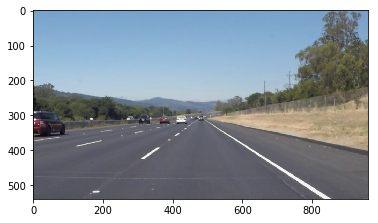

In [38]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [39]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            print(line)
    """
    #print("Start image.")
    ## Plan:
    ## Find the average of each value (y1, y2...)
    ## For each one if the x values are less than the average it is on the left.
    ## Otherwise, it is on the right.
    ## For each one if the y values are less than the average it is on the bottom.
    ## Otherwise, it is on the top.
    ## Find the far left, the far right of each.
    ## 
    s_1 = 0.8
    s_2 = 0.5
    
    long_lines = []
    average_slope = 0
    ##print(type(lines), lines.shape)
    ## Test
    #verticies_1 = np.array([[(imshape[1] - 380, 340),(410, 340), (130, imshape[0]), (imshape[1],imshape[0])]], dtype=np.int32)
    imshape = img.shape
    cv2.line(img, (imshape[1] - 380, 340), (410,340), [0, 0, 255], 10)
    cv2.line(img, (410,340), (130, imshape[0]), [0, 0, 255], 10)
    cv2.line(img, (imshape[1] - 380, 340), (410,340), [0, 0, 255], 10)
    cv2.line(img, (imshape[1] - 380, 340), (imshape[1], imshape[0]), [0, 0, 255], 10)
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            line_len = ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5
            temp_slope = ((y2-y1)/(x2-x1))
            if line_len >= 100 and temp_slope < s_1 and temp_slope > s_2 or temp_slope > - s_1 and temp_slope < - s_2:
                print(temp_slope)
                long_lines.append(np.array([[x1, y1, x2, y2]]))
                temp_slope = ((y2-y1)/(x2-x1))
                average_slope += temp_slope
                cv2.line(img, (x1, y1), (x2, y2), [0, 255, 0], thickness)
                
    long_lines = np.array(long_lines)
    print(type(long_lines), long_lines.shape)
    average_slope /= long_lines.shape[0]
    
    ##left_lines = []
    ##right_lines = []
    
    left_average_x = 0
    left_average_y = 0
    right_average_x = 0
    right_average_y = 0
    
    left_average_slope = 0
    right_average_slope = 0
    
    left_total = 0
    right_total = 0
    
    for line in long_lines:
        for x1, y1, x2, y2 in line:
            ##cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            temp_slope = ((y2-y1)/(x2-x1))
            if temp_slope >= average_slope:
                ## On the left side.
                ##left_lines.append(np.array([[x1, y1, x2, y2]]))
                left_average_x += x1 + x2
                left_average_y += y1 + y2
                left_average_slope += ((y2-y1)/(x2-x1))
                left_total += 1
            else:
                ## On the right side.
                ##right_lines.append(np.array([[x1, y1, x2, y2]]))
                right_average_x += x1 + x2
                right_average_y += y1 + y2
                right_average_slope += ((y2-y1)/(x2-x1))
                right_total += 1
        
    try:
        left_average_x /= left_total * 2
        left_average_y /= left_total * 2
        left_average_slope /= left_total
    except:
        left_average_x = 1
        left_average_y = 1
        left_average_slope = 1
        
    try:
        right_average_x /= right_total * 2
        right_average_y /= right_total * 2
        right_average_slope /= right_total
    except:
        right_average_x = 1
        right_average_y = 1
        right_average_slope = 1
    
    ## Calculate the new lines to show.
    top_limit = 360
    bottom_limit = img.shape[0]
    
    ## y = mx + b
    ## b = y - mx
    ## x = (y-b)/m
    try:
        left_b = left_average_y - left_average_slope * left_average_x
        left_top_x = (top_limit - left_b) / left_average_slope
        left_bottom_x = (bottom_limit - left_b) / left_average_slope
    except:
        left_top_x = 1
        left_bottom_x = 1
    
    try:
        right_b = right_average_y - right_average_slope * right_average_x
        right_top_x = (top_limit - right_b) / right_average_slope
        right_bottom_x = (bottom_limit - right_b) / right_average_slope
    except:
        right_top_x = 1
        right_bottom_x = 1

    if np.isnan(left_bottom_x) or np.isnan(left_top_x):
        left_bottom_x = 1
        left_top_x = 1
        
    if np.isnan(right_bottom_x) or np.isnan(right_top_x):
        right_bottom_x = 1
        right_top_x = 1
    
    ##print(left_bottom_x, left_top_x, right_bottom_x, right_top_x)
    ##print(left_bottom_x, bottom_limit, left_top_x, top_limit)
    ##print(right_bottom_x, bottom_limit, right_top_x, top_limit)
    cv2.line(img, (int(left_bottom_x), bottom_limit), (int(left_top_x), top_limit), color, thickness*2)
    cv2.line(img, (int(right_bottom_x), bottom_limit), (int(right_top_x), top_limit), color, thickness*2)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [40]:
import os
os.listdir("test_images/")

['challenge.jpg',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

-0.778301886792
-0.780327868852
<class 'numpy.ndarray'> (2, 1, 4)
This image is: <class 'numpy.ndarray'> with dimensions: (653, 1162, 3)
0.553672316384
0.577259475219
0.554621848739
0.577259475219
<class 'numpy.ndarray'> (4, 1, 4)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.622641509434
0.649659863946
0.625786163522
0.651933701657
<class 'numpy.ndarray'> (4, 1, 4)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
-0.703296703297
-0.730538922156
-0.731182795699
<class 'numpy.ndarray'> (3, 1, 4)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
-0.72380952381
-0.72027972028
-0.755656108597
0.6
0.574074074074
<class 'numpy.ndarray'> (5, 1, 4)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
-0.726457399103
-0.673469387755
-0.724264705882
<class 'numpy.ndarray'> (3, 1, 4)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
-0.781746031746
-0.752525252525
0.6
<class 'numpy.ndarray'> (3

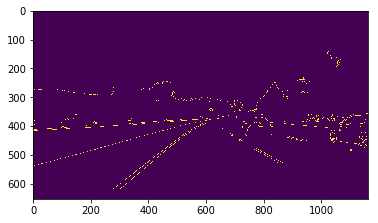

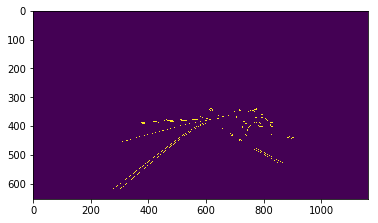

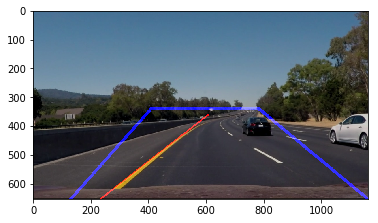

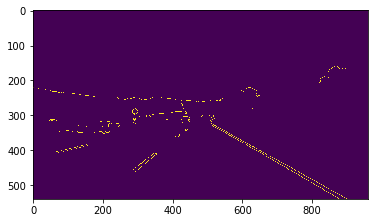

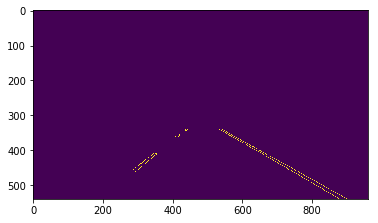

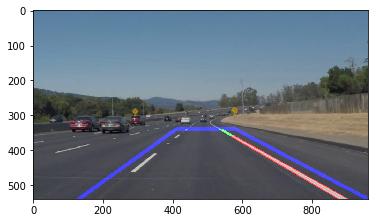

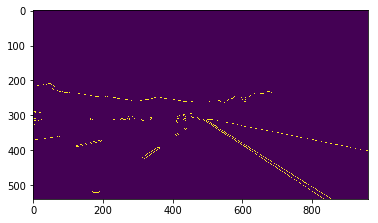

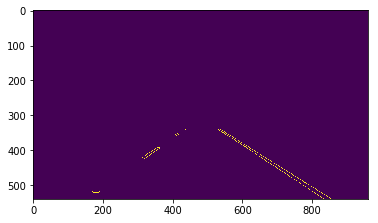

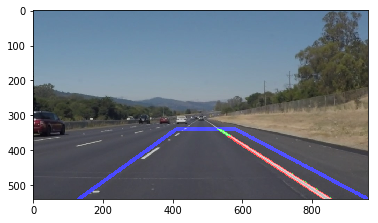

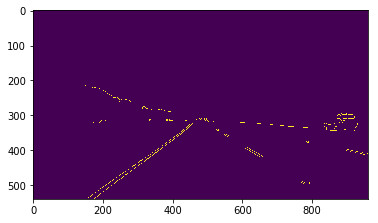

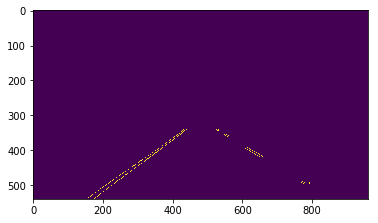

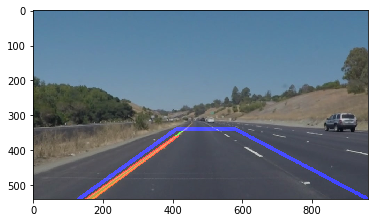

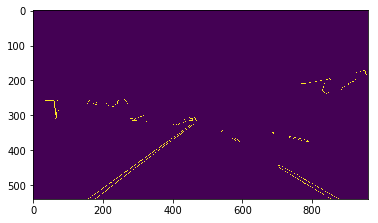

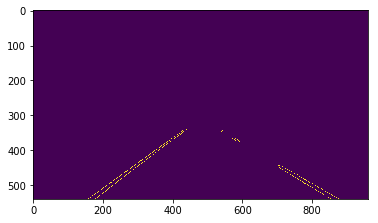

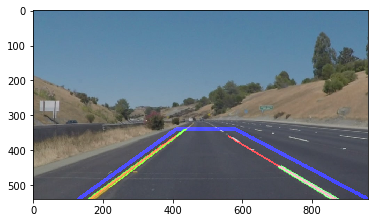

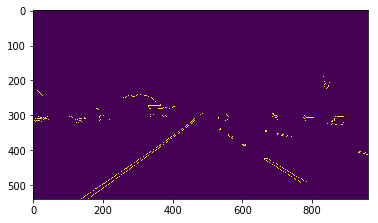

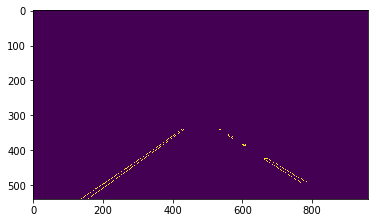

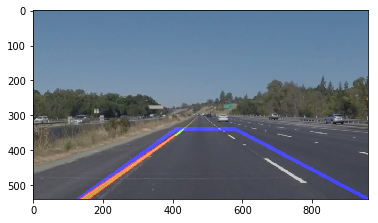

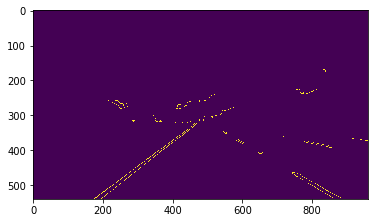

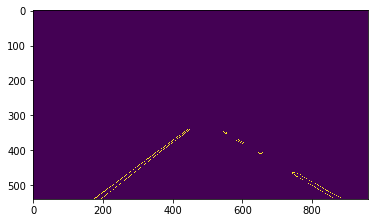

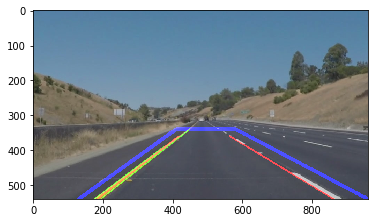

In [41]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

def load_image(s):
    return mpimg.imread(s)

def process_image(img):
    gray = grayscale(img)
    
    gaus_kernel = 7
    gaus = gaussian_blur(gray, gaus_kernel)
    
    canny_low = 80
    canny_high = 220
    canny_img = canny(gaus, canny_low, canny_high)
    plt.figure()
    plt.imshow(canny_img)
    
    imshape = img.shape
    #verticies_1 = np.array([[(100,imshape[0]),(420, 375), (375, 550), (imshape[1] - 75,imshape[0])]], dtype=np.int32)
    
    verticies_1 = np.array([[(imshape[1] - 380, 340),(410, 340), (130, imshape[0]), (imshape[1],imshape[0])]], dtype=np.int32)
    reg_1 = region_of_interest(canny_img, verticies_1)
    verticies_2 = np.array([[(420,350),(420, 300), (550, 300), (550, 350)]], dtype=np.int32)
    reg_2 = region_of_interest(canny_img, verticies_2)
    plt.figure()
    plt.imshow(reg_1)
    rho = 1
    theta = np.pi/180
    threshold = 125
    min_line_length = 20
    max_line_gap = 75
    
    rho_2 = 1
    theta_2 = np.pi/180
    threshold_2 = 10
    min_line_length_2 = 1
    max_line_gap_2 = 30
    
    hough_1 = hough_lines(reg_1, rho, theta, threshold, min_line_length, max_line_gap)
    ##hough_2 = hough_lines(reg_2, rho_2, theta_2, threshold_2, min_line_length_2, max_line_gap_2)
    
    
    img_with_hough = weighted_img(hough_1, img)
    ##return img_with_hough
    return img_with_hough

def process_images(imgs):
    for img_str in imgs:
        img = load_image('test_images/' + img_str)
        final_image = process_image(img)
        #printing out some stats and plotting
        print('This image is:', type(final_image), 'with dimensions:', final_image.shape)
        plt.figure()
        plt.imshow(final_image)

img_list = os.listdir('test_images/')
process_images(img_list)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [42]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [43]:
def process_image(img):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)

    gray = grayscale(img)
    
    gaus_kernel = 3
    gaus = gaussian_blur(gray, gaus_kernel)
    
    canny_low = 80
    canny_high = 150
    canny_img = canny(gaus, canny_low, canny_high)
    #plt.figure()
    #plt.imshow(canny_img)
    
    imshape = img.shape
    verticies_1 = np.array([[(imshape[1] - 380, 340),(410, 340), (100, imshape[0]), (imshape[1],imshape[0])]], dtype=np.int32)
    reg_1 = region_of_interest(canny_img, verticies_1)
    verticies_2 = np.array([[(420,350),(420, 300), (550, 300), (550, 350)]], dtype=np.int32)
    reg_2 = region_of_interest(canny_img, verticies_2)
    
    rho = 1
    theta = np.pi/150
    threshold = 10
    min_line_length = 70
    max_line_gap = 250
    
    rho_2 = 1
    theta_2 = np.pi/180
    threshold_2 = 10
    min_line_length_2 = 1
    max_line_gap_2 = 20
    
    hough_1 = hough_lines(reg_1, rho, theta, threshold, min_line_length, max_line_gap)

    #hough_1 = hough_lines(reg_1, rho, theta, threshold, min_line_length, max_line_gap)
    ##hough_2 = hough_lines(reg_2, rho_2, theta_2, threshold_2, min_line_length_2, max_line_gap_2)
    
    
    result = weighted_img(hough_1, img)
    return result
    #return canny_img

Let's try the one with the solid white lane on the right first ...

In [44]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

-0.728070175439
0.603571428571
0.632587859425
0.633757961783
0.604294478528
-0.75652173913
0.634146341463
-0.757709251101
-0.725
-0.723849372385
-0.72514619883
-0.758771929825
<class 'numpy.ndarray'> (12, 1, 4)
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


  2%|▏         | 5/222 [00:00<00:05, 42.67it/s]

-0.728070175439
0.603571428571
0.632587859425
0.633757961783
0.604294478528
-0.75652173913
0.634146341463
-0.757709251101
-0.725
-0.723849372385
-0.72514619883
-0.758771929825
<class 'numpy.ndarray'> (12, 1, 4)
0.603658536585
0.63606557377
-0.722222222222
-0.759541984733
0.605263157895
-0.760784313725
-0.727272727273
0.604863221884
0.635782747604
-0.724137931034
-0.757322175732
-0.723404255319
<class 'numpy.ndarray'> (12, 1, 4)
0.634615384615
0.604863221884
-0.725806451613
0.60447761194
-0.761538461538
-0.758893280632
-0.725714285714
0.63453815261
0.635782747604
-0.724489795918
-0.760479041916
0.605504587156
-0.758754863813
<class 'numpy.ndarray'> (13, 1, 4)
0.58064516129
0.584615384615
0.632587859425
-0.79
-0.72514619883
-0.72
-0.788043478261
-0.791139240506
0.554140127389
-0.695833333333
0.583333333333
0.554054054054
-0.792452830189
-0.789473684211
0.556603773585
-0.724637681159
0.634551495017
<class 'numpy.ndarray'> (17, 1, 4)
0.633440514469
0.602362204724
0.633440514469
0.603076923

  7%|▋         | 15/222 [00:00<00:04, 43.74it/s]

0.634615384615
0.634615384615
0.604863221884
-0.763358778626
-0.69696969697
0.60625
-0.666666666667
-0.661417322835
0.605863192182
0.635782747604
-0.723214285714
-0.754237288136
<class 'numpy.ndarray'> (12, 1, 4)
0.60736196319
-0.725609756098
0.63453815261
-0.692307692308
0.605504587156
-0.728915662651
0.63601532567
-0.697986577181
-0.728395061728
0.636363636364
-0.699421965318
-0.631578947368
0.605839416058
<class 'numpy.ndarray'> (13, 1, 4)
0.606498194946
0.635869565217
0.636752136752
-0.694581280788
0.603125
-0.725888324873
-0.727748691099
0.60736196319
-0.69109947644
-0.69696969697
-0.693467336683
<class 'numpy.ndarray'> (11, 1, 4)
-0.693548387097
0.603658536585
0.638554216867
0.635294117647
-0.725738396624
0.610526315789
0.635416666667
-0.692
-0.696356275304
-0.692307692308
0.582524271845
-0.666666666667
0.612403100775
<class 'numpy.ndarray'> (13, 1, 4)
0.605504587156
-0.695804195804
-0.728624535316
0.637583892617
0.615384615385
0.606271777003
0.606334841629
-0.7375
0.717171717172

 11%|█         | 24/222 [00:00<00:04, 39.90it/s]

0.631782945736
0.664383561644
0.633879781421
-0.723926380368
-0.692307692308
-0.722772277228
0.664179104478
-0.695652173913
-0.691428571429
0.632508833922
0.664092664093
-0.658536585366
<class 'numpy.ndarray'> (12, 1, 4)
0.664233576642
0.631578947368
0.62962962963
0.631111111111
0.66220735786
-0.752688172043
-0.691588785047
-0.691542288557
-0.662037037037
-0.662337662338
-0.662337662338
-0.725388601036
<class 'numpy.ndarray'> (12, 1, 4)
0.661904761905
0.632183908046
0.629834254144
0.663003663004
-0.726907630522
-0.695817490494
-0.694214876033
-0.693181818182
0.665540540541
-0.665369649805
-0.725806451613
-0.726907630522
<class 'numpy.ndarray'> (12, 1, 4)
0.630434782609
0.661417322835
0.665551839465
0.62962962963
-0.727941176471
-0.696296296296
-0.723880597015
0.66091954023
0.664429530201
-0.697183098592
-0.727941176471
-0.695035460993
<class 'numpy.ndarray'> (12, 1, 4)
0.607028753994
0.641221374046
-0.725
-0.726708074534
0.60777385159
0.690789473684
-0.692771084337
0.583941605839
0.610

 13%|█▎        | 28/222 [00:00<00:04, 39.52it/s]

0.633720930233
0.662447257384
0.630901287554
-0.727611940299
-0.693950177936
-0.693430656934
0.628318584071
0.662790697674
-0.69387755102
0.663043478261
-0.761904761905
-0.724489795918
-0.695238095238
-0.692737430168
-0.693181818182
-0.694117647059
<class 'numpy.ndarray'> (16, 1, 4)
0.630331753555
0.661478599222
-0.756198347107
0.65625
-0.695340501792
0.632352941176
0.630630630631
-0.792452830189
-0.633802816901
0.663366336634
-0.695652173913
-0.696261682243
-0.793388429752
-0.725609756098
0.630434782609
-0.729323308271
<class 'numpy.ndarray'> (16, 1, 4)
0.661016949153
0.633802816901
0.663507109005
0.611464968153
-0.694244604317
-0.725490196078
-0.691756272401
-0.726495726496
0.583333333333
0.584
-0.696428571429
-0.694214876033
<class 'numpy.ndarray'> (12, 1, 4)
0.611464968153
0.663366336634
0.661921708185
0.606498194946
0.606349206349
-0.723076923077
-0.730158730159
-0.726618705036
-0.720930232558
-0.725925925926
0.666666666667
0.660869565217
-0.726618705036
-0.76
<class 'numpy.ndarra

 14%|█▍        | 32/222 [00:00<00:05, 36.65it/s]

0.608150470219
0.606498194946
0.662983425414
0.605555555556
-0.788461538462
0.688741721854
0.605177993528
-0.666666666667
0.696428571429
-0.789473684211
-0.693965517241
0.665492957746
-0.666666666667
-0.644444444444
-0.760869565217
0.719101123596
<class 'numpy.ndarray'> (16, 1, 4)


 17%|█▋        | 37/222 [00:00<00:04, 38.48it/s]

0.607407407407
0.639705882353
0.606349206349
0.641221374046
0.640449438202
0.606451612903
-0.792079207921
-0.666666666667
-0.666666666667
-0.664
0.606557377049
-0.792079207921
-0.725
<class 'numpy.ndarray'> (13, 1, 4)
0.608365019011
0.66220735786
0.717391304348
-0.694267515924
0.605863192182
-0.724832214765
0.71875
0.584269662921
0.606164383562
-0.75572519084
-0.69375
-0.694444444444
0.71875
0.581920903955
-0.763157894737
0.663716814159
0.580487804878
0.720430107527
<class 'numpy.ndarray'> (18, 1, 4)
0.662878787879
0.664893617021
0.63
-0.727272727273
0.626984126984
-0.694300518135
-0.727272727273
-0.69109947644
-0.7265625
-0.722513089005
0.633928571429
0.663865546218
-0.69587628866
-0.69587628866
<class 'numpy.ndarray'> (14, 1, 4)
0.664383561644
0.661478599222
0.633333333333
-0.760368663594
0.633064516129
-0.69298245614
-0.692946058091
0.66220735786
-0.756944444444
-0.758064516129
0.635416666667
-0.79
0.627659574468
-0.756756756757
<class 'numpy.ndarray'> (14, 1, 4)
0.663157894737
-0.6

 18%|█▊        | 41/222 [00:01<00:04, 36.91it/s]

0.632258064516
0.664359861592
0.664429530201
0.633333333333
-0.72268907563
-0.665254237288
-0.754545454545
-0.725099601594
-0.794520547945
0.664835164835
0.664429530201
-0.726114649682
-0.666666666667
-0.758928571429
-0.664473684211
-0.6953125
<class 'numpy.ndarray'> (16, 1, 4)


 20%|██        | 45/222 [00:01<00:05, 33.89it/s]

0.665505226481
0.635782747604
0.664429530201
0.63503649635
-0.761904761905
-0.722627737226
-0.724637681159
0.663461538462
-0.722222222222
-0.692857142857
0.634686346863
-0.722222222222
-0.729927007299
0.632587859425
<class 'numpy.ndarray'> (14, 1, 4)
0.635782747604
0.665517241379
0.663677130045
-0.722222222222
-0.791666666667
-0.760563380282
0.634831460674
0.664406779661
-0.760273972603
-0.726708074534
-0.69696969697
<class 'numpy.ndarray'> (11, 1, 4)
0.665198237885
0.633757961783
0.664429530201
0.634482758621
-0.663366336634
-0.731343283582
-0.670454545455
0.634615384615
-0.729323308271
0.634517766497
-0.666666666667
-0.638461538462
<class 'numpy.ndarray'> (12, 1, 4)
0.634328358209
0.665540540541
-0.72514619883
0.665198237885
0.634615384615
-0.663461538462
-0.669724770642
-0.698412698413
-0.668421052632
-0.693023255814
-0.664893617021
<class 'numpy.ndarray'> (11, 1, 4)
0.665454545455
0.633116883117
0.664429530201
-0.692307692308
-0.758333333333
-0.752066115702
0.664473684211
0.6346153

 22%|██▏       | 49/222 [00:01<00:05, 31.45it/s]

-0.758620689655
-0.755555555556
<class 'numpy.ndarray'> (10, 1, 4)
0.633757961783
0.664429530201
-0.690607734807
0.666666666667
-0.79020979021
-0.69918699187
-0.757396449704
-0.726708074534
0.63453815261
-0.669230769231
-0.694610778443
<class 'numpy.ndarray'> (11, 1, 4)
0.633757961783
0.666666666667
-0.757142857143
0.666666666667
0.634408602151
-0.696035242291
0.666666666667
-0.697674418605
0.632587859425
-0.789115646259
-0.723214285714
-0.794520547945
-0.695652173913
<class 'numpy.ndarray'> (13, 1, 4)
0.665540540541
0.633757961783
-0.697183098592
-0.7265625
0.634551495017
0.664335664336
-0.7265625
-0.723880597015
-0.727699530516
-0.696113074205
0.666666666667
0.634615384615
-0.727272727273
<class 'numpy.ndarray'> (13, 1, 4)
0.633757961783
0.664429530201
0.666666666667
-0.697183098592
0.666666666667
-0.722222222222
0.634686346863
-0.695035460993
-0.728301886792
-0.73417721519
0.634615384615
-0.723926380368
-0.726114649682
-0.696774193548
<class 'numpy.ndarray'> (14, 1, 4)


 25%|██▌       | 56/222 [00:01<00:06, 25.92it/s]

0.666666666667
0.633757961783
0.666666666667
0.634615384615
-0.694736842105
-0.72972972973
0.666666666667
-0.725925925926
-0.694029850746
-0.724489795918
0.634408602151
-0.695431472081
<class 'numpy.ndarray'> (12, 1, 4)
0.635782747604
0.664429530201
0.663967611336
-0.76
-0.66393442623
-0.665338645418
0.63430420712
-0.666666666667
-0.665217391304
-0.754545454545
-0.757201646091
-0.666666666667
0.63430420712
<class 'numpy.ndarray'> (13, 1, 4)
0.632587859425
0.66220735786
0.632587859425
0.664596273292
-0.694117647059
-0.694029850746
-0.692307692308
-0.692913385827
-0.696153846154
-0.692857142857
-0.697674418605
<class 'numpy.ndarray'> (11, 1, 4)
0.664429530201
0.633757961783
-0.725490196078
-0.61038961039
0.632450331126
0.665048543689
-0.6125
-0.75
0.6336996337
0.665551839465
-0.725490196078
<class 'numpy.ndarray'> (11, 1, 4)
0.664429530201
0.632508833922
0.63430420712
-0.69387755102
-0.695906432749
-0.723958333333
0.663333333333
-0.725388601036
-0.692682926829
-0.695035460993
0.631578947

 27%|██▋       | 59/222 [00:01<00:06, 23.48it/s]

0.663157894737
0.634686346863
0.663333333333
0.632231404959
-0.695473251029
-0.757763975155
-0.727810650888
0.633928571429
-0.691699604743
-0.69387755102
-0.692307692308
0.630769230769
-0.758865248227
-0.693396226415
<class 'numpy.ndarray'> (14, 1, 4)
0.663333333333
0.632231404959
0.633962264151
-0.756756756757
-0.695652173913
-0.664383561644
0.663082437276
-0.721804511278
0.632727272727
-0.697478991597
-0.692307692308
0.664122137405
-0.758620689655
<class 'numpy.ndarray'> (13, 1, 4)
0.664429530201
0.631944444444
0.66220735786
0.632958801498
-0.724358974359
-0.633802816901
-0.693693693694
-0.727848101266
0.633757961783
-0.694267515924
-0.723404255319
<class 'numpy.ndarray'> (11, 1, 4)
0.632258064516
0.66220735786
0.632587859425
-0.666666666667
0.666666666667
-0.69387755102
-0.698795180723
-0.665
-0.666666666667
-0.69387755102
0.664335664336
<class 'numpy.ndarray'> (11, 1, 4)
0.634615384615
0.666666666667
-0.722943722944
0.669230769231
-0.666666666667
0.666666666667
0.663636363636
-0.72

 29%|██▉       | 65/222 [00:02<00:06, 23.81it/s]

0.634615384615
0.663507109005
-0.664383561644
-0.664429530201
-0.7
0.666666666667
0.666666666667
-0.696132596685
-0.664596273292
-0.697872340426
-0.693333333333
0.635294117647
-0.639455782313
0.640625
-0.664406779661
<class 'numpy.ndarray'> (15, 1, 4)
0.666666666667
0.634615384615
-0.663194444444
0.665480427046
0.634980988593
-0.701030927835
0.666666666667
-0.665529010239
-0.663157894737
-0.693181818182
0.636363636364
-0.69387755102
-0.691860465116
-0.702702702703
<class 'numpy.ndarray'> (14, 1, 4)
0.634615384615
0.666666666667
-0.725925925926
0.635983263598
0.666666666667
-0.66220735786
-0.664359861592
-0.666666666667
-0.755952380952
-0.727659574468
0.674157303371
-0.664835164835
0.666666666667
<class 'numpy.ndarray'> (13, 1, 4)
0.667938931298
0.635416666667
0.636054421769
0.663157894737
-0.693693693694
-0.664259927798
-0.664383561644
-0.665551839465
0.634920634921
-0.663082437276
-0.634453781513
0.634615384615
-0.694244604317
-0.696498054475
<class 'numpy.ndarray'> (14, 1, 4)
0.63636

 31%|███       | 68/222 [00:02<00:06, 22.26it/s]

0.635483870968
0.668103448276
0.666666666667
-0.69512195122
0.636363636364
-0.664705882353
-0.666666666667
-0.666666666667
-0.658682634731
<class 'numpy.ndarray'> (9, 1, 4)
0.634615384615
0.666666666667
0.664031620553
-0.628571428571
0.634615384615
-0.666666666667
-0.63768115942
0.635714285714
-0.663366336634
0.666666666667
-0.633333333333
-0.635922330097
0.665048543689
<class 'numpy.ndarray'> (13, 1, 4)
0.635483870968
0.665540540541
0.632587859425
0.666666666667
-0.662835249042
-0.692946058091
0.666666666667
-0.664092664093
-0.694560669456
-0.695473251029
0.634615384615
-0.664
-0.694560669456
<class 'numpy.ndarray'> (13, 1, 4)
0.666666666667
0.668269230769
0.659340659341
-0.688888888889
0.664634146341
0.656565656566
-0.631944444444
-0.692913385827
0.670588235294
-0.638655462185
-0.634482758621
-0.694444444444
<class 'numpy.ndarray'> (12, 1, 4)


 33%|███▎      | 74/222 [00:02<00:06, 22.16it/s]

0.636655948553
0.664285714286
0.666666666667
0.668269230769
-0.633136094675
-0.695945945946
0.638888888889
-0.633540372671
-0.721088435374
0.636363636364
-0.691729323308
-0.635714285714
-0.634482758621
<class 'numpy.ndarray'> (13, 1, 4)
0.660194174757
0.664473684211
0.666666666667
0.668571428571
-0.695187165775
-0.661290322581
0.656862745098
-0.664948453608
0.660714285714
-0.664948453608
-0.693989071038
<class 'numpy.ndarray'> (11, 1, 4)
0.636752136752
-0.663829787234
-0.69298245614
0.66847826087
0.634146341463
0.664596273292
-0.666666666667
-0.696428571429
0.666666666667
0.668711656442
-0.722222222222
-0.694063926941
0.636678200692
-0.694063926941
-0.694063926941
<class 'numpy.ndarray'> (15, 1, 4)
0.636363636364
0.668508287293
-0.661764705882
0.668508287293
-0.693661971831
0.637010676157
-0.6632996633
0.67032967033
-0.694736842105
0.634615384615
-0.692913385827
-0.664406779661
-0.664406779661
-0.69465648855
<class 'numpy.ndarray'> (14, 1, 4)
0.694736842105
-0.634980988593
0.6366906474

 35%|███▍      | 77/222 [00:02<00:06, 21.97it/s]

0.668674698795
0.6375
-0.670886075949
0.666666666667
0.635782747604
-0.637583892617
0.669902912621
0.641666666667
-0.633333333333
0.67032967033
-0.670731707317
-0.668246445498
<class 'numpy.ndarray'> (12, 1, 4)
0.693069306931
0.66081871345
0.690909090909
-0.696113074205
0.657894736842
-0.662835249042
0.695804195804
-0.635087719298
-0.697183098592
0.664285714286
-0.664092664093
-0.665094339623
-0.662222222222
0.69387755102
-0.635593220339
<class 'numpy.ndarray'> (15, 1, 4)
0.691699604743
0.66081871345
0.659420289855
0.692682926829
0.688741721854
-0.661870503597
-0.666666666667
0.696113074205
-0.642857142857
-0.692307692308
-0.694029850746
<class 'numpy.ndarray'> (11, 1, 4)
0.692592592593
0.661538461538
0.661764705882
0.693661971831
0.660194174757
-0.602739726027
0.693779904306
-0.584415584416
-0.75
-0.63025210084
0.662037037037
<class 'numpy.ndarray'> (11, 1, 4)
0.695804195804

 37%|███▋      | 83/222 [00:02<00:06, 20.91it/s]


0.661016949153
0.661764705882
0.694736842105
-0.61320754717
-0.75641025641
-0.610526315789
-0.757142857143
-0.606382978723
0.664122137405
<class 'numpy.ndarray'> (10, 1, 4)
0.692307692308
0.661596958175
0.664705882353
-0.692946058091
-0.6640625
0.663366336634
-0.691983122363
-0.664864864865
-0.661478599222
0.695035460993
-0.693333333333
-0.664092664093
0.694736842105
-0.659574468085
<class 'numpy.ndarray'> (14, 1, 4)
0.696428571429
0.694736842105
0.663333333333
0.665271966527
-0.697674418605
-0.606299212598
-0.697674418605
-0.606299212598
-0.692307692308
<class 'numpy.ndarray'> (9, 1, 4)
0.69741697417
0.694736842105
0.664310954064
0.6632996633
-0.633136094675
-0.664634146341
-0.630952380952
-0.75
0.694117647059
-0.686868686869
-0.636363636364
0.665551839465
-0.632653061224
<class 'numpy.ndarray'> (13, 1, 4)
0.665551839465
0.697115384615
0.696629213483
0.66220735786
-0.66265060241
-0.633165829146
-0.636363636364
-0.666666666667
-0.632124352332
-0.664948453608
0.698275862069
-0.69277108

 40%|████      | 89/222 [00:03<00:06, 22.12it/s]

0.663793103448
0.697183098592
0.66220735786
-0.694690265487
-0.635193133047
-0.631147540984
0.697247706422
-0.692307692308
0.6632996633
0.664429530201
-0.685714285714
-0.638888888889
0.694835680751
-0.631578947368
-0.69387755102
<class 'numpy.ndarray'> (15, 1, 4)
0.665551839465
0.694117647059
-0.662068965517
-0.633986928105
0.698412698413
-0.634146341463
-0.664383561644
-0.671232876712
-0.636029411765
-0.630952380952
-0.662116040956
-0.664406779661
0.663461538462
<class 'numpy.ndarray'> (13, 1, 4)
0.665551839465
0.694779116466
-0.657657657658
0.697247706422
-0.659090909091
-0.663865546218
0.664285714286
-0.692307692308
-0.661016949153
-0.669811320755
-0.666666666667
-0.675675675676
0.697841726619
-0.661764705882
0.697959183673
<class 'numpy.ndarray'> (15, 1, 4)
0.698113207547
0.666666666667
0.696356275304
-0.635179153094
-0.663507109005
-0.658536585366
-0.635179153094
0.660550458716
-0.634517766497
-0.666666666667
-0.668449197861
0.664406779661
-0.633561643836
-0.664705882353
<class 'n

 41%|████▏     | 92/222 [00:03<00:06, 21.01it/s]

0.664206642066
0.696428571429
0.703296703297
0.663333333333
0.699386503067
-0.692857142857
0.664383561644
-0.664335664336
-0.656565656566
-0.664383561644
-0.633986928105
0.697802197802
<class 'numpy.ndarray'> (12, 1, 4)
0.665551839465
0.7
-0.634408602151
0.695945945946
-0.664596273292
-0.664739884393
0.666666666667
-0.633879781421
0.7
0.664893617021
0.697115384615
-0.666666666667
-0.664772727273
-0.664634146341
<class 'numpy.ndarray'> (14, 1, 4)
0.665551839465
0.696078431373
0.700729927007
-0.635514018692
0.665480427046
0.663900414938
-0.665048543689
-0.661971830986
-0.663461538462
0.694915254237
-0.663212435233
-0.635944700461
<class 'numpy.ndarray'> (12, 1, 4)
0.665551839465
0.664429530201
0.701388888889
-0.66265060241
-0.636363636364
0.701612903226
-0.665236051502
0.664179104478
-0.640776699029
0.69387755102
-0.635593220339
-0.63601532567
0.726937269373
<class 'numpy.ndarray'> (13, 1, 4)
0.722826086957
0.695035460993
-0.63309352518
0.692307692308


 44%|████▍     | 98/222 [00:03<00:05, 23.10it/s]

0.722222222222
0.684782608696
-0.692307692308
0.727272727273
-0.694029850746
-0.611111111111
0.72268907563
-0.661764705882
-0.689655172414
<class 'numpy.ndarray'> (13, 1, 4)
0.664429530201
0.701298701299
0.664359861592
-0.666666666667
-0.630952380952
0.695364238411
0.664335664336
-0.631901840491
0.697674418605
-0.637037037037
-0.664335664336
-0.6
<class 'numpy.ndarray'> (12, 1, 4)
0.665540540541
0.700787401575
0.697802197802
0.664429530201
-0.633165829146
0.674418604651
0.700680272109
-0.664705882353
-0.634517766497
-0.663043478261
-0.666666666667
0.665505226481
-0.636363636364
<class 'numpy.ndarray'> (13, 1, 4)
0.694444444444
0.726368159204
0.692640692641
-0.635983263598
0.725321888412
-0.634146341463
-0.6375
-0.666666666667
-0.663461538462
-0.662162162162
0.754838709677
<class 'numpy.ndarray'> (11, 1, 4)
0.72268907563
0.692737430168
-0.634228187919
-0.695652173913
0.688
0.726277372263
-0.609467455621
-0.722222222222
-0.720930232558
-0.608695652174
-0.752688172043
-0.609375
0.72666666

 45%|████▌     | 101/222 [00:03<00:05, 22.72it/s]

0.724907063197
0.693023255814
-0.632587859425
-0.634615384615
-0.666666666667
0.692307692308
0.718446601942
-0.666666666667
-0.666666666667
-0.636363636364
0.6953125
-0.636363636364
0.72619047619
<class 'numpy.ndarray'> (13, 1, 4)
0.724264705882
0.691244239631
0.693548387097
-0.693379790941
-0.65625
0.690265486726
0.688679245283
-0.575342465753
-0.693661971831
0.725490196078
0.725925925926
-0.663414634146
-0.607142857143
-0.636363636364
-0.722222222222
<class 'numpy.ndarray'> (15, 1, 4)
0.72480620155
0.692307692308
0.690058479532
-0.633440514469
0.721088435374
0.693069306931
-0.666666666667
-0.665354330709
-0.664
-0.66265060241
-0.607142857143
<class 'numpy.ndarray'> (11, 1, 4)
0.665540540541
0.668711656442
0.722826086957
0.665529010239
0.670212765957
-0.694117647059
-0.634408602151
0.7265625
-0.661971830986
0.760330578512
-0.69696969697
-0.632653061224
-0.671428571429
<class 'numpy.ndarray'> (13, 1, 4)
0.664179104478
0.721804511278
0.664429530201
-0.636363636364
0.753731343284
0.75324

 48%|████▊     | 107/222 [00:04<00:05, 21.56it/s]

0.666666666667
0.699453551913
0.697802197802
0.663333333333
-0.664179104478
-0.635514018692
-0.666666666667
0.666666666667
-0.661764705882
-0.661971830986
-0.640776699029
-0.66265060241
-0.635467980296
<class 'numpy.ndarray'> (13, 1, 4)
0.664429530201
0.701612903226
0.69756097561
-0.662745098039
-0.718181818182
0.67032967033
-0.665354330709
0.69696969697
-0.72619047619
-0.66393442623
-0.663793103448
-0.662601626016
<class 'numpy.ndarray'> (12, 1, 4)
0.698492462312
0.665551839465
0.7
0.667953667954
-0.632
-0.701612903226
0.699248120301
-0.638461538462
-0.722222222222
-0.727272727273
<class 'numpy.ndarray'> (10, 1, 4)
0.666666666667
0.698924731183
0.666666666667
-0.691275167785
0.701149425287
-0.638709677419
-0.7
0.662921348315
-0.662420382166
-0.723880597015
-0.601769911504
0.665384615385
-0.72641509434
-0.666666666667
<class 'numpy.ndarray'> (14, 1, 4)
0.663900414938
0.7
-0.661375661376
-0.695652173913
0.700854700855
-0.691891891892
0.666666666667
-0.72514619883
-0.663043478261
0.66206

 50%|████▉     | 110/222 [00:04<00:05, 20.56it/s]

-0.662393162393
0.697674418605
-0.723076923077
-0.69387755102
0.696832579186
-0.662337662338
-0.694444444444
<class 'numpy.ndarray'> (13, 1, 4)
0.664429530201
-0.665505226481
0.697841726619
-0.691729323308
0.697674418605
-0.663157894737
0.697986577181
-0.724279835391
-0.695340501792
0.664122137405
0.670588235294
-0.664285714286
-0.66323024055
0.664596273292
0.695652173913
-0.722943722944
0.695187165775
<class 'numpy.ndarray'> (17, 1, 4)
0.664429530201
0.664429530201
0.696113074205
-0.665540540541
-0.701754385965
0.701612903226
0.697478991597
-0.697508896797
-0.663333333333
-0.664429530201
-0.69375
-0.69587628866
0.666666666667
-0.692810457516
-0.664705882353
<class 'numpy.ndarray'> (15, 1, 4)


 52%|█████▏    | 116/222 [00:04<00:05, 20.41it/s]

0.664429530201
0.694736842105
0.697183098592
-0.664429530201
0.665551839465
-0.703703703704
0.695652173913
-0.665540540541
-0.663414634146
-0.7
-0.727848101266
-0.69696969697
-0.661971830986
-0.660377358491
<class 'numpy.ndarray'> (14, 1, 4)
0.692307692308
0.66220735786
0.694214876033
-0.662162162162
0.694736842105
-0.726937269373
0.661129568106
-0.664
-0.664
-0.697368421053
-0.665529010239
-0.694174757282
-0.724489795918
<class 'numpy.ndarray'> (13, 1, 4)
0.664429530201
0.693661971831
0.693379790941
-0.691729323308
-0.657142857143
0.661596958175
-0.688888888889
0.661654135338
-0.692307692308
-0.694029850746
0.694736842105
-0.689393939394
-0.693430656934
<class 'numpy.ndarray'> (13, 1, 4)
0.664335664336
0.693379790941
0.694852941176
-0.724832214765
-0.72641509434
0.66393442623
-0.719626168224
-0.632530120482
-0.725490196078
-0.724832214765
-0.720930232558
0.664974619289
<class 'numpy.ndarray'> (12, 1, 4)
0.693661971831
0.662393162393
0.662068965517
0.694980694981
-0.726775956284
-0.662

 54%|█████▎    | 119/222 [00:04<00:05, 20.58it/s]

0.694339622642
0.663507109005
-0.611111111111
-0.637931034483
0.660256410256
-0.6375
-0.660714285714
0.689440993789
-0.637362637363
-0.608695652174
0.694736842105
0.696113074205
-0.69298245614
-0.696261682243
<class 'numpy.ndarray'> (14, 1, 4)
0.695804195804
0.661016949153
-0.662790697674
0.659685863874
-0.75
0.659090909091
0.694736842105
-0.75641025641
0.689873417722
-0.6632996633
-0.666666666667
-0.6632996633
-0.665517241379
-0.664429530201
<class 'numpy.ndarray'> (14, 1, 4)
0.636363636364
0.690909090909
-0.720588235294
0.644444444444
-0.6640625
-0.720930232558
0.692307692308
0.632587859425
0.637931034483
-0.662420382166
0.634615384615
-0.581395348837
0.60989010989
<class 'numpy.ndarray'> (13, 1, 4)
0.693379790941
0.694267515924
-0.697368421053
0.658333333333
-0.726666666667
0.65625
0.664335664336
0.695970695971
0.719696969697
-0.724137931034
-0.661375661376
0.610294117647
-0.638095238095
-0.694444444444
-0.608333333333
<class 'numpy.ndarray'> (15, 1, 4)
0.636655948553


 56%|█████▋    | 125/222 [00:04<00:04, 23.17it/s]

0.635483870968
0.669565217391
0.666666666667
0.665178571429
-0.664516129032
-0.724324324324
-0.634146341463
-0.694063926941
-0.666666666667
-0.752688172043
-0.752941176471
-0.693023255814
-0.755319148936
<class 'numpy.ndarray'> (14, 1, 4)
0.666666666667
0.635782747604
-0.723981900452
-0.69465648855
0.664429530201
-0.724324324324
0.663043478261
-0.664335664336
-0.694736842105
-0.724867724868
0.634241245136
-0.664285714286
0.634615384615
-0.788461538462
-0.719424460432
-0.723076923077
-0.664285714286
-0.758333333333
-0.758333333333
<class 'numpy.ndarray'> (19, 1, 4)
0.666666666667
0.635782747604
-0.694244604317
-0.661538461538
0.665322580645
-0.695035460993
-0.66220735786
0.662921348315
-0.696202531646
0.633561643836
-0.637096774194
<class 'numpy.ndarray'> (11, 1, 4)
0.633757961783
0.66220735786
-0.663157894737
-0.694736842105
0.665071770335
-0.659793814433
-0.693950177936
-0.694736842105
0.63453815261
-0.693069306931
-0.694736842105
-0.694805194805
<class 'numpy.ndarray'> (12, 1, 4)
0.6

 59%|█████▉    | 131/222 [00:05<00:04, 22.63it/s]

0.661971830986
0.631578947368
0.65873015873
0.630434782609
-0.668674698795
0.635294117647
-0.723684210526
0.66220735786
-0.726666666667
-0.638554216867
-0.690322580645
<class 'numpy.ndarray'> (11, 1, 4)
0.661538461538
0.630136986301
0.66
0.628205128205
-0.666666666667
-0.722222222222
0.660256410256
0.631578947368
-0.614457831325
-0.695187165775
-0.663316582915
0.631067961165
-0.663316582915
<class 'numpy.ndarray'> (13, 1, 4)
0.66091954023
0.661224489796
0.630434782609
0.630057803468
0.632478632479
-0.694915254237
-0.694690265487
-0.697777777778
0.628318584071
0.66220735786
0.630573248408
-0.69298245614
-0.695652173913
-0.695652173913
-0.665289256198
-0.725352112676
<class 'numpy.ndarray'> (16, 1, 4)
0.660714285714
0.605263157895
0.60736196319
0.608280254777
0.720930232558
-0.725806451613
0.664429530201
-0.669172932331
-0.664383561644
0.719101123596
0.719101123596
0.720430107527
0.608391608392
-0.754385964912
-0.786666666667
-0.664233576642
0.719512195122
<class 'numpy.ndarray'> (17, 1,

 60%|██████    | 134/222 [00:05<00:04, 21.76it/s]

0.661016949153
0.629139072848
-0.697247706422
0.630630630631
-0.727272727273
0.662790697674
0.626373626374
-0.725490196078
0.690058479532
-0.725961538462
-0.696261682243
0.628318584071
0.691358024691
0.691489361702
-0.722488038278
-0.71875
<class 'numpy.ndarray'> (16, 1, 4)
0.661417322835
-0.72480620155
-0.725490196078
-0.695167286245
0.631578947368
0.661458333333
0.628378378378
-0.696629213483
0.664429530201
0.660377358491
0.632478632479
-0.695817490494
-0.69465648855
-0.72619047619
<class 'numpy.ndarray'> (14, 1, 4)
0.661654135338
-0.727941176471
0.631016042781
-0.695804195804
0.632124352332
0.663265306122
0.634408602151
-0.693661971831
-0.726890756303
-0.727941176471
0.625
0.666666666667
-0.696202531646
-0.692810457516
0.721804511278
<class 'numpy.ndarray'> (15, 1, 4)
-0.693379790941
-0.724264705882
0.605405405405
0.662857142857
0.659574468085
0.629139072848
0.637362637363
-0.691489361702
-0.727777777778
0.664310954064
-0.693181818182
-0.728301886792
0.68992248062
-0.725925925926
0.

 63%|██████▎   | 140/222 [00:05<00:03, 21.93it/s]

0.661290322581
0.631147540984
0.660377358491
-0.693379790941
0.631944444444
-0.725925925926
0.631067961165
0.62962962963
0.665517241379
-0.693181818182
0.664
-0.755434782609
-0.725925925926
-0.730290456432
-0.696832579186
-0.693965517241
0.630630630631
<class 'numpy.ndarray'> (17, 1, 4)
0.605504587156
0.606498194946
0.665551839465
0.644444444444
0.65873015873
-0.72131147541
0.689440993789
0.607594936709
-0.692307692308
0.693333333333
0.71875
-0.694214876033
-0.763157894737
-0.671755725191
0.718446601942
-0.698412698413
<class 'numpy.ndarray'> (16, 1, 4)
0.638613861386
0.605504587156
-0.692810457516
0.60663507109
-0.721854304636
0.637795275591
0.634146341463
-0.695652173913
-0.726666666667
-0.72027972028
-0.724137931034
<class 'numpy.ndarray'> (11, 1, 4)
0.605678233438
0.606811145511
0.640845070423
0.643564356436
0.606557377049
-0.694300518135
0.616279069767
-0.72625698324
-0.728323699422
-0.69109947644
0.63829787234
-0.697674418605
-0.666666666667
-0.725714285714
0.609195402299
-0.7288

 66%|██████▌   | 146/222 [00:05<00:03, 21.98it/s]

0.662835249042
0.632743362832
0.629213483146
-0.724264705882
0.633333333333
-0.724264705882
-0.693950177936
0.664233576642
-0.693379790941
0.661616161616
-0.696428571429
0.662790697674
<class 'numpy.ndarray'> (12, 1, 4)
0.662393162393
0.63137254902
0.662878787879
0.631578947368
-0.72602739726
-0.691275167785
0.660606060606
-0.693333333333
-0.695945945946
-0.694214876033
-0.721088435374
<class 'numpy.ndarray'> (11, 1, 4)
0.60546875
0.605863192182
0.642201834862
-0.759259259259
0.642857142857
-0.722222222222
0.612403100775
0.644444444444
-0.757575757576
-0.694444444444
-0.721854304636
0.605911330049
0.579545454545
-0.727272727273
-0.725
-0.664429530201
<class 'numpy.ndarray'> (16, 1, 4)
0.606060606061
0.664921465969
0.606694560669
0.607260726073
0.611111111111
-0.722222222222
-0.791304347826
0.605734767025
-0.785123966942
-0.694444444444
0.691666666667
0.689189189189
-0.695187165775
-0.730337078652
-0.757575757576
0.692810457516
0.664429530201
0.606271777003
-0.727777777778
<class 'numpy

 67%|██████▋   | 149/222 [00:05<00:03, 23.30it/s]

0.605769230769
0.66049382716
-0.731707317073
0.689393939394
-0.717391304348
0.658333333333
-0.725
-0.730061349693
-0.725490196078
0.611940298507
-0.730769230769
-0.725490196078
0.552631578947
0.691891891892
-0.725490196078
0.584615384615
0.549668874172
0.628787878788
-0.726618705036
-0.72602739726
0.639705882353
0.554794520548
<class 'numpy.ndarray'> (22, 1, 4)
0.659259259259
0.663967611336
0.608870967742
-0.75572519084
-0.696153846154
0.66220735786
0.603658536585
-0.758620689655
-0.693661971831
-0.664596273292
-0.731182795699
-0.757575757576
0.656565656566
0.688405797101
0.693251533742
<class 'numpy.ndarray'> (15, 1, 4)
0.637096774194
0.607142857143
0.605590062112
0.634615384615
-0.693661971831
-0.758620689655
-0.696113074205
-0.756862745098
-0.72602739726
0.635944700461
-0.759036144578
-0.72602739726
-0.723756906077
<class 'numpy.ndarray'> (13, 1, 4)
0.60701754386
0.636363636364
0.634615384615
0.605504587156
-0.700787401575
-0.758333333333
-0.729508196721
-0.760330578512
-0.760330578

 70%|██████▉   | 155/222 [00:06<00:02, 22.92it/s]

0.662100456621
0.658536585366
0.608333333333
0.661596958175
-0.72192513369
0.663043478261
0.6875
0.692810457516
-0.758620689655
-0.723404255319
-0.760233918129
-0.726775956284
0.577235772358
-0.72268907563
0.689189189189
0.690265486726
0.608695652174
<class 'numpy.ndarray'> (17, 1, 4)
0.636363636364
0.605678233438
0.607438016529
0.556701030928
-0.724770642202
-0.725961538462
0.6875
-0.727678571429
0.719101123596
-0.723981900452
-0.75845410628
0.717647058824
-0.727848101266
-0.758793969849
-0.727678571429
-0.695652173913
<class 'numpy.ndarray'> (16, 1, 4)
0.639175257732
0.578231292517
0.607843137255
0.602649006623
-0.758754863813
-0.693548387097
0.557692307692
0.579831932773
0.637795275591
-0.729083665339
0.556701030928
-0.695340501792
-0.724528301887
0.556701030928
-0.787356321839
-0.670588235294
0.664864864865
<class 'numpy.ndarray'> (17, 1, 4)
0.60843373494
0.60736196319
0.634831460674
-0.699115044248
0.635193133047
0.63829787234
0.635416666667
-0.757575757576
-0.699300699301
-0.7611

 71%|███████   | 158/222 [00:06<00:02, 22.94it/s]

0.63430420712
0.604294478528
-0.757201646091
-0.722222222222
-0.759183673469
0.634615384615
0.639455782313
-0.72131147541
-0.760330578512
-0.758474576271
-0.726530612245
-0.7265625
<class 'numpy.ndarray'> (12, 1, 4)
0.603333333333
0.63321799308
0.605590062112
-0.756653992395
-0.725888324873
-0.758754863813
0.633116883117
-0.726666666667
0.601156069364
-0.72972972973
-0.721854304636
<class 'numpy.ndarray'> (11, 1, 4)
0.633757961783
0.602836879433
0.604166666667
-0.760617760618
-0.730337078652
0.602040816327
-0.697916666667
0.634615384615
-0.726775956284
-0.757692307692
0.632768361582
-0.724770642202
-0.758754863813
-0.726775956284
<class 'numpy.ndarray'> (14, 1, 4)
0.601809954751
0.631782945736
0.633757961783
-0.721893491124
-0.758754863813
-0.755868544601
-0.758754863813
0.60162601626
-0.725663716814
0.633333333333
-0.725225225225
-0.725490196078
0.603896103896
-0.759433962264
0.579505300353
<class 'numpy.ndarray'> (15, 1, 4)
0.579234972678
0.608163265306
0.606451612903
0.576023391813


 74%|███████▍  | 165/222 [00:06<00:02, 22.05it/s]

0.632142857143
0.578767123288
0.583333333333
0.577319587629
0.578947368421
-0.698717948718
-0.760563380282
0.552995391705
-0.787878787879
0.631970260223
-0.697916666667
0.632743362832
-0.758620689655
-0.759656652361
0.579831932773
-0.696551724138
<class 'numpy.ndarray'> (16, 1, 4)
0.578181818182
0.60736196319
0.577259475219
0.606153846154
-0.724137931034
-0.794520547945
0.577181208054
-0.729885057471
0.606896551724
-0.724137931034
-0.697142857143
-0.759493670886
-0.697674418605
<class 'numpy.ndarray'> (13, 1, 4)
0.577259475219
0.603658536585
0.577259475219
-0.791208791209
0.605504587156
-0.757142857143
0.577142857143
0.605911330049
-0.760765550239
-0.757425742574
-0.76
-0.755905511811
<class 'numpy.ndarray'> (12, 1, 4)
0.576811594203
0.603658536585
0.605504587156
0.577259475219
-0.759036144578
-0.725274725275
-0.792792792793
-0.730434782609
-0.725925925926
<class 'numpy.ndarray'> (9, 1, 4)
0.575581395349

 77%|███████▋  | 171/222 [00:06<00:02, 21.38it/s]


0.604863221884
-0.757352941176
0.605095541401
-0.793893129771
0.576811594203
-0.789473684211
-0.759124087591
0.577259475219
-0.757352941176
0.604938271605
-0.788617886179
<class 'numpy.ndarray'> (12, 1, 4)
0.576811594203
0.606707317073
0.575581395349
-0.793548387097
0.605015673981
-0.792207792208
-0.728395061728
0.605577689243
0.577319587629
-0.757763975155
-0.753086419753
-0.793103448276
-0.789808917197
<class 'numpy.ndarray'> (13, 1, 4)
0.576811594203
0.603658536585
-0.790322580645
-0.753731343284
-0.758974358974
0.577259475219
-0.791443850267
-0.792134831461
-0.760869565217
-0.759162303665
0.605504587156
-0.757731958763
<class 'numpy.ndarray'> (12, 1, 4)
0.604863221884
0.578488372093
-0.793859649123
0.576687116564
-0.758333333333
0.603658536585
-0.793103448276
-0.757322175732
0.577259475219
-0.728571428571
-0.758620689655
-0.792626728111
<class 'numpy.ndarray'> (12, 1, 4)
0.578488372093
0.605504587156
-0.793388429752
-0.757692307692
-0.760273972603
0.605590062112
-0.755813953488
-0

 78%|███████▊  | 174/222 [00:07<00:02, 21.81it/s]

0.606153846154
0.577259475219
0.605769230769
-0.756756756757
0.578616352201
-0.796208530806
-0.793388429752
-0.793969849246
0.578947368421
0.605504587156
-0.791044776119
-0.727272727273
-0.795
<class 'numpy.ndarray'> (13, 1, 4)
0.577160493827
0.606349206349
0.578171091445
-0.79203539823
-0.793388429752
-0.789473684211
0.605095541401
0.605734767025
-0.789915966387
-0.763636363636
-0.69512195122
<class 'numpy.ndarray'> (11, 1, 4)
0.577507598784
0.605678233438
0.577259475219
-0.757352941176
0.575609756098
0.603658536585
-0.795454545455
0.605504587156
-0.75572519084
-0.796875
-0.762962962963
-0.794520547945
<class 'numpy.ndarray'> (12, 1, 4)
0.605504587156
0.605863192182
0.575581395349
0.577259475219
-0.758823529412
-0.760233918129
-0.757352941176
-0.79012345679
<class 'numpy.ndarray'> (8, 1, 4)
0.605960264901
0.574780058651
-0.759803921569
0.577712609971
0.576131687243
0.603703703704


 81%|████████  | 180/222 [00:07<00:01, 21.28it/s]

-0.757281553398
0.60621761658
-0.76
-0.757281553398
0.577981651376
<class 'numpy.ndarray'> (11, 1, 4)
0.574780058651
0.606153846154
0.605263157895
0.579268292683
-0.723214285714
-0.75956284153
-0.72972972973
-0.728205128205
0.606153846154
-0.760784313725
-0.727810650888
-0.725490196078
<class 'numpy.ndarray'> (12, 1, 4)
0.579113924051
0.606060606061
-0.732283464567
0.577380952381
0.575
0.606153846154
-0.72972972973
0.606425702811
-0.697674418605
<class 'numpy.ndarray'> (9, 1, 4)
0.578461538462
0.575144508671
0.605691056911
0.605504587156
-0.789115646259
-0.790540540541
0.574468085106
-0.790849673203
<class 'numpy.ndarray'> (8, 1, 4)
0.580128205128
0.605504587156
0.606164383562
-0.790960451977
-0.790849673203
0.577259475219
0.60736196319
-0.790960451977
0.606060606061
-0.792349726776
<class 'numpy.ndarray'> (10, 1, 4)


 84%|████████▍ | 186/222 [00:07<00:01, 22.55it/s]

0.577287066246
0.606707317073
-0.793103448276
0.577259475219
0.604395604396
0.577540106952
-0.792079207921
-0.793859649123
0.605633802817
-0.793859649123
<class 'numpy.ndarray'> (10, 1, 4)
0.605504587156
0.577557755776
-0.788888888889
0.575510204082
0.575581395349
0.605633802817
-0.791111111111
-0.7875
0.605504587156
<class 'numpy.ndarray'> (9, 1, 4)
0.605504587156
0.577259475219
0.577358490566
-0.791666666667
0.603658536585
-0.792682926829
-0.792682926829
0.578274760383
0.606557377049
<class 'numpy.ndarray'> (9, 1, 4)
0.608024691358
0.577844311377
0.575581395349
0.606060606061
0.606060606061
-0.792929292929
-0.759689922481
-0.79
-0.72619047619
0.575757575758
-0.79057591623
<class 'numpy.ndarray'> (11, 1, 4)
0.580508474576
0.576811594203
0.606153846154
-0.790983606557
0.605504587156
-0.758620689655
0.580952380952
-0.758620689655
-0.791836734694
0.551912568306
<class 'numpy.ndarray'> (10, 1, 4)


 85%|████████▌ | 189/222 [00:07<00:01, 23.01it/s]

0.607407407407
0.577712609971
0.605504587156
0.579310344828
0.581395348837
-0.762962962963
-0.792592592593
-0.758865248227
-0.761194029851
<class 'numpy.ndarray'> (9, 1, 4)
0.603658536585
0.577259475219
0.603658536585
-0.76
0.577205882353
-0.759036144578
-0.756578947368
-0.795918367347
<class 'numpy.ndarray'> (8, 1, 4)
0.575
0.603333333333
0.575851393189
0.602941176471
-0.755813953488
-0.731543624161
-0.761194029851
0.606707317073
-0.755102040816
-0.759689922481
-0.760273972603
0.576158940397
-0.791208791209
-0.729166666667
<class 'numpy.ndarray'> (14, 1, 4)
0.574468085106
0.576271186441
0.601895734597
0.605504587156
-0.791304347826
-0.757575757576
-0.765306122449
0.602209944751
-0.7625
0.575757575758
-0.758196721311
0.6
-0.76404494382
<class 'numpy.ndarray'> (13, 1, 4)
0.548476454294
0.550151975684
-0.755905511811
0.605863192182
0.629921259843
0.551020408163
0.552631578947
-0.761904761905
0.656565656566
0.654761904762
0.659574468085
0.602693602694
0.633540372671
0.627450980392
<class 

 88%|████████▊ | 195/222 [00:08<00:01, 23.59it/s]


0.604545454545
0.603921568627
0.573033707865
-0.756944444444
0.606060606061
-0.758389261745
0.6
-0.696428571429
0.574193548387
<class 'numpy.ndarray'> (10, 1, 4)
0.548476454294
0.554838709677
0.580838323353
-0.761111111111
0.528571428571
0.552631578947
0.586956521739
-0.765217391304
0.527131782946
-0.795031055901
-0.732876712329
<class 'numpy.ndarray'> (11, 1, 4)
0.574545454545
-0.75641025641
0.574545454545
0.578231292517
-0.795031055901
0.583333333333
-0.757446808511
0.579831932773
-0.755980861244
0.579439252336
-0.792682926829
0.579881656805
-0.79203539823
-0.754385964912
-0.762114537445
-0.76170212766
<class 'numpy.ndarray'> (16, 1, 4)
0.550387596899
0.602693602694
-0.757085020243
0.595505617978
0.604
-0.758620689655
0.556451612903
<class 'numpy.ndarray'> (7, 1, 4)
0.603333333333
0.574850299401
-0.759689922481
0.575875486381
0.603658536585
-0.758196721311
-0.763736263736
<class 'numpy.ndarray'> (7, 1, 4)


 91%|█████████ | 201/222 [00:08<00:00, 22.98it/s]

0.605504587156
0.575163398693
0.576419213974
-0.730769230769
0.595744680851
0.605504587156
-0.76
-0.730964467005
-0.758771929825
0.577557755776
-0.755813953488
-0.761506276151
<class 'numpy.ndarray'> (12, 1, 4)
0.575657894737
0.602739726027
0.598214285714
0.573913043478
0.603658536585
-0.789473684211
0.575221238938
-0.752136752137
-0.793859649123
<class 'numpy.ndarray'> (9, 1, 4)
0.604863221884
0.575757575758
0.6
0.57225433526
0.574074074074
-0.789473684211
-0.760416666667
0.6
-0.795081967213
-0.797619047619
-0.791304347826
0.60396039604
0.575
<class 'numpy.ndarray'> (13, 1, 4)
0.574829931973
0.603658536585
0.58064516129
0.57671957672
0.605504587156
-0.793939393939
0.575539568345
-0.787878787879
-0.789156626506
0.576923076923
<class 'numpy.ndarray'> (10, 1, 4)
0.582278481013
0.551829268293
-0.795
0.55
0.553719008264
0.58389261745
0.551083591331
0.555555555556
0.552083333333
-0.792079207921
-0.792553191489
-0.795811518325
<class 'numpy.ndarray'> (12, 1, 4)
0.603658536585

 92%|█████████▏| 204/222 [00:08<00:00, 21.44it/s]


0.550488599349
0.551724137931
-0.763157894737
0.60409556314
-0.754545454545
0.605769230769
0.530303030303
0.65625
0.527559055118
-0.761904761905
-0.754545454545
0.605504587156
-0.792
-0.791304347826
0.527093596059
-0.727272727273
0.52808988764
<class 'numpy.ndarray'> (18, 1, 4)
0.573394495413
0.581151832461
0.573770491803
-0.792
0.58041958042
0.573964497041
0.581632653061
0.584158415842
0.574468085106
0.577777777778
-0.788617886179
-0.792
-0.788617886179
<class 'numpy.ndarray'> (13, 1, 4)
0.6038647343
0.572222222222
-0.761290322581
0.572192513369
0.57
0.603448275862
0.602836879433
0.603225806452
-0.735294117647
<class 'numpy.ndarray'> (9, 1, 4)
0.604761904762
0.603174603175
0.549668874172
-0.755319148936
0.548746518106
0.605960264901
0.658333333333
-0.758064516129
0.521008403361
0.656565656566
0.525714285714
0.525773195876
0.631016042781
<class 'numpy.ndarray'> (13, 1, 4)
0.579881656805

 95%|█████████▍| 210/222 [00:08<00:00, 22.02it/s]


0.548476454294
0.551724137931
-0.759656652361
0.554285714286
0.580086580087
-0.758928571429
0.577586206897
0.576086956522
-0.79203539823
-0.761904761905
-0.761194029851
0.527777777778
<class 'numpy.ndarray'> (13, 1, 4)
0.55
0.603448275862
0.600985221675
-0.788944723618
0.604316546763
0.527607361963
0.603225806452
0.548476454294
0.605263157895
-0.790055248619
-0.728205128205
0.527472527473
<class 'numpy.ndarray'> (12, 1, 4)
0.577669902913
0.577777777778
0.552941176471
0.550561797753
-0.75572519084
-0.795180722892
0.578125
-0.760617760618
-0.75641025641
0.570422535211
<class 'numpy.ndarray'> (10, 1, 4)
0.55
0.577259475219
0.577259475219
-0.756637168142
-0.759689922481
0.551020408163
0.577777777778
-0.79381443299
<class 'numpy.ndarray'> (8, 1, 4)
0.548746518106
0.576023391813
0.548476454294
-0.791836734694
-0.793388429752
0.577259475219
-0.792
-0.795081967213
-0.790983606557
-0.791164658635
<class 'numpy.ndarray'> (10, 1, 4)


 96%|█████████▌| 213/222 [00:08<00:00, 23.13it/s]

0.548476454294
0.575581395349
0.576023391813
0.549295774648
0.576791808874
-0.787610619469
0.55
-0.759689922481
<class 'numpy.ndarray'> (8, 1, 4)
0.575581395349
0.548476454294
0.574534161491
0.549723756906
-0.767123287671
-0.733333333333
0.548746518106
-0.760869565217
<class 'numpy.ndarray'> (8, 1, 4)
0.551246537396
0.575581395349
0.575581395349
0.55
-0.793893129771
0.577464788732
-0.794736842105
-0.758974358974
<class 'numpy.ndarray'> (8, 1, 4)
0.575581395349
0.552036199095
0.551532033426
-0.790322580645
-0.759259259259
-0.757009345794
0.551829268293
-0.758196721311
0.577712609971
-0.759493670886
-0.730434782609
-0.763636363636
-0.756653992395
-0.759689922481
<class 'numpy.ndarray'> (14, 1, 4)


 99%|█████████▊| 219/222 [00:09<00:00, 21.36it/s]

0.549418604651
0.577259475219
0.550200803213
-0.759398496241
0.577689243028
0.578488372093
-0.758064516129
-0.790697674419
-0.790697674419
<class 'numpy.ndarray'> (9, 1, 4)
0.577259475219
0.550561797753
0.577259475219
-0.759493670886
-0.7
-0.700934579439
0.551601423488
-0.791044776119
<class 'numpy.ndarray'> (8, 1, 4)
0.578947368421
0.551532033426
-0.75974025974
-0.761904761905
0.549668874172
-0.761467889908
-0.791443850267
-0.760416666667
-0.761904761905
<class 'numpy.ndarray'> (9, 1, 4)
0.550632911392
0.577259475219
0.578635014837
0.551495016611
-0.788990825688
-0.792626728111
-0.790243902439
-0.666666666667
<class 'numpy.ndarray'> (8, 1, 4)
0.550314465409
0.578171091445
0.577777777778
-0.760617760618
0.552631578947
-0.75935828877
0.580882352941
0.55
-0.723577235772
-0.730158730159
-0.726708074534
<class 'numpy.ndarray'> (11, 1, 4)


100%|█████████▉| 221/222 [00:09<00:00, 23.96it/s]


0.548746518106
0.58041958042
0.577777777778
0.553571428571
-0.756756756757
0.580110497238
-0.730337078652
-0.730769230769
-0.790540540541
-0.730337078652
0.577868852459
-0.731343283582
-0.722222222222
<class 'numpy.ndarray'> (13, 1, 4)
0.578947368421
0.549019607843
0.554945054945
-0.758754863813
0.578260869565
-0.762645914397
-0.760765550239
0.581920903955
-0.791878172589
0.551136363636
-0.760975609756
-0.758620689655
<class 'numpy.ndarray'> (12, 1, 4)
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 5.87 s, sys: 660 ms, total: 6.53 s
Wall time: 10.4 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [45]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [46]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

-0.632587859425
-0.605504587156
-0.635483870968
-0.605590062112
0.663793103448
0.665236051502
0.692307692308
0.665236051502
0.69696969697
-0.633986928105
0.692307692308
<class 'numpy.ndarray'> (11, 1, 4)
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


  1%|          | 4/682 [00:00<00:21, 31.21it/s]

-0.632587859425
-0.605504587156
-0.635483870968
-0.605590062112
0.663793103448
0.665236051502
0.692307692308
0.665236051502
0.69696969697
-0.633986928105
0.692307692308
<class 'numpy.ndarray'> (11, 1, 4)
-0.605504587156
-0.634615384615
0.695970695971
0.662116040956
-0.607717041801
0.662068965517
0.695
-0.634615384615
0.664383561644
-0.606811145511
0.665529010239
0.694244604317
0.664335664336
0.664092664093
0.664359861592
<class 'numpy.ndarray'> (15, 1, 4)
-0.63606557377
-0.606918238994
0.69387755102
0.664429530201
-0.606918238994
-0.63430420712
0.696428571429
0.6632996633
0.729411764706
0.664670658683
0.666666666667
<class 'numpy.ndarray'> (11, 1, 4)
-0.638157894737
-0.605504587156
0.695340501792
0.6632996633
-0.632352941176
-0.611111111111
0.695340501792
0.664948453608
-0.607142857143
0.693467336683
-0.604938271605
-0.603053435115
-0.637362637363
-0.606837606838
0.633333333333
0.691358024691
-0.692771084337
<class 'numpy.ndarray'> (17, 1, 4)
-0.607142857143
-0.60736196319
-0.636363636

  2%|▏         | 12/682 [00:00<00:19, 33.61it/s]

-0.6632996633
-0.632
-0.663829787234
-0.632587859425
-0.659863945578
-0.635135135135
0.662576687117
0.694267515924
0.664670658683
-0.663461538462
0.695652173913
-0.63
0.664634146341
0.695652173913
<class 'numpy.ndarray'> (14, 1, 4)
-0.664429530201
-0.635782747604
-0.664206642066
-0.633986928105
0.63503649635
-0.66220735786
-0.632587859425
0.586206896552
0.693121693122
0.696808510638
0.578947368421
0.723529411765
0.664893617021
<class 'numpy.ndarray'> (13, 1, 4)
-0.664406779661
-0.635782747604
0.632231404959
0.666666666667
-0.634615384615
-0.633333333333
0.663636363636
-0.66220735786
0.633744855967
0.662393162393
0.633744855967
0.634782608696
<class 'numpy.ndarray'> (12, 1, 4)
-0.665071770335
-0.634920634921
-0.664429530201
-0.636655948553
0.635451505017
0.666666666667
0.636666666667
0.664233576642
-0.635193133047
0.635416666667
-0.63430420712
-0.690821256039
0.693950177936
0.664864864865
<class 'numpy.ndarray'> (14, 1, 4)
-0.666666666667
-0.633757961783
0.660194174757
0.666666666667
-0

  3%|▎         | 21/682 [00:00<00:17, 37.64it/s]

-0.637583892617
-0.668965517241
-0.632142857143
0.606382978723
0.663333333333
0.608208955224
-0.756302521008
-0.63829787234
0.664383561644
-0.757575757576
0.664383561644
-0.614583333333
-0.63829787234
-0.759689922481
0.665338645418
-0.727941176471
0.634408602151
-0.606666666667
-0.610169491525
-0.6375
0.607142857143
-0.755555555556
<class 'numpy.ndarray'> (22, 1, 4)
-0.695340501792
-0.665137614679
0.638095238095
-0.664429530201
0.607594936709
0.604240282686
-0.693379790941
-0.664429530201
0.633663366337
-0.663793103448
0.632850241546
-0.691358024691
0.605633802817
0.635294117647
<class 'numpy.ndarray'> (14, 1, 4)
-0.665338645418
-0.693548387097
-0.695340501792
-0.665551839465
0.581280788177
0.6632996633
0.634854771784
0.662162162162
0.632653061224
-0.694736842105
0.690607734807
0.694444444444
-0.663594470046
-0.664359861592
<class 'numpy.ndarray'> (14, 1, 4)
-0.665492957746
-0.695970695971
-0.694214876033
0.578571428571
0.634146341463
0.664359861592
0.60625
-0.666666666667
-0.705882352

  4%|▍         | 29/682 [00:00<00:18, 35.60it/s]

-0.665551839465
-0.69756097561
-0.695278969957
0.601123595506
0.606741573034
0.634408602151
-0.665467625899
0.72380952381
0.688679245283
-0.696517412935
<class 'numpy.ndarray'> (10, 1, 4)
-0.665551839465
-0.695652173913
0.663366336634
-0.700787401575
0.632653061224
0.663366336634
-0.664429530201
0.635922330097
0.661458333333
-0.696335078534
-0.696581196581
0.659090909091
0.662790697674
-0.664259927798
0.659340659341
0.688888888889
<class 'numpy.ndarray'> (16, 1, 4)
-0.664406779661
-0.696035242291
0.60594795539
0.636771300448
-0.693989071038
-0.665399239544
-0.664359861592
0.602996254682
-0.7
0.605263157895
0.601769911504
0.62987012987
0.605363984674
-0.664835164835
<class 'numpy.ndarray'> (14, 1, 4)
0.60303030303
0.635379061372
-0.665480427046
-0.7
-0.665505226481
-0.704545454545
-0.669064748201
0.632743362832
0.60736196319
-0.664634146341
0.604575163399
-0.664596273292
-0.666666666667
0.606060606061
-0.723684210526
<class 'numpy.ndarray'> (15, 1, 4)
0.63430420712
-0.664285714286
-0.70

  5%|▍         | 33/682 [00:00<00:18, 35.51it/s]


-0.691588785047
-0.72641509434
-0.696428571429
0.659722222222
0.547169811321
-0.696113074205
0.603896103896
-0.729957805907
0.658536585366
-0.692307692308
0.53125
0.661971830986
-0.727699530516
0.661654135338
<class 'numpy.ndarray'> (15, 1, 4)
-0.728888888889
-0.693726937269
-0.695340501792
-0.723981900452
-0.693989071038
0.632183908046
0.66265060241
-0.726907630522
0.632183908046
-0.69776119403
<class 'numpy.ndarray'> (10, 1, 4)
-0.694029850746
-0.723214285714
0.576744186047
-0.726851851852
-0.694852941176
0.631205673759
-0.694300518135
0.579439252336
-0.728033472803
-0.697318007663
0.631205673759
0.602803738318
<class 'numpy.ndarray'> (12, 1, 4)
-0.724770642202
-0.696113074205
-0.694736842105
0.603260869565
0.576923076923
0.577519379845
0.57874015748
0.605882352941
-0.758426966292
0.663755458515
0.60752688172
-0.635802469136
0.604166666667
<class 'numpy.ndarray'> (13, 1, 4)
-0.695035460993
-0.725961538462
-0.694980694981
0.575851393189
-0.696113074205
0.633898305085
-0.701298701299


  6%|▌         | 41/682 [00:01<00:18, 33.84it/s]

0.630057803468
-0.792079207921
-0.635944700461
-0.723958333333
-0.720588235294
0.60824742268
-0.633663366337
-0.7890625
0.632978723404
0.659722222222
-0.638554216867
0.632352941176
<class 'numpy.ndarray'> (16, 1, 4)
-0.726872246696
-0.759090909091
0.604255319149
-0.724264705882
0.632286995516
-0.726114649682
-0.758620689655
0.635467980296
0.606837606838
-0.75974025974
-0.721518987342
0.633928571429
0.632850241546
<class 'numpy.ndarray'> (13, 1, 4)
-0.760504201681
0.604895104895
-0.726457399103
0.633858267717
0.604895104895
-0.726315789474
-0.758620689655
-0.725274725275
0.634686346863
0.634920634921
0.607142857143
-0.791208791209
-0.735632183908
<class 'numpy.ndarray'> (13, 1, 4)
-0.698181818182
0.58
-0.758620689655
0.57874015748
0.608108108108
0.606557377049
-0.758196721311
-0.698863636364
0.547169811321
0.609090909091
0.60487804878
-0.693798449612
-0.753246753247
0.551181102362
<class 'numpy.ndarray'> (14, 1, 4)
-0.698039215686
0.631756756757
-0.758426966292
-0.761538461538
-0.7
0.57

  7%|▋         | 49/682 [00:01<00:22, 28.49it/s]

-0.695970695971
-0.758620689655
-0.758793969849
-0.75
0.606060606061
0.605128205128
-0.790322580645
0.60736196319
0.603092783505
0.605263157895
-0.69741697417
-0.698630136986
0.605769230769
0.578680203046
<class 'numpy.ndarray'> (14, 1, 4)
-0.756756756757
-0.725663716814
-0.725806451613
0.604347826087
0.632075471698
-0.758169934641
-0.663414634146
0.604347826087
-0.758620689655
0.607843137255
-0.72641509434
0.635514018692
-0.759090909091
0.661016949153
<class 'numpy.ndarray'> (14, 1, 4)
-0.759803921569
-0.696750902527
0.602941176471
-0.696428571429
0.579124579125
-0.758620689655
0.577114427861
0.633962264151
0.576923076923
-0.67
0.577702702703
0.553072625698
-0.724299065421
0.633962264151
-0.788819875776
-0.666666666667
-0.728813559322
<class 'numpy.ndarray'> (17, 1, 4)
-0.759541984733
-0.726708074534
0.606451612903
-0.758241758242
-0.724576271186
0.635135135135
-0.717948717949
-0.758620689655
0.6
0.634328358209
-0.726315789474
0.633333333333
<class 'numpy.ndarray'> (12, 1, 4)
-0.75918

  8%|▊         | 52/682 [00:01<00:23, 27.13it/s]

-0.696750902527
-0.759036144578
0.602803738318
0.633663366337
-0.694610778443
0.635
0.635467980296
-0.695652173913
0.604651162791
-0.752941176471
0.608040201005
-0.791443850267
<class 'numpy.ndarray'> (12, 1, 4)
-0.697183098592
-0.789156626506
0.603921568627
0.632231404959
0.60546875
0.632653061224
-0.783783783784
-0.79
-0.788944723618
0.636363636364
-0.78835978836
-0.792207792208
0.634453781513
0.635245901639
-0.69776119403
0.633333333333
-0.66935483871
0.631578947368
<class 'numpy.ndarray'> (18, 1, 4)
-0.756653992395
-0.719101123596
-0.725888324873
0.576086956522
-0.726495726496
0.604938271605
0.603658536585
0.577049180328
-0.757692307692
-0.72
0.550561797753
0.577049180328
0.605263157895
<class 'numpy.ndarray'> (13, 1, 4)
-0.694736842105
-0.755813953488
-0.756613756614
0.575163398693
0.635782747604
0.632996632997
0.578397212544
-0.754716981132
0.634615384615
-0.696
0.631016042781
0.66081871345
-0.71875
-0.668674698795
0.578073089701
-0.668224299065
<class 'numpy.ndarray'> (16, 1, 4)

  9%|▊         | 58/682 [00:01<00:27, 23.05it/s]

-0.755952380952
-0.72268907563
-0.722543352601
-0.75
-0.754716981132
0.635782747604
-0.714285714286
0.607843137255
0.631578947368
0.633333333333
0.633466135458
0.640350877193
0.633561643836
-0.717948717949
-0.755905511811
0.60119047619
-0.7875
<class 'numpy.ndarray'> (17, 1, 4)
-0.666666666667
-0.666666666667
-0.729411764706
-0.724137931034
-0.722222222222
-0.718309859155
-0.668181818182
0.602649006623
0.638190954774
-0.664031620553
-0.670454545455
0.606666666667
-0.666666666667
0.6
0.605442176871
<class 'numpy.ndarray'> (15, 1, 4)
-0.693379790941
-0.697211155378
-0.754601226994
-0.753926701571
-0.700787401575
0.663865546218
0.603448275862
0.665198237885
-0.753424657534
-0.756756756757
0.604651162791
0.603550295858
0.606936416185
-0.760162601626
<class 'numpy.ndarray'> (14, 1, 4)
-0.695278969957
-0.755102040816
-0.695817490494
-0.753086419753
0.60396039604
0.662116040956
-0.759541984733
-0.7
-0.695652173913
0.608465608466
0.664383561644
0.695238095238
0.694444444444
0.604060913706
0.72

  9%|▉         | 61/682 [00:02<00:26, 23.24it/s]


-0.754491017964
0.604651162791
0.577235772358
-0.758620689655
-0.755244755245
0.578125
-0.698529411765
0.579591836735
0.662835249042
-0.789156626506
0.69
<class 'numpy.ndarray'> (14, 1, 4)
-0.731182795699
-0.696750902527
0.574750830565
-0.725118483412
0.635135135135
-0.730964467005
-0.730496453901
0.634782608696
0.635135135135
-0.696035242291
0.576158940397
0.580128205128
0.635087719298
<class 'numpy.ndarray'> (13, 1, 4)
-0.696629213483
-0.730593607306
-0.694736842105
0.637450199203
0.576158940397
-0.695652173913
0.578616352201
-0.72602739726
0.66323024055
0.636942675159
-0.700680272109
0.663967611336
-0.724
-0.723849372385
<class 'numpy.ndarray'> (14, 1, 4)
-0.72962962963
-0.696428571429
0.607329842932
-0.692307692308
0.633333333333
0.605263157895
0.634146341463
-0.728346456693
0.602094240838
0.605714285714
-0.726923076923
<class 'numpy.ndarray'> (11, 1, 4)
-0.727941176471
0.63679245283
-0.695804195804
0.603524229075
-0.728301886792
-0.694736842105
0.607142857143
-0.694063926941
0.63

 10%|▉         | 67/682 [00:02<00:27, 22.58it/s]

-0.728937728938
-0.693661971831
0.635338345865
-0.694444444444
-0.726923076923
0.634328358209
0.604395604396
0.607142857143
-0.695804195804
-0.694915254237
0.603703703704
0.633879781421
-0.726937269373
0.607142857143
<class 'numpy.ndarray'> (14, 1, 4)
0.632587859425
-0.725274725275
-0.694323144105
0.604361370717
0.605015673981
-0.695804195804
-0.727272727273
0.634854771784
-0.694444444444
0.602150537634
-0.690476190476
0.605150214592
0.603174603175
0.661971830986
<class 'numpy.ndarray'> (14, 1, 4)
-0.727941176471
-0.693950177936
0.632587859425
-0.694444444444
0.604863221884
0.632231404959
0.603375527426
0.634228187919
-0.726495726496
-0.695488721805
0.603524229075
0.545454545455
<class 'numpy.ndarray'> (12, 1, 4)
-0.694779116466
-0.7265625
-0.727941176471
0.578397212544
-0.694805194805
-0.693379790941
0.633440514469
0.603375527426
0.634615384615
0.631355932203
0.553488372093
-0.723684210526
<class 'numpy.ndarray'> (12, 1, 4)
-0.726923076923
-0.696035242291
-0.725274725275
-0.6958041958

 11%|█         | 73/682 [00:02<00:25, 24.18it/s]

-0.726235741445
-0.693379790941
-0.694915254237
-0.725274725275
0.664233576642
0.632653061224
0.663043478261
0.69587628866
0.633986928105
-0.662878787879
<class 'numpy.ndarray'> (10, 1, 4)
-0.755319148936
-0.695804195804
-0.704545454545
0.605405405405
-0.754901960784
0.660606060606
0.604651162791
-0.692607003891
-0.696
-0.755681818182
-0.705128205128
0.659090909091
-0.693693693694
0.606557377049
-0.698275862069
0.662337662338
<class 'numpy.ndarray'> (16, 1, 4)
-0.693467336683
-0.727941176471
-0.695804195804
-0.725274725275
0.604444444444
0.604444444444
0.601307189542
-0.726495726496
0.634146341463
-0.693181818182
-0.693333333333
0.604444444444
-0.694029850746
0.523076923077
0.605504587156
<class 'numpy.ndarray'> (15, 1, 4)
-0.666666666667
-0.666666666667
-0.694063926941
-0.698529411765
0.606617647059
-0.702380952381
-0.697674418605
-0.665369649805
0.695652173913
0.665289256198
0.662068965517
-0.640350877193
-0.723684210526
0.635983263598
0.664383561644
-0.695454545455
0.579545454545
-0

 12%|█▏        | 79/682 [00:02<00:27, 22.30it/s]

-0.727748691099
-0.694560669456
-0.726277372263
0.630434782609
0.605769230769
-0.69587628866
-0.725274725275
0.636363636364
-0.694244604317
0.605
0.605405405405
0.602040816327
0.605555555556
<class 'numpy.ndarray'> (13, 1, 4)
0.605577689243
-0.694690265487
-0.725490196078
0.634730538922
-0.693950177936
0.634517766497
0.606425702811
0.605691056911
-0.725274725275
0.604166666667
-0.694444444444
0.633802816901
-0.726114649682
<class 'numpy.ndarray'> (13, 1, 4)
-0.694117647059
-0.694444444444
0.605863192182
-0.7265625
-0.725274725275
0.63309352518
0.636363636364
-0.694852941176
0.636054421769
0.632575757576
0.607142857143
0.633802816901
0.633561643836
-0.694805194805
-0.575268817204
0.635714285714
-0.727941176471
<class 'numpy.ndarray'> (17, 1, 4)
-0.726277372263
0.631578947368
-0.69587628866
-0.695035460993
-0.725274725275
0.605769230769
0.606707317073
0.635338345865
0.632286995516
-0.695804195804
-0.72619047619
0.634831460674
0.605442176871
0.633540372671
-0.726315789474
0.635135135135
0

 12%|█▏        | 82/682 [00:02<00:26, 22.47it/s]

-0.665441176471
-0.666666666667
-0.695431472081
-0.666666666667
-0.69512195122
0.604938271605
0.662116040956
-0.665369649805
0.634517766497
-0.66265060241
0.603603603604
-0.790960451977
0.606153846154
-0.641975308642
0.637735849057
-0.79020979021
0.722772277228
-0.583333333333
-0.629213483146
0.60625
<class 'numpy.ndarray'> (20, 1, 4)
-0.665480427046
-0.666666666667
-0.756613756614
-0.697095435685
0.666666666667
0.608695652174
-0.75641025641
-0.755319148936
-0.640625
0.602941176471
-0.63503649635
-0.640449438202
-0.636842105263
0.632
0.605839416058
0.692307692308
-0.637130801688
-0.699029126214
<class 'numpy.ndarray'> (18, 1, 4)
-0.691919191919
-0.725806451613
-0.688888888889
-0.725925925926
0.692307692308
0.664
0.662162162162
0.661971830986
-0.696202531646
-0.755813953488
-0.726618705036
-0.754385964912
<class 'numpy.ndarray'> (12, 1, 4)
-0.665540540541
-0.664335664336
-0.755555555556
0.633333333333
-0.755319148936
-0.75641025641
-0.756906077348
-0.754098360656
0.664705882353
-0.57894

 13%|█▎        | 88/682 [00:03<00:27, 21.41it/s]

-0.694444444444
-0.723247232472
-0.722222222222
-0.69014084507
0.665369649805
0.633962264151
-0.689655172414
0.664092664093
0.665322580645
0.602189781022
-0.723404255319
0.66393442623
-0.690647482014
0.689655172414
0.666666666667
-0.726530612245
<class 'numpy.ndarray'> (16, 1, 4)
-0.666666666667
-0.723214285714
0.6640625
-0.724137931034
0.632653061224
-0.673469387755
0.661971830986
-0.727941176471
0.632653061224
-0.66220735786
-0.719008264463
0.666666666667
<class 'numpy.ndarray'> (12, 1, 4)
-0.6632996633
-0.696808510638
-0.700680272109
0.604519774011
-0.697674418605
-0.668341708543
0.691780821918
0.69375
0.603658536585
-0.668292682927
-0.666666666667
-0.666666666667
0.605839416058
0.632911392405
-0.666666666667
0.693548387097
<class 'numpy.ndarray'> (16, 1, 4)
-0.665369649805
0.663366336634
-0.695402298851
-0.666666666667
-0.697674418605
-0.698275862069
0.63184079602
-0.696808510638
-0.663333333333
0.634517766497
0.664974619289
0.68992248062
0.630872483221
0.724137931034
0.63297872340

 13%|█▎        | 91/682 [00:03<00:27, 21.13it/s]

-0.665369649805
0.662551440329
-0.699453551913
-0.69512195122
0.634146341463
0.662551440329
0.634615384615
0.663551401869
-0.666666666667
-0.696428571429
0.631578947368
-0.69512195122
0.633858267717
-0.663333333333
-0.665492957746
<class 'numpy.ndarray'> (15, 1, 4)
-0.665480427046
-0.720588235294
0.6632996633
-0.725190839695
0.606153846154
0.606060606061
-0.72131147541
-0.668103448276
-0.730158730159
-0.724528301887
0.694300518135
0.665540540541
0.580487804878
0.662790697674
0.632653061224
-0.753521126761
-0.730158730159
0.578231292517
-0.726277372263
0.691729323308
<class 'numpy.ndarray'> (20, 1, 4)
-0.665384615385
0.629032258065
-0.69756097561
0.636363636364
-0.697368421053
0.631578947368
0.631578947368
0.63184079602
0.686046511628
0.633986928105
0.633333333333
-0.666666666667
0.636363636364
-0.696428571429
-0.696428571429
0.633333333333
0.636363636364
-0.664
0.631016042781
<class 'numpy.ndarray'> (19, 1, 4)
-0.663755458515
-0.697508896797
-0.665517241379
0.664429530201
-0.6987951807

 14%|█▍        | 97/682 [00:03<00:27, 20.99it/s]

-0.695431472081
-0.700934579439
-0.668181818182
0.602150537634
0.666666666667
0.666666666667
0.659420289855
0.721649484536
-0.674698795181
0.607407407407
-0.69298245614
0.661870503597
<class 'numpy.ndarray'> (13, 1, 4)
-0.665441176471
-0.697368421053
-0.695970695971
-0.698412698413
0.605882352941
0.662162162162
-0.669491525424
0.666666666667
0.632530120482
-0.663333333333
0.632075471698
0.6625
<class 'numpy.ndarray'> (12, 1, 4)
-0.664122137405
-0.691964285714
-0.7
0.6328125
-0.693333333333
-0.701923076923
0.60396039604
-0.663333333333
-0.666666666667
0.60487804878
0.608333333333
0.604278074866
-0.757425742574
-0.665322580645
0.693181818182
0.605911330049
<class 'numpy.ndarray'> (16, 1, 4)
-0.66220735786
-0.725274725275
-0.722543352601
-0.721893491124
0.635555555556
0.636363636364
-0.641221374046
0.632911392405
0.633187772926
-0.725274725275
0.632478632479
0.629310344828
-0.754601226994
-0.611111111111
0.661971830986
<class 'numpy.ndarray'> (15, 1, 4)


 15%|█▍        | 100/682 [00:03<00:29, 19.73it/s]

-0.726235741445
-0.689655172414
-0.701492537313
0.634057971014
-0.686868686869
-0.7
0.634517766497
-0.68992248062
0.634057971014
0.63475177305
0.63601532567
-0.606694560669
0.635838150289
-0.698630136986
-0.693181818182
0.580188679245
0.633451957295
-0.638554216867
-0.636363636364
<class 'numpy.ndarray'> (19, 1, 4)
-0.664429530201
-0.722222222222
-0.668316831683
0.66393442623
0.601503759398
-0.723163841808
0.603896103896
-0.727611940299
-0.718309859155
-0.666666666667
0.609271523179
0.691729323308
0.691729323308
<class 'numpy.ndarray'> (13, 1, 4)
-0.697478991597
-0.664310954064
-0.701492537313
-0.666666666667
-0.664429530201
0.630057803468
-0.700729927007
0.660714285714
0.631901840491
0.664670658683
-0.672727272727
-0.694300518135
-0.666666666667
-0.7
0.666666666667
0.664670658683
<class 'numpy.ndarray'> (16, 1, 4)
-0.7
-0.66814159292
-0.6632996633
-0.696296296296
0.634146341463
0.623529411765
-0.665551839465
0.606796116505
-0.664864864865
-0.666666666667
0.633663366337
0.636363636364


 15%|█▌        | 103/682 [00:04<00:29, 19.83it/s]

-0.664429530201
-0.700564971751
-0.6953125
0.60593220339
0.663829787234
-0.698412698413
-0.663333333333
0.608108108108
0.602739726027
-0.666666666667
0.663755458515
0.606557377049
0.691823899371
-0.632768361582
0.663829787234
-0.69512195122
0.606481481481
<class 'numpy.ndarray'> (17, 1, 4)
-0.666666666667
0.662020905923
-0.665551839465
0.634259259259
-0.699481865285
-0.698412698413
0.633333333333
0.63503649635
0.635451505017
0.664310954064
0.664285714286
-0.694736842105
0.693121693122
0.633802816901
0.634812286689
<class 'numpy.ndarray'> (15, 1, 4)
-0.66220735786
0.6632996633
-0.699152542373
-0.69587628866
0.632850241546
0.634703196347
0.633064516129
-0.666666666667
0.633879781421
0.663507109005
0.666666666667
0.691666666667
0.691860465116
-0.664
<class 'numpy.ndarray'> (14, 1, 4)
-0.665551839465
-0.697247706422
0.641304347826
-0.665505226481
-0.696850393701
0.60777385159
0.607638888889
0.634408602151
0.607594936709
-0.698529411765
0.598214285714
0.605734767025
-0.788659793814
0.605536

 16%|█▌        | 109/682 [00:04<00:26, 21.38it/s]

-0.69512195122
-0.663333333333
-0.664310954064
-0.69696969697
0.669064748201
-0.701923076923
0.601307189542
-0.663677130045
0.608391608392
0.659259259259
-0.75845410628
0.661971830986
<class 'numpy.ndarray'> (12, 1, 4)
-0.666666666667
-0.695833333333
-0.662116040956
-0.701754385965
0.637037037037
0.603448275862
0.578313253012
-0.695402298851
<class 'numpy.ndarray'> (8, 1, 4)
-0.664233576642
-0.697802197802
-0.699074074074
0.694736842105
0.633663366337
0.633663366337
-0.704545454545
0.694117647059
-0.664285714286
0.633663366337
0.632183908046
<class 'numpy.ndarray'> (11, 1, 4)
-0.665441176471
-0.695402298851
-0.699507389163
0.663793103448
0.661458333333
-0.663333333333
0.662162162162
0.632653061224
0.662393162393
0.663865546218
0.634854771784
-0.69696969697
0.604255319149
0.663043478261
<class 'numpy.ndarray'> (14, 1, 4)
-0.664429530201
-0.696035242291
0.661654135338
-0.701612903226
0.604501607717
0.662020905923
-0.698412698413
0.638059701493
-0.665467625899
0.664335664336
0.66438356164

 17%|█▋        | 115/682 [00:04<00:26, 21.70it/s]

-0.665551839465
-0.666666666667
-0.69696969697
0.60736196319
-0.695431472081
0.636363636364
-0.665217391304
0.636363636364
-0.699248120301
0.607407407407
-0.702127659574
0.602836879433
0.662068965517
0.577586206897
<class 'numpy.ndarray'> (14, 1, 4)
-0.66220735786
-0.701754385965
-0.693989071038
0.662921348315
-0.697916666667
0.630434782609
0.662162162162
0.634408602151
-0.665551839465
0.66091954023
0.636678200692
-0.788235294118
0.633333333333
-0.788235294118
-0.669902912621
-0.663900414938
<class 'numpy.ndarray'> (16, 1, 4)
-0.664429530201
-0.722513089005
0.606194690265
0.634482758621
-0.725925925926
-0.719696969697
0.661904761905
-0.7265917603
0.606060606061
0.605263157895
-0.686746987952
-0.724137931034
-0.691358024691
0.60824742268
0.582278481013
<class 'numpy.ndarray'> (15, 1, 4)
-0.664429530201
0.635593220339
-0.724137931034
0.605166051661
-0.722772277228
-0.725490196078
0.604743083004
0.607407407407
0.60593220339
-0.725274725275
-0.666666666667
0.661971830986
<class 'numpy.ndar

 17%|█▋        | 118/682 [00:04<00:27, 20.25it/s]

-0.665551839465
-0.695
0.639175257732
0.60625
0.638613861386
-0.698717948718
0.607594936709
-0.702702702703
0.632124352332
-0.671232876712
-0.664233576642
-0.699248120301
0.605351170569
-0.666666666667
0.634615384615
0.631067961165
<class 'numpy.ndarray'> (16, 1, 4)
-0.66220735786
-0.697674418605
0.662068965517
-0.666666666667
-0.698564593301
0.663265306122
0.630057803468
0.604361370717
0.633484162896
0.692737430168
0.636363636364
0.66393442623
0.577669902913
0.581081081081
<class 'numpy.ndarray'> (14, 1, 4)
-0.69756097561
-0.664429530201
-0.665551839465
-0.692946058091
0.578680203046
-0.664516129032
0.605960264901
0.576642335766
0.663265306122
0.689440993789
0.694214876033
<class 'numpy.ndarray'> (11, 1, 4)
-0.665540540541
-0.698924731183
-0.70297029703
-0.664429530201
0.584269662921
-0.666666666667
-0.694444444444
0.659863945578
0.666666666667
0.664473684211
0.661870503597
<class 'numpy.ndarray'> (11, 1, 4)


 18%|█▊        | 124/682 [00:04<00:26, 20.68it/s]

-0.72619047619
-0.723214285714
-0.691943127962
-0.6953125
0.632978723404
-0.685714285714
0.632978723404
0.695652173913
0.632183908046
-0.754491017964
-0.755813953488
-0.688172043011
0.664772727273
-0.754601226994
0.632432432432
<class 'numpy.ndarray'> (15, 1, 4)
-0.724637681159
-0.691943127962
-0.723247232472
-0.690909090909
0.692307692308
-0.685393258427
0.66091954023
0.720720720721
0.663507109005
0.665071770335
-0.69
0.659090909091
0.666666666667
0.605263157895
0.607843137255
<class 'numpy.ndarray'> (15, 1, 4)
-0.691244239631
-0.726937269373
-0.725961538462
-0.684782608696
0.63829787234
0.662921348315
-0.724637681159
0.637362637363
0.662790697674
0.579831932773
-0.692307692308
0.606870229008
0.605839416058
-0.694117647059
0.604651162791
<class 'numpy.ndarray'> (15, 1, 4)
-0.692660550459
-0.725321888412
0.662162162162
-0.685714285714
-0.725274725275
-0.693548387097
0.630136986301
-0.726368159204
0.665529010239
-0.690647482014
0.664233576642
-0.727272727273
0.607843137255
0.66187050359

 19%|█▊        | 127/682 [00:05<00:27, 20.43it/s]

-0.726277372263
0.605504587156
-0.692307692308
-0.724264705882
0.629213483146
-0.691588785047
0.606965174129
0.602094240838
-0.692913385827
0.606796116505
0.605911330049
0.602150537634
<class 'numpy.ndarray'> (12, 1, 4)
-0.756097560976
-0.690322580645
0.662551440329
-0.753846153846
-0.64
0.603846153846
-0.754285714286
-0.794392523364
0.66393442623
0.606177606178
-0.577464788732
0.663157894737
-0.665354330709
-0.756097560976
-0.606837606838
0.606060606061
0.690721649485
0.661417322835
-0.666666666667
-0.786259541985
<class 'numpy.ndarray'> (20, 1, 4)
-0.691891891892
-0.726277372263
0.630872483221
-0.689873417722
0.60625
0.636363636364
0.604651162791
-0.726618705036
-0.695652173913
0.605351170569
0.634868421053
0.605678233438
-0.755555555556
-0.694736842105
0.636363636364
-0.722488038278
<class 'numpy.ndarray'> (16, 1, 4)
-0.725274725275
-0.724137931034
0.606811145511
-0.691056910569
-0.690217391304
0.634146341463
-0.693430656934
0.605590062112
0.634482758621
-0.72268907563
0.63580246913

 20%|█▉        | 133/682 [00:05<00:24, 22.81it/s]


0.604361370717
-0.691919191919
0.634517766497
0.634703196347
0.636363636364
-0.694444444444
-0.725806451613
0.634259259259
-0.69387755102
0.62962962963
0.632183908046
0.60553633218
-0.723404255319
-0.690476190476
<class 'numpy.ndarray'> (17, 1, 4)
-0.723636363636
-0.692810457516
-0.686868686869
0.60736196319
-0.691666666667
-0.725925925926
0.666666666667
0.695906432749
0.634686346863
0.66935483871
0.578651685393
0.632768361582
0.663793103448
<class 'numpy.ndarray'> (13, 1, 4)
-0.724576271186
-0.726277372263
-0.692307692308
-0.688405797101
0.637583892617
0.604166666667
-0.694117647059
-0.694444444444
0.633333333333
-0.690647482014
0.554455445545
0.607843137255
0.60824742268
0.662068965517
0.634482758621
<class 'numpy.ndarray'> (15, 1, 4)
-0.726277372263
-0.689655172414
-0.692307692308
0.666666666667
-0.725961538462
-0.69387755102
0.605714285714
0.604519774011
-0.723404255319
0.670588235294
-0.69512195122
0.662420382166
0.666666666667
<class 'numpy.ndarray'> (13, 1, 4)
-0.724576271186
-

 20%|█▉        | 136/682 [00:05<00:23, 23.57it/s]

-0.691011235955
-0.725274725275
-0.691176470588
-0.695238095238
0.663212435233
0.660869565217
-0.693693693694
0.663793103448
0.633333333333
0.632653061224
-0.717647058824
0.663507109005
0.660944206009
<class 'numpy.ndarray'> (13, 1, 4)
-0.723502304147
-0.725274725275
0.661654135338
-0.693181818182
-0.688
0.663265306122
0.635451505017
-0.694117647059
0.635738831615
0.606896551724
0.661654135338
-0.72641509434
0.69375
-0.696078431373
<class 'numpy.ndarray'> (14, 1, 4)
-0.666666666667
-0.666666666667
-0.754807692308
0.634146341463
-0.756756756757
0.664473684211
0.662420382166
-0.787878787879
0.634146341463
-0.754716981132
0.632075471698
-0.792682926829
-0.755102040816
0.691588785047
-0.665413533835
-0.665254237288
-0.754901960784
-0.723849372385
<class 'numpy.ndarray'> (18, 1, 4)
-0.69109947644
-0.724264705882
0.605128205128
-0.72480620155
-0.690647482014
-0.690607734807
0.634146341463
-0.692307692308
0.607142857143
0.635802469136
0.607142857143
0.663551401869
-0.724489795918
-0.726937269

 21%|██▏       | 145/682 [00:05<00:22, 24.29it/s]

-0.72373540856
0.607142857143
-0.691983122363
-0.71875
0.607142857143
-0.691489361702
-0.694736842105
0.634146341463
0.635593220339
0.606741573034
0.635687732342
-0.7265917603
0.613861386139
-0.690647482014
0.61
-0.726744186047
<class 'numpy.ndarray'> (16, 1, 4)
-0.690789473684
-0.725274725275
-0.694835680751
0.637209302326
0.603658536585
-0.688405797101
-0.725225225225
-0.693181818182
0.608695652174
0.603076923077
0.604938271605
-0.726235741445
0.601449275362
0.637254901961
0.636363636364
0.604651162791
0.604938271605
<class 'numpy.ndarray'> (17, 1, 4)
-0.725274725275
0.603658536585
-0.692
0.634517766497
-0.686746987952
-0.690322580645
0.632075471698
0.634285714286
0.604361370717
0.606707317073
-0.724
0.605590062112
0.606060606061
<class 'numpy.ndarray'> (13, 1, 4)
-0.725563909774
-0.690909090909
-0.722222222222
-0.694736842105
0.605504587156
0.604938271605
0.662162162162
-0.727272727273
-0.691428571429
0.605504587156
0.632432432432
0.612068965517
<class 'numpy.ndarray'> (12, 1, 4)
-0

 22%|██▏       | 148/682 [00:06<00:22, 23.24it/s]

-0.724528301887
0.609375
-0.692307692308
-0.725925925926
-0.691011235955
-0.692307692308
0.659459459459
-0.724409448819
0.604060913706
0.605263157895
0.604166666667
0.607329842932
0.636363636364
<class 'numpy.ndarray'> (13, 1, 4)
-0.724528301887
-0.691542288557
-0.725490196078
-0.690721649485
0.581967213115
0.635761589404
0.635555555556
0.607142857143
0.631818181818
-0.691729323308
-0.726744186047
0.665071770335
-0.727941176471
0.665137614679
0.58064516129
<class 'numpy.ndarray'> (15, 1, 4)
-0.724409448819
-0.724907063197
-0.690217391304
-0.693396226415
0.658536585366
0.605734767025
-0.690476190476
-0.723214285714
0.607142857143
0.663157894737
0.662745098039
0.605150214592
0.604982206406
<class 'numpy.ndarray'> (13, 1, 4)
-0.727941176471
-0.723320158103
-0.690821256039
-0.692857142857
0.606451612903
0.635135135135
-0.688524590164
0.631578947368
0.6
0.607843137255
-0.725868725869
-0.691428571429
-0.783783783784
-0.726937269373
0.633333333333
-0.722891566265
<class 'numpy.ndarray'> (16, 

 22%|██▏       | 151/682 [00:06<00:24, 22.04it/s]

0.554455445545
<class 'numpy.ndarray'> (15, 1, 4)
-0.725490196078
-0.689839572193
-0.689440993789
-0.725274725275
0.605633802817
0.636815920398
0.60663507109
0.604651162791
0.632352941176
-0.762886597938
-0.692307692308
-0.752688172043
-0.69
0.602803738318
-0.754901960784
<class 'numpy.ndarray'> (15, 1, 4)
-0.666666666667
-0.728937728938
0.606299212598
0.635983263598
-0.668965517241
0.633744855967
0.60546875
-0.757009345794
0.632653061224
-0.637755102041
-0.787610619469
0.636363636364
-0.64
-0.755
-0.581196581197
-0.763157894737
<class 'numpy.ndarray'> (16, 1, 4)
-0.722772277228
-0.690355329949
-0.725274725275
0.604501607717
0.632996632997
0.635135135135
0.603833865815
-0.685393258427
-0.690265486726
-0.726937269373
-0.753968253968
-0.755555555556
0.603278688525
0.635451505017
-0.790697674419
-0.724696356275
-0.691358024691
<class 'numpy.ndarray'> (17, 1, 4)


 23%|██▎       | 157/682 [00:06<00:23, 21.94it/s]

0.604361370717
-0.691919191919
-0.727941176471
0.632258064516
-0.689440993789
0.604395604396
0.633663366337
-0.72373540856
-0.791946308725
-0.726235741445
0.60621761658
-0.759493670886
0.630630630631
0.63430420712
<class 'numpy.ndarray'> (14, 1, 4)
-0.666666666667
-0.725
0.605504587156
-0.665540540541
0.632587859425
-0.727272727273
0.603571428571
-0.663265306122
-0.666666666667
0.632258064516
-0.723484848485
-0.725888324873
0.605263157895
-0.665540540541
<class 'numpy.ndarray'> (14, 1, 4)
-0.725274725275
-0.690821256039
-0.729323308271
0.604
-0.684782608696
0.634615384615
-0.693548387097
0.604240282686
-0.726890756303
-0.724576271186
0.632587859425
0.636655948553
0.602941176471
-0.690647482014
-0.759493670886
-0.78835978836
0.577922077922
<class 'numpy.ndarray'> (17, 1, 4)
-0.693069306931
-0.690909090909
-0.722466960352
-0.725274725275
0.540816326531
-0.722222222222
0.630872483221
-0.688311688312
0.666666666667
0.553333333333
<class 'numpy.ndarray'> (10, 1, 4)
-0.725925925926
-0.690355

 23%|██▎       | 160/682 [00:06<00:23, 22.14it/s]

-0.668874172185
-0.726923076923
-0.723214285714
-0.665540540541
0.604545454545
-0.672131147541
0.606481481481
-0.666666666667
0.577092511013
0.605504587156
0.605633802817
-0.697674418605
0.607407407407
<class 'numpy.ndarray'> (13, 1, 4)
-0.724890829694
-0.690909090909
0.573770491803
-0.690607734807
-0.726368159204
-0.733333333333
0.575645756458
-0.725490196078
-0.686746987952
0.634241245136
0.579335793358
0.577777777778
-0.760563380282
0.660714285714
-0.692307692308
<class 'numpy.ndarray'> (15, 1, 4)
-0.724907063197
-0.692771084337
0.577039274924
-0.723214285714
-0.693023255814
-0.69512195122
0.603773584906
0.577039274924
0.603603603604
0.603125
0.664974619289
-0.753424657534
0.632142857143
-0.780821917808
<class 'numpy.ndarray'> (14, 1, 4)
-0.693379790941
-0.692307692308
-0.725274725275
-0.692307692308
0.634146341463
-0.730337078652
0.576271186441
0.578034682081
0.633540372671
-0.752941176471
-0.726368159204
-0.696808510638
0.579365079365
0.576923076923
-0.693989071038
0.576271186441


 24%|██▍       | 166/682 [00:06<00:22, 22.60it/s]

-0.695804195804
-0.725274725275
-0.69375
0.576131687243
0.606986899563
0.578512396694
-0.727941176471
0.606060606061
0.577092511013
0.576923076923
0.576131687243
-0.727611940299
-0.69465648855
0.578431372549
<class 'numpy.ndarray'> (14, 1, 4)
-0.730038022814
-0.725274725275
-0.695804195804
0.576791808874
0.607272727273
-0.694805194805
0.575971731449
-0.692307692308
0.574829931973
0.578231292517
0.576923076923
-0.728813559322
0.60824742268
<class 'numpy.ndarray'> (13, 1, 4)
-0.725274725275
-0.693950177936
0.577844311377
0.606349206349
-0.7265917603
0.579104477612
0.605633802817
-0.694736842105
-0.6953125
0.575
0.576388888889
<class 'numpy.ndarray'> (11, 1, 4)
-0.727272727273
-0.695167286245
0.577844311377
0.607028753994
0.609090909091
0.575384615385
-0.693181818182
0.60396039604
0.576642335766
-0.696629213483
-0.694736842105
-0.725190839695
<class 'numpy.ndarray'> (12, 1, 4)
-0.728813559322
0.575301204819
-0.697841726619
-0.727941176471
0.603658536585
-0.69109947644
0.575221238938
-0.69

 25%|██▌       | 172/682 [00:07<00:22, 22.79it/s]

-0.693069306931
0.601351351351
-0.697318007663
0.603658536585
0.576119402985
0.58
<class 'numpy.ndarray'> (12, 1, 4)
-0.757575757576
-0.693661971831
-0.695167286245
0.573863636364
-0.696774193548
0.601156069364
-0.698412698413
-0.753731343284
0.574585635359
0.602040816327
0.578947368421
-0.75
-0.694980694981
<class 'numpy.ndarray'> (13, 1, 4)
-0.693661971831
-0.730088495575
-0.728723404255
0.603015075377
0.63
0.547169811321
-0.693379790941
0.57619047619
0.577114427861
0.603092783505
<class 'numpy.ndarray'> (10, 1, 4)
-0.694736842105
-0.725490196078
-0.73125
0.548638132296
0.602678571429
-0.694736842105
-0.725961538462
-0.7
0.633027522936
0.550200803213
0.604444444444
0.550387596899
0.549800796813
<class 'numpy.ndarray'> (13, 1, 4)
-0.694736842105
-0.730569948187
-0.696113074205
0.62962962963
-0.724489795918
-0.694545454545
0.57785467128
0.576666666667
0.550161812298
0.550161812298
0.577868852459
0.576791808874
<class 'numpy.ndarray'> (12, 1, 4)


 26%|██▌       | 178/682 [00:07<00:21, 23.99it/s]

-0.758474576271
-0.759162303665
-0.72380952381
-0.727848101266
-0.759541984733
0.629370629371
-0.718309859155
0.573529411765
0.604938271605
-0.716216216216
0.549132947977
0.552845528455
0.58
<class 'numpy.ndarray'> (13, 1, 4)
-0.76
-0.723320158103
-0.725961538462
0.604278074866
-0.726708074534
0.576530612245
0.577777777778
-0.759541984733
0.604278074866
0.604278074866
-0.758620689655
0.579831932773
-0.757225433526
0.576
<class 'numpy.ndarray'> (14, 1, 4)
-0.725868725869
-0.760683760684
-0.725274725275
0.575221238938
0.602739726027
0.573770491803
0.602739726027
-0.725888324873
-0.76
-0.759090909091
-0.726277372263
0.575221238938
0.575163398693
0.603686635945
-0.759842519685
<class 'numpy.ndarray'> (15, 1, 4)
-0.726235741445
-0.758620689655
0.605363984674
0.573684210526
0.603846153846
-0.761904761905
0.574380165289
-0.725274725275
0.575539568345
-0.727272727273
0.604347826087
0.525
<class 'numpy.ndarray'> (12, 1, 4)
-0.729007633588
-0.75652173913
0.575
0.605263157895
-0.761061946903
-0.7

 27%|██▋       | 181/682 [00:07<00:20, 24.14it/s]


-0.726235741445
0.550561797753
-0.729007633588
0.548484848485
0.58064516129
-0.79
-0.793522267206
0.548780487805
-0.793103448276
0.572368421053
0.579710144928
0.526785714286
-0.728813559322
<class 'numpy.ndarray'> (14, 1, 4)
-0.726277372263
-0.79057591623
0.55
-0.787401574803
0.579754601227
-0.792452830189
0.549079754601
-0.782051282051
-0.729007633588
0.577702702703
0.586206896552
0.523364485981
0.574561403509
0.551330798479
-0.798611111111
<class 'numpy.ndarray'> (15, 1, 4)
-0.791262135922
-0.725274725275
0.577259475219
-0.788617886179
-0.732394366197
0.549382716049
0.550561797753
-0.792792792793
-0.727611940299
0.576666666667
0.577981651376
-0.790960451977
<class 'numpy.ndarray'> (12, 1, 4)
-0.726937269373
-0.791304347826
0.573964497041
-0.726937269373
-0.788461538462
-0.730158730159
-0.791946308725
0.573643410853
0.557692307692
0.525
0.576687116564
<class 'numpy.ndarray'> (11, 1, 4)
-0.726937269373
-0.789237668161
0.575129533679
-0.791164658635
-0.738095238095
0.545454545455
-0.72

 27%|██▋       | 187/682 [00:07<00:20, 24.63it/s]


0.576419213974
-0.792452830189
-0.752808988764
-0.757352941176
<class 'numpy.ndarray'> (15, 1, 4)
-0.792828685259
-0.754838709677
-0.75462962963
0.575539568345
0.552447552448
0.548951048951
-0.752688172043
-0.79203539823
-0.76
-0.791164658635
0.548611111111
0.550724637681
0.549800796813
<class 'numpy.ndarray'> (13, 1, 4)
-0.726937269373
-0.791164658635
0.547717842324
-0.736263736264
0.548571428571
-0.791111111111
0.523943661972
0.577922077922
0.576023391813
-0.792
0.55
0.524242424242
0.548850574713
<class 'numpy.ndarray'> (13, 1, 4)
-0.725925925926
0.574468085106
-0.792
-0.73275862069
0.551546391753
-0.792626728111
0.574468085106
-0.790794979079
-0.725806451613
0.547368421053
<class 'numpy.ndarray'> (10, 1, 4)
-0.792828685259
-0.755102040816
0.547511312217
-0.756756756757
-0.761061946903
0.575342465753
-0.759493670886
0.547945205479
0.548245614035
0.574074074074
0.573863636364
<class 'numpy.ndarray'> (11, 1, 4)


 28%|██▊       | 193/682 [00:07<00:20, 23.79it/s]

-0.792
0.57528957529
-0.751879699248
-0.756944444444
0.54752851711
0.549815498155
0.549618320611
-0.793522267206
-0.792682926829
-0.758928571429
0.601265822785
0.604790419162
0.575
<class 'numpy.ndarray'> (13, 1, 4)
-0.792
-0.758241758242
0.525951557093
0.576923076923
-0.75
-0.796
0.578778135048
-0.75799086758
0.57654723127
0.525641025641
0.57654723127
-0.759689922481
0.522388059701
0.575342465753
<class 'numpy.ndarray'> (14, 1, 4)
-0.792
0.576119402985
-0.790909090909
-0.756476683938
0.549723756906
-0.758620689655
0.575581395349
0.576791808874
0.548476454294
-0.757894736842
-0.790983606557
0.548387096774
0.549839228296
-0.758196721311
<class 'numpy.ndarray'> (14, 1, 4)
-0.792
0.548746518106
-0.758771929825
-0.790243902439
0.577259475219
0.548476454294
-0.755905511811
0.575862068966
-0.759162303665
0.549783549784
0.54958677686
0.605882352941
-0.792828685259
<class 'numpy.ndarray'> (13, 1, 4)
-0.795180722892
-0.757142857143
-0.756653992395
-0.792
0.548476454294
0.576023391813
0.57534246

 29%|██▊       | 196/682 [00:08<00:20, 23.70it/s]

-0.79435483871
-0.756756756757
0.548951048951
0.549857549858
0.548295454545
0.54802259887
0.523131672598
<class 'numpy.ndarray'> (9, 1, 4)
-0.756302521008
-0.796
0.520202020202
0.631578947368
-0.755319148936
0.633858267717
-0.792207792208
0.520408163265
-0.757142857143
-0.758620689655
<class 'numpy.ndarray'> (10, 1, 4)
-0.755760368664
-0.792
-0.795180722892
0.575471698113
0.524017467249
-0.75
0.580487804878
0.574162679426
0.578199052133
0.57476635514
-0.757575757576
-0.758293838863
<class 'numpy.ndarray'> (12, 1, 4)
-0.728624535316
-0.78313253012
0.578125
-0.728346456693
0.549242424242
-0.786666666667
0.577235772358
0.547169811321
-0.64
0.55
-0.582417582418
-0.72850678733
-0.663716814159
-0.58024691358
<class 'numpy.ndarray'> (14, 1, 4)
-0.792828685259
-0.754716981132
0.576666666667
-0.758620689655
0.576051779935
-0.753333333333
0.547987616099
0.549689440994
0.547987616099
-0.792682926829
-0.792270531401
<class 'numpy.ndarray'> (11, 1, 4)


 30%|██▉       | 202/682 [00:08<00:21, 21.93it/s]

-0.792828685259
-0.755555555556
-0.757062146893
0.574850299401
0.554285714286
-0.755760368664
-0.791489361702
0.576470588235
0.54802259887
0.550561797753
0.551282051282
-0.767441860465
0.577380952381
<class 'numpy.ndarray'> (13, 1, 4)
-0.725274725275
0.577319587629
-0.764150943396
-0.736263736264
-0.728937728938
0.550505050505
-0.736263736264
-0.755813953488
0.549019607843
-0.761904761905
0.576530612245
-0.763157894737
-0.732394366197
0.55223880597
-0.726495726496
<class 'numpy.ndarray'> (15, 1, 4)
-0.789682539683
-0.755813953488
-0.753086419753
-0.789743589744
0.575091575092
0.578431372549
0.577922077922
0.575630252101
-0.75
0.575562700965
0.573643410853
0.573033707865
0.577419354839
0.577419354839
0.577702702703
<class 'numpy.ndarray'> (15, 1, 4)
-0.730769230769
-0.791111111111
-0.790794979079
-0.730769230769
0.548951048951
0.578754578755
0.577319587629
0.547101449275
0.552083333333
-0.790055248619
-0.729166666667
0.550522648084
0.549450549451
-0.698324022346
-0.734693877551
0.577235

 30%|███       | 205/682 [00:08<00:24, 19.71it/s]

-0.753086419753
-0.790243902439
-0.789029535865
0.603174603175
-0.758389261745
0.549019607843
0.603773584906
0.550488599349
-0.755102040816
0.52
0.525862068966
0.63025210084
<class 'numpy.ndarray'> (12, 1, 4)
-0.751879699248
-0.79435483871
-0.756944444444
-0.790178571429
0.551532033426
-0.787709497207
0.55
0.551319648094
0.550724637681
-0.704545454545
<class 'numpy.ndarray'> (10, 1, 4)
-0.792
-0.728571428571
-0.790697674419
-0.728395061728
0.551820728291
0.524691358025
0.604501607717
0.520833333333
-0.72850678733
0.525
0.633333333333
0.602739726027
0.575
<class 'numpy.ndarray'> (13, 1, 4)
-0.72850678733
-0.725274725275
-0.760869565217
-0.762790697674
-0.760975609756
0.574712643678
-0.759124087591
0.578034682081
0.546961325967
-0.7265625
0.545977011494
0.573863636364
-0.760765550239
0.54748603352
-0.760765550239
<class 'numpy.ndarray'> (15, 1, 4)


 31%|███       | 211/682 [00:08<00:22, 21.25it/s]

-0.725274725275
-0.762096774194
0.598039215686
-0.75956284153
0.552884615385
-0.726530612245
-0.76213592233
0.545454545455
0.55023923445
0.550724637681
-0.730158730159
0.549763033175
<class 'numpy.ndarray'> (12, 1, 4)
-0.725274725275
-0.76171875
-0.759615384615
-0.759183673469
0.548780487805
0.579399141631
0.576271186441
0.575630252101
-0.726495726496
0.551181102362
0.55
-0.759183673469
<class 'numpy.ndarray'> (12, 1, 4)
-0.723636363636
-0.758620689655
0.551020408163
0.551020408163
0.578014184397
-0.722772277228
-0.759689922481
0.580110497238
0.575971731449
-0.726666666667
0.60119047619
0.574468085106
0.574468085106
<class 'numpy.ndarray'> (13, 1, 4)
-0.726277372263
-0.75572519084
-0.724279835391
-0.758620689655
0.603896103896
0.576470588235
0.602739726027
0.551532033426
-0.724489795918
0.576512455516
-0.759615384615
<class 'numpy.ndarray'> (11, 1, 4)
-0.723004694836
-0.75572519084
0.550802139037
-0.721518987342
-0.758620689655
0.548913043478
0.550802139037
0.576923076923
-0.7596899224

 31%|███▏      | 214/682 [00:08<00:21, 21.85it/s]

-0.759541984733
-0.724528301887
0.577464788732
0.603773584906
-0.725352112676
0.604761904762
-0.72027972028
0.577114427861
0.579185520362
-0.758620689655
0.575539568345
0.575471698113
<class 'numpy.ndarray'> (12, 1, 4)
-0.75572519084
-0.724409448819
-0.722891566265
0.605577689243
-0.758620689655
0.550660792952
0.552123552124
0.552941176471
-0.725
0.604651162791
-0.721649484536
0.632183908046
0.604743083004
<class 'numpy.ndarray'> (13, 1, 4)
0.607260726073
-0.7
-0.758620689655
0.575471698113
-0.758620689655
0.576802507837
-0.721518987342
0.60396039604
-0.758389261745
0.603389830508
-0.697916666667
0.604575163399
-0.72380952381
-0.7
0.577272727273
0.578947368421
<class 'numpy.ndarray'> (16, 1, 4)
-0.692307692308
-0.701492537313
0.575581395349
0.605590062112
-0.728
-0.726495726496
0.604938271605
-0.696428571429
-0.730769230769
-0.734939759036
0.576023391813
-0.728070175439
-0.669642857143
0.578680203046
0.606811145511
-0.694915254237
<class 'numpy.ndarray'> (16, 1, 4)
-0.757936507937
0.60

 32%|███▏      | 220/682 [00:09<00:21, 21.14it/s]

-0.756756756757
-0.696721311475
-0.754901960784
0.606707317073
0.578171091445
-0.757692307692
0.577712609971
-0.698412698413
0.605678233438
0.604651162791
-0.666666666667
-0.664
-0.759036144578
0.575438596491
<class 'numpy.ndarray'> (14, 1, 4)
-0.755274261603
-0.7
-0.698275862069
-0.759398496241
0.577235772358
0.578616352201
0.575757575758
-0.758620689655
0.552631578947
-0.701149425287
0.603896103896
0.603773584906
0.549707602339
<class 'numpy.ndarray'> (13, 1, 4)
-0.695804195804
-0.727272727273
-0.697211155378
0.601092896175
-0.731343283582
0.575916230366
0.60773480663
-0.724324324324
0.601092896175
0.602339181287
-0.727272727273
0.606451612903
-0.693661971831
<class 'numpy.ndarray'> (13, 1, 4)
-0.696356275304
-0.754385964912
-0.758620689655
-0.759541984733
0.578475336323
-0.696832579186
0.62962962963
0.552173913043
-0.787096774194
-0.787878787879
0.606060606061
-0.758928571429
-0.697508896797
0.601990049751
0.607476635514
<class 'numpy.ndarray'> (15, 1, 4)
-0.668831168831
-0.73
-0.66

 33%|███▎      | 227/682 [00:09<00:20, 21.83it/s]

-0.693379790941
-0.696498054475
-0.725
-0.732876712329
0.576687116564
-0.732558139535
0.606349206349
0.576323987539
-0.728571428571
0.604895104895
0.579487179487
0.634408602151
0.576687116564
-0.726368159204
<class 'numpy.ndarray'> (14, 1, 4)
-0.696153846154
-0.724867724868
-0.693661971831
0.60119047619
-0.728395061728
-0.698473282443
-0.73275862069
0.578947368421
0.606299212598
0.576271186441
0.603550295858
-0.727748691099
<class 'numpy.ndarray'> (12, 1, 4)
-0.695804195804
-0.729927007299
0.576354679803
0.60621761658
0.573529411765
-0.725274725275
-0.669491525424
-0.697211155378
0.576354679803
-0.730994152047
-0.7
0.578680203046
0.58
-0.736263736264
-0.645569620253
<class 'numpy.ndarray'> (15, 1, 4)
-0.698412698413
0.60663507109
-0.755980861244
0.575630252101
-0.755319148936
0.55421686747
-0.695804195804
-0.698113207547
0.603448275862
0.612244897959
-0.753846153846
0.579166666667
0.577405857741
0.576923076923
<class 'numpy.ndarray'> (14, 1, 4)
-0.75462962963
0.634868421053
-0.69863013

 34%|███▎      | 230/682 [00:09<00:22, 20.45it/s]

-0.754010695187
-0.697674418605
-0.754807692308
0.576923076923
0.575221238938
0.631921824104
-0.694736842105
0.632958801498
-0.7
0.576271186441
-0.758620689655
0.635738831615
-0.756944444444
0.690476190476
0.578595317726
0.52427184466
<class 'numpy.ndarray'> (16, 1, 4)
-0.699386503067
-0.695804195804
0.576470588235
-0.755102040816
-0.755813953488
0.634482758621
0.577380952381
0.633116883117
0.631782945736
-0.668965517241
0.575862068966
0.662251655629
0.63321799308
-0.788079470199
-0.668639053254
-0.794326241135
-0.785046728972
-0.78813559322
<class 'numpy.ndarray'> (18, 1, 4)
-0.698324022346
-0.697674418605
-0.693379790941
0.607142857143
-0.755319148936
0.575581395349
-0.752577319588
-0.761538461538
0.573643410853
0.576470588235
0.577507598784
-0.790960451977
0.606060606061
0.577669902913
0.606557377049
<class 'numpy.ndarray'> (15, 1, 4)
-0.697183098592
-0.730392156863
-0.697318007663
-0.723684210526
0.604651162791
0.604575163399
-0.696682464455
0.604575163399
-0.695402298851
-0.725663

 34%|███▍      | 233/682 [00:09<00:21, 21.26it/s]


-0.696113074205
-0.727678571429
0.555555555556
-0.694736842105
0.611650485437
0.572916666667
0.573913043478
-0.727969348659
0.578651685393
0.575418994413
-0.696750902527
<class 'numpy.ndarray'> (12, 1, 4)
-0.727611940299
-0.695804195804
0.603092783505
0.605
0.607692307692
-0.692307692308
0.577669902913
-0.727272727273
0.606965174129
-0.694300518135
0.634285714286
<class 'numpy.ndarray'> (11, 1, 4)
-0.725925925926
-0.693379790941
0.635964912281
-0.694690265487
0.549618320611
-0.72480620155
0.604166666667
-0.726937269373
0.552631578947
0.636363636364
0.554545454545
0.606896551724
<class 'numpy.ndarray'> (12, 1, 4)
-0.727941176471
-0.694214876033
-0.695804195804
0.579470198675
0.607142857143
0.603389830508
0.578231292517
0.578595317726
-0.727969348659
0.575471698113
-0.695238095238
0.576388888889
0.578431372549
-0.727272727273
<class 'numpy.ndarray'> (14, 1, 4)
-0.727611940299


 35%|███▌      | 239/682 [00:10<00:21, 20.51it/s]

-0.694117647059
-0.727941176471
0.633451957295
-0.695804195804
0.604316546763
0.630872483221
-0.6953125
-0.727626459144
0.60625
0.696629213483
0.695652173913
0.573248407643
<class 'numpy.ndarray'> (13, 1, 4)
-0.728624535316
-0.693379790941
-0.694174757282
0.636363636364
0.602649006623
-0.692307692308
-0.727941176471
0.632183908046
0.575163398693
0.578125
<class 'numpy.ndarray'> (10, 1, 4)
-0.694915254237
-0.725925925926
-0.684931506849
-0.693430656934
-0.725868725869
0.575892857143
0.577272727273
0.605504587156
-0.726937269373
0.578475336323
0.575342465753
-0.694736842105
<class 'numpy.ndarray'> (12, 1, 4)
-0.726277372263
-0.694690265487
0.632
0.576208178439
-0.692307692308
0.63453815261
-0.726937269373
-0.724444444444
0.577519379845
0.55
0.579399141631
0.632286995516
<class 'numpy.ndarray'> (12, 1, 4)
-0.726277372263
-0.692946058091
0.633116883117
0.606060606061
-0.693379790941
0.631578947368


 35%|███▌      | 242/682 [00:10<00:20, 21.92it/s]

-0.6953125
-0.725321888412
0.579545454545
-0.725274725275
0.578787878788
<class 'numpy.ndarray'> (11, 1, 4)
-0.724907063197
-0.693379790941
-0.727941176471
0.633451957295
0.602678571429
0.633116883117
0.602678571429
0.60621761658
-0.69375
-0.686746987952
0.551724137931
0.602941176471
0.605263157895
<class 'numpy.ndarray'> (13, 1, 4)
-0.725274725275
-0.728937728938
-0.693950177936
0.577259475219
0.611111111111
-0.69512195122
-0.688888888889
0.576219512195
0.575581395349
0.577639751553
0.576923076923
0.576530612245
-0.727611940299
<class 'numpy.ndarray'> (13, 1, 4)
-0.728937728938
-0.693989071038
-0.691666666667
-0.694444444444
0.58024691358
-0.727272727273
0.60824742268
0.575581395349
0.632958801498
-0.725274725275
0.634686346863
0.577777777778
<class 'numpy.ndarray'> (12, 1, 4)
-0.726277372263
-0.666666666667
-0.689655172414
0.575581395349
0.551724137931
-0.666666666667
-0.674698795181
0.602649006623
-0.726457399103
0.604938271605
-0.725868725869
0.551724137931
<class 'numpy.ndarray'> 

 36%|███▋      | 248/682 [00:10<00:20, 20.89it/s]


-0.691983122363
-0.695238095238
-0.695035460993
-0.725274725275
0.575
0.580882352941
0.575757575758
0.575268817204
0.577889447236
-0.692857142857
<class 'numpy.ndarray'> (11, 1, 4)
-0.727941176471
-0.693661971831
-0.694267515924
0.602803738318
0.606194690265
-0.698795180723
0.577405857741
-0.722222222222
-0.787878787879
0.575892857143
0.576642335766
-0.726235741445
0.548245614035
<class 'numpy.ndarray'> (13, 1, 4)
-0.726277372263
0.574912891986
-0.668161434978
0.606617647059
-0.664556962025
-0.666666666667
-0.723684210526
0.579861111111
0.606617647059
0.57785467128
-0.635593220339
0.577114427861
-0.724719101124
<class 'numpy.ndarray'> (13, 1, 4)
-0.725274725275
-0.724719101124
-0.69140625
0.632478632479
-0.694214876033
0.574803149606
0.628571428571
0.659793814433
-0.689075630252
0.603448275862
-0.75
-0.695238095238
<class 'numpy.ndarray'> (12, 1, 4)
-0.694915254237
-0.726530612245
-0.695652173913
-0.725274725275
0.631578947368
-0.692307692308
0.550387596899
-0.692307692308
0.633093525

 37%|███▋      | 254/682 [00:10<00:19, 21.70it/s]

-0.694736842105
-0.728937728938
0.632432432432
-0.69262295082
-0.726744186047
-0.694117647059
0.604395604396
0.630872483221
0.605128205128
-0.693548387097
0.632183908046
-0.727941176471
-0.726937269373
0.633540372671
<class 'numpy.ndarray'> (14, 1, 4)
-0.664122137405
-0.726708074534
-0.666666666667
0.576419213974
0.576923076923
-0.755555555556
0.577092511013
-0.758139534884
0.574074074074
-0.758139534884
0.574879227053
-0.725274725275
0.629921259843
-0.6640625
-0.581395348837
0.574074074074
-0.755681818182
<class 'numpy.ndarray'> (17, 1, 4)
-0.727272727273
-0.695402298851
0.576512455516
-0.693140794224
0.607692307692
-0.726804123711
0.605128205128
-0.695804195804
0.578014184397
0.579335793358
0.603305785124
0.580357142857
<class 'numpy.ndarray'> (12, 1, 4)
-0.727272727273
-0.724137931034
0.633116883117
0.632231404959
-0.668
0.577844311377
-0.66847826087
0.577922077922
0.633116883117
-0.72268907563
-0.643835616438
0.632727272727
-0.720930232558
-0.635294117647
0.551470588235
-0.63541666

 38%|███▊      | 257/682 [00:10<00:18, 23.25it/s]

-0.69465648855
-0.754189944134
0.578778135048
-0.758474576271
0.60824742268
0.578787878788
-0.694835680751
-0.756578947368
-0.695340501792
0.60824742268
0.571428571429
0.575862068966
0.577049180328
-0.758771929825
0.608187134503
0.606694560669
0.605405405405
<class 'numpy.ndarray'> (17, 1, 4)
-0.697777777778
-0.756476683938
-0.697508896797
0.634551495017
0.6328125
-0.694852941176
0.635483870968
0.575851393189
-0.746666666667
-0.755952380952
0.632587859425
0.631355932203
-0.758620689655
0.634328358209
0.548780487805
0.634146341463
<class 'numpy.ndarray'> (16, 1, 4)
-0.757894736842
-0.755656108597
-0.723529411765
-0.719696969697
-0.756097560976
0.601351351351
-0.761538461538
0.633802816901
0.634328358209
0.601351351351
0.585106382979
-0.72619047619
<class 'numpy.ndarray'> (12, 1, 4)
-0.755868544601
-0.694736842105
-0.7
-0.695035460993
0.58064516129
-0.75462962963
0.636904761905
0.63358778626
-0.7
0.638036809816
-0.758928571429
0.634146341463
<class 'numpy.ndarray'> (12, 1, 4)
-0.69473684

 39%|███▊      | 263/682 [00:11<00:20, 20.47it/s]

-0.696202531646
-0.755319148936
-0.7
-0.757575757576
0.632743362832
0.604255319149
0.607438016529
0.632478632479
-0.756613756614
-0.7578125
-0.666666666667
0.604938271605
0.60621761658
-0.722891566265
<class 'numpy.ndarray'> (14, 1, 4)
-0.69741697417
-0.755681818182
-0.75625
0.631944444444
0.602564102564
0.602787456446
-0.698324022346
-0.761538461538
0.63321799308
-0.756862745098
-0.759493670886
0.632352941176
-0.700854700855
0.634328358209
-0.790697674419
<class 'numpy.ndarray'> (15, 1, 4)
-0.698795180723
-0.728813559322
-0.697211155378
-0.730496453901
-0.725806451613
0.630573248408
-0.73
0.609271523179
0.60396039604
-0.694736842105
0.603658536585
-0.699029126214
-0.697674418605
0.607638888889
0.578431372549
-0.55
<class 'numpy.ndarray'> (16, 1, 4)
-0.695652173913
-0.726907630522
-0.725663716814
0.629834254144
0.604519774011
-0.695833333333
-0.697478991597
0.603174603175
0.598360655738
0.634285714286
-0.69696969697
-0.69465648855
0.604938271605
-0.696774193548
-0.697674418605
<class '

 39%|███▉      | 269/682 [00:11<00:19, 21.45it/s]

0.576419213974
0.66091954023
0.660256410256
-0.725806451613
0.660606060606
-0.755555555556
0.553846153846
-0.724696356275
-0.697986577181
0.661538461538
0.576419213974
0.574074074074
-0.695945945946
-0.746835443038
-0.788617886179
0.58152173913
<class 'numpy.ndarray'> (19, 1, 4)
-0.727272727273
-0.694736842105
0.576642335766
0.634241245136
-0.694545454545
0.578358208955
-0.731092436975
-0.696721311475
0.63453815261
-0.696113074205
-0.726530612245
-0.72972972973
<class 'numpy.ndarray'> (12, 1, 4)
-0.695970695971
-0.728624535316
0.579104477612
-0.694736842105
0.633986928105
0.633986928105
-0.726141078838
-0.728395061728
0.577272727273
0.578947368421
0.549668874172
-0.728155339806
<class 'numpy.ndarray'> (12, 1, 4)
-0.695804195804
0.578461538462
-0.727941176471
0.576576576577
-0.729083665339
-0.694835680751
-0.694736842105
0.606837606838
0.551401869159
0.610294117647
0.578313253012
-0.728395061728
0.666666666667
<class 'numpy.ndarray'> (13, 1, 4)
-0.695804195804
-0.727941176471
0.57848837

 40%|███▉      | 272/682 [00:11<00:19, 20.61it/s]

-0.695804195804
-0.725274725275
-0.726495726496
0.632996632997
-0.693641618497
0.571428571429
0.635379061372
0.62962962963
0.575581395349
0.52688172043
0.662251655629
0.63475177305
<class 'numpy.ndarray'> (12, 1, 4)
-0.728937728938
-0.694915254237
-0.695804195804
-0.726495726496
-0.726937269373
0.574712643678
0.55
0.578034682081
0.573863636364
0.63358778626
0.548387096774
<class 'numpy.ndarray'> (11, 1, 4)
-0.695833333333
-0.695804195804
-0.725274725275
0.573604060914
0.577319587629
0.577142857143
0.578431372549
-0.727699530516
-0.726937269373
0.577889447236
-0.727272727273
-0.696113074205
0.576354679803
0.576354679803
<class 'numpy.ndarray'> (14, 1, 4)
-0.692307692308
-0.725490196078
-0.694736842105
-0.726937269373
0.551181102362
-0.694444444444
0.605150214592
0.603603603604
0.551724137931
0.60775862069
-0.7
0.575
<class 'numpy.ndarray'> (12, 1, 4)
-0.694736842105
-0.72962962963
-0.728
-0.697580645161
-0.724409448819
0.603571428571
0.522727272727
-0.696113074205
0.52380952381
0.552083

 41%|████      | 278/682 [00:12<00:19, 20.53it/s]

-0.756756756757
-0.694915254237
-0.708333333333
-0.694736842105
0.6
0.574626865672
-0.727272727273
0.58064516129
-0.670886075949
0.576158940397
-0.792792792793
0.546296296296
-0.666666666667
-0.638095238095
-0.695035460993
-0.698795180723
0.574257425743
-0.759493670886
-0.696113074205
<class 'numpy.ndarray'> (19, 1, 4)
-0.694736842105
-0.727611940299
-0.726114649682
0.573333333333
0.632653061224
-0.693181818182
-0.698744769874
0.552763819095
0.524475524476
0.575916230366
0.571428571429
-0.727272727273
0.574193548387
<class 'numpy.ndarray'> (13, 1, 4)
-0.727941176471
-0.694736842105
-0.727611940299
-0.696721311475
0.632530120482
0.548672566372
0.551546391753
-0.72641509434
0.658914728682
-0.694736842105
0.629921259843
0.524691358025
-0.69387755102
0.574660633484
0.55223880597
0.53
<class 'numpy.ndarray'> (16, 1, 4)
-0.695804195804
-0.727941176471
0.574561403509
0.603112840467
0.60546875
0.576923076923
-0.724279835391
-0.731092436975
-0.694736842105
0.603603603604
0.603921568627
-0.69506

 42%|████▏     | 284/682 [00:12<00:18, 21.34it/s]

-0.695804195804
0.608024691358
-0.726937269373
-0.726708074534
0.577319587629
-0.729007633588
0.575609756098
-0.694736842105
0.576923076923
0.605555555556
-0.694736842105
0.575875486381
0.605590062112
0.577181208054
<class 'numpy.ndarray'> (14, 1, 4)
-0.696113074205
0.57761732852
-0.752
0.60625
0.604863221884
0.577981651376
-0.758620689655
-0.787878787879
-0.790322580645
0.57619047619
-0.694736842105
0.576131687243
-0.794594594595
-0.792207792208
-0.789473684211
<class 'numpy.ndarray'> (15, 1, 4)
-0.727941176471
-0.697841726619
-0.726872246696
-0.694736842105
0.605504587156
0.551724137931
-0.725663716814
-0.731707317073
0.603896103896
0.550458715596
0.57528957529
-0.697674418605
-0.761506276151
0.660256410256
0.603896103896
<class 'numpy.ndarray'> (15, 1, 4)
-0.7265625
-0.694736842105
-0.696629213483
-0.7
0.574712643678
0.548571428571
0.57225433526
-0.703703703704
-0.704225352113
0.575581395349
-0.696078431373
<class 'numpy.ndarray'> (11, 1, 4)
-0.696113074205
-0.723320158103
-0.694915

 42%|████▏     | 287/682 [00:12<00:18, 21.09it/s]

-0.696113074205
-0.754010695187
-0.697247706422
0.528
-0.756097560976
0.575107296137
-0.759541984733
-0.695364238411
0.604545454545
-0.787234042553
0.575
-0.757201646091
-0.79012345679
0.605381165919
0.52380952381
-0.783783783784
0.52380952381
-0.634782608696
<class 'numpy.ndarray'> (18, 1, 4)
-0.759541984733
-0.720338983051
-0.72514619883
-0.751937984496
0.551236749117
-0.577235772358
0.577777777778
-0.755319148936
0.579591836735
0.549295774648
-0.755952380952
-0.580952380952
-0.790697674419
-0.755813953488
-0.756302521008
0.605691056911
-0.52380952381
-0.723684210526
<class 'numpy.ndarray'> (18, 1, 4)
-0.696202531646
-0.696113074205
-0.729508196721
-0.72972972973
0.575562700965
0.549132947977
-0.728744939271
-0.696551724138
0.550724637681
0.524752475248
0.551219512195
-0.664772727273
0.549418604651
-0.70297029703
-0.727272727273
-0.694117647059
-0.666666666667
<class 'numpy.ndarray'> (17, 1, 4)
-0.694581280788
-0.731843575419
-0.695035460993
-0.725409836066
0.604395604396
-0.72815533

 43%|████▎     | 290/682 [00:12<00:19, 20.02it/s]

-0.759541984733
0.575757575758
0.606299212598
-0.722222222222
-0.702380952381
0.604743083004
-0.758474576271
0.579150579151
-0.794117647059
-0.633333333333
0.576335877863
-0.722891566265
-0.57671957672
-0.758620689655
-0.754385964912
-0.729411764706
-0.632183908046
<class 'numpy.ndarray'> (17, 1, 4)
-0.696428571429
-0.757142857143
0.604575163399
0.579937304075
-0.755868544601
0.578616352201
-0.753164556962
0.606557377049
-0.693965517241
-0.757085020243
-0.756345177665
0.578947368421
-0.696498054475
-0.759124087591
-0.666666666667
0.58064516129
-0.661971830986
<class 'numpy.ndarray'> (17, 1, 4)
-0.757425742574
-0.697508896797
0.577259475219
0.606451612903
-0.757692307692
0.578635014837
0.604294478528
-0.758620689655
-0.760617760618
0.576923076923
-0.697183098592
0.579487179487
-0.694560669456
0.606153846154
<class 'numpy.ndarray'> (14, 1, 4)
-0.696428571429
-0.695488721805
-0.755
0.576023391813
0.60736196319
-0.760638297872
0.605504587156
0.577259475219
-0.695817490494
-0.79012345679
-0

 43%|████▎     | 296/682 [00:12<00:20, 18.88it/s]

-0.697080291971
-0.727626459144
-0.724444444444
0.577380952381
0.608024691358
0.606153846154
0.577712609971
-0.730434782609
0.578616352201
-0.697674418605
-0.693379790941
0.578014184397
0.603846153846
<class 'numpy.ndarray'> (13, 1, 4)
-0.693379790941
-0.7265625
-0.731343283582
-0.696428571429
0.607594936709
0.636363636364
-0.703703703704
0.60248447205
0.635294117647
-0.698630136986
0.637583892617
<class 'numpy.ndarray'> (11, 1, 4)
-0.755760368664
-0.698113207547
-0.755244755245
0.632653061224
0.603260869565
-0.759259259259
-0.698795180723
0.581151832461
0.655555555556
0.605555555556
0.605555555556
-0.694736842105
-0.696581196581
0.551724137931
<class 'numpy.ndarray'> (14, 1, 4)
-0.693661971831
-0.730392156863
-0.736842105263
-0.722488038278
0.604651162791
0.604316546763
-0.69801980198
0.578199052133
-0.697142857143
0.604651162791
0.605633802817
0.628571428571
-0.696629213483
0.606481481481
-0.693379790941
-0.72625698324
<class 'numpy.ndarray'> (16, 1, 4)
-0.755980861244
-0.75935828877

 44%|████▍     | 303/682 [00:13<00:17, 21.37it/s]

-0.694736842105
-0.726851851852
-0.725806451613
0.661764705882
-0.695340501792
0.577981651376
0.576687116564
0.688172043011
0.578767123288
0.576433121019
0.607638888889
-0.722891566265
-0.69587628866
-0.695804195804
<class 'numpy.ndarray'> (14, 1, 4)
-0.695804195804
-0.757763975155
-0.7
0.575581395349
-0.759336099585
-0.694736842105
0.578947368421
0.578947368421
-0.725409836066
-0.726618705036
-0.789473684211
-0.789473684211
-0.758620689655
0.58041958042
<class 'numpy.ndarray'> (14, 1, 4)
-0.694736842105
-0.725409836066
0.578947368421
-0.69696969697
0.577669902913
-0.732558139535
0.580152671756
0.577669902913
0.579617834395
-0.727272727273
-0.701298701299
-0.694690265487
<class 'numpy.ndarray'> (12, 1, 4)
-0.758620689655
-0.72192513369
0.59793814433
0.606060606061
-0.7265625
-0.752688172043
-0.718309859155
0.601694915254
-0.717948717949
0.607594936709
-0.758389261745
0.60736196319
0.662921348315
-0.756097560976
0.605150214592
-0.791946308725
<class 'numpy.ndarray'> (16, 1, 4)
-0.696113

 45%|████▍     | 306/682 [00:13<00:17, 21.10it/s]

0.579310344828
-0.759036144578
-0.725609756098
-0.75799086758
0.611570247934
-0.723958333333
-0.756653992395
0.609929078014
-0.716216216216
0.578947368421
-0.725490196078
0.580952380952
0.549382716049
0.577981651376
0.555555555556
0.602564102564
<class 'numpy.ndarray'> (16, 1, 4)
-0.694736842105
0.633440514469
-0.788819875776
-0.756653992395
-0.697841726619
0.603125
-0.785714285714
0.604863221884
0.634551495017
-0.703296703297
0.604545454545
0.629370629371
-0.669724770642
0.606177606178
-0.759036144578
0.63430420712
-0.789156626506
<class 'numpy.ndarray'> (17, 1, 4)
-0.694736842105
-0.726086956522
-0.696113074205
0.606707317073
-0.736263736264
-0.728888888889
0.635379061372
0.634408602151
0.633744855967
-0.670454545455
0.605504587156
-0.695340501792
0.605072463768
-0.704081632653
-0.734513274336
0.580188679245
0.607142857143
0.606060606061
0.605442176871
<class 'numpy.ndarray'> (19, 1, 4)
-0.694736842105
-0.729411764706
0.662601626016
-0.730434782609
-0.725663716814
-0.694560669456
-0.

 46%|████▌     | 312/682 [00:13<00:18, 19.64it/s]

-0.755905511811
-0.694736842105
-0.725581395349
0.633858267717
-0.697916666667
0.604060913706
-0.697986577181
-0.758620689655
-0.663636363636
0.60396039604
0.6328125
0.609523809524
-0.695340501792
-0.7890625
0.606796116505
-0.725581395349
-0.697530864198
<class 'numpy.ndarray'> (17, 1, 4)
-0.694736842105
-0.758064516129
-0.725961538462
0.553719008264
-0.697183098592
0.662100456621
-0.698924731183
-0.663636363636
-0.666666666667
0.660550458716
0.633027522936
0.549618320611
-0.78431372549
0.549019607843
-0.729508196721
0.635179153094
<class 'numpy.ndarray'> (16, 1, 4)
-0.693379790941
-0.726851851852
-0.695167286245
0.661290322581
-0.730538922156
0.556451612903
-0.733333333333
0.661290322581
0.55033557047
-0.736111111111
-0.692307692308
0.634328358209
0.548387096774
0.552
<class 'numpy.ndarray'> (14, 1, 4)
-0.69741697417
-0.729257641921
-0.692307692308
0.6640625
0.573099415205
-0.736842105263
0.579881656805
0.664285714286
0.555555555556
-0.690647482014
-0.695431472081
-0.726368159204
-0.6

 46%|████▌     | 314/682 [00:13<00:19, 18.71it/s]

0.606837606838
0.630434782609
-0.576923076923
<class 'numpy.ndarray'> (15, 1, 4)
-0.727642276423
-0.666666666667
0.633027522936
-0.722222222222
0.602150537634
-0.728395061728
0.603524229075
-0.668202764977
0.58064516129
-0.72619047619
0.605263157895
-0.732142857143
-0.728744939271
0.607142857143
<class 'numpy.ndarray'> (14, 1, 4)
-0.727272727273
-0.695488721805
0.63358778626
0.603174603175
0.633204633205
-0.728624535316
-0.691304347826
0.605839416058
-0.728205128205
-0.696113074205
0.602272727273
-0.726457399103
<class 'numpy.ndarray'> (12, 1, 4)
-0.726495726496
-0.692607003891
0.63430420712
-0.727272727273
0.602620087336
-0.694545454545
0.602272727273
0.576923076923
-0.726804123711
0.63503649635
0.601351351351
0.601851851852
0.606060606061
0.661870503597
-0.578947368421
-0.694980694981
<class 'numpy.ndarray'> (16, 1, 4)
-0.692
-0.727678571429
-0.696296296296
0.578947368421
0.633116883117
-0.72972972973
0.631944444444


 47%|████▋     | 320/682 [00:14<00:17, 20.33it/s]

0.575851393189
-0.67032967033
0.548936170213
0.578635014837
0.551912568306
-0.695238095238
0.550660792952
0.606299212598
<class 'numpy.ndarray'> (15, 1, 4)
-0.691176470588
-0.728323699422
-0.727678571429
-0.697674418605
0.577712609971
0.632450331126
-0.730158730159
-0.694736842105
0.631016042781
0.576470588235
0.576923076923
0.661111111111
0.577287066246
<class 'numpy.ndarray'> (13, 1, 4)
-0.757961783439
-0.759541984733
-0.66265060241
-0.755319148936
-0.716216216216
0.633204633205
0.604651162791
-0.788732394366
0.605960264901
-0.787234042553
-0.761316872428
-0.789115646259
0.631205673759
-0.786206896552
0.604395604396
0.576802507837
0.606271777003
<class 'numpy.ndarray'> (17, 1, 4)
-0.696498054475
-0.752
-0.693430656934
-0.757062146893
0.605882352941
-0.756653992395
0.575581395349
0.60119047619
-0.75
0.549450549451
-0.694980694981
0.602339181287
<class 'numpy.ndarray'> (12, 1, 4)
-0.756476683938
-0.692307692308
-0.697183098592
0.579207920792
0.603015075377
0.575
-0.756302521008
-0.75
-

 47%|████▋     | 323/682 [00:14<00:17, 20.98it/s]

-0.695652173913
-0.754966887417
-0.754385964912
0.633027522936
-0.6953125
0.57805907173
-0.757575757576
0.628318584071
-0.756653992395
-0.694915254237
0.571428571429
0.628318584071
-0.788321167883
-0.695187165775
<class 'numpy.ndarray'> (14, 1, 4)
-0.727272727273
-0.697211155378
0.604166666667
0.604294478528
0.574324324324
-0.697183098592
-0.732558139535
0.576271186441
-0.718309859155
0.575
-0.699029126214
-0.695238095238
0.604166666667
0.578947368421
<class 'numpy.ndarray'> (14, 1, 4)
-0.695652173913
-0.696153846154
-0.753521126761
-0.755244755245
0.578313253012
-0.75
0.60625
-0.75572519084
0.580882352941
-0.757322175732
0.634482758621
-0.754385964912
0.576470588235
-0.757575757576
-0.695488721805
0.579617834395
<class 'numpy.ndarray'> (16, 1, 4)
-0.695804195804
-0.729885057471
-0.726937269373
-0.731182795699
0.576530612245
0.604278074866
0.60773480663
0.574358974359
-0.694915254237
0.604395604396
0.577464788732
<class 'numpy.ndarray'> (11, 1, 4)
-0.694736842105
-0.727611940299
0.5782

 48%|████▊     | 329/682 [00:14<00:17, 19.94it/s]

-0.694736842105
-0.727941176471
0.575971731449
0.633858267717
-0.694736842105
-0.727272727273
0.553191489362
0.633333333333
-0.726618705036
0.554913294798
0.634146341463
0.554404145078
0.632
0.550505050505
-0.728571428571
-0.727848101266
0.635071090047
0.635627530364
<class 'numpy.ndarray'> (18, 1, 4)
-0.696113074205
-0.725274725275
-0.728937728938
-0.695804195804
0.577712609971
0.607142857143
0.553072625698
0.602649006623
0.576470588235
-0.726618705036
0.60119047619
0.606936416185
0.601226993865
0.605839416058
0.608391608392
<class 'numpy.ndarray'> (15, 1, 4)
-0.695804195804
-0.725274725275
-0.727272727273
0.576470588235
0.632107023411
-0.695035460993
0.635179153094
0.633663366337
0.552083333333
0.634241245136
-0.694736842105
0.632867132867
-0.663793103448
0.666666666667
0.605128205128
-0.725663716814
<class 'numpy.ndarray'> (16, 1, 4)
-0.695804195804
-0.725274725275
-0.694029850746
0.576470588235
0.634146341463
-0.7265917603
0.632653061224
0.606694560669
-0.725925925926
-0.6944444444

 49%|████▉     | 335/682 [00:14<00:15, 21.86it/s]

-0.693379790941
-0.725274725275
-0.7265625
0.577712609971
-0.692913385827
0.576388888889
0.605263157895
0.603448275862
-0.727941176471
0.608108108108
0.661870503597
0.576612903226
0.605263157895
0.577049180328
0.663043478261
0.606936416185
<class 'numpy.ndarray'> (16, 1, 4)
-0.692307692308
-0.726937269373
-0.691964285714
0.60396039604
0.576687116564
0.603773584906
-0.7265625
-0.725274725275
0.579268292683
0.574074074074
-0.694736842105
-0.726872246696
-0.693486590038
<class 'numpy.ndarray'> (13, 1, 4)
-0.724279835391
-0.69109947644
-0.686746987952
0.632432432432
-0.690355329949
0.577319587629
-0.688073394495
-0.714285714286
0.631578947368
0.634408602151
0.630952380952
0.631284916201
-0.761111111111
<class 'numpy.ndarray'> (13, 1, 4)
-0.725274725275
-0.753731343284
-0.721518987342
-0.688888888889
-0.691275167785
-0.755555555556
0.606796116505
0.547169811321
-0.690476190476
-0.754385964912
0.553571428571
-0.755434782609
0.633027522936
-0.693693693694
0.601941747573
0.666666666667
-0.7575

 50%|████▉     | 338/682 [00:14<00:18, 18.79it/s]

-0.666666666667
-0.699453551913
-0.697142857143
-0.665441176471
0.577639751553
-0.69801980198
0.664179104478
-0.666666666667
0.553571428571
0.663865546218
0.659420289855
0.606451612903
-0.666666666667
-0.696078431373
<class 'numpy.ndarray'> (14, 1, 4)
-0.665540540541
-0.697916666667
-0.699346405229
0.632231404959
-0.699152542373
0.601694915254
0.603260869565
0.632768361582
0.603260869565
0.632911392405
-0.694300518135
-0.666666666667
-0.638613861386
0.633136094675
-0.605504587156
<class 'numpy.ndarray'> (15, 1, 4)
-0.664429530201
-0.698113207547
0.575221238938
-0.698492462312
-0.664206642066
0.605714285714
0.552631578947
0.604651162791
0.576086956522
-0.696202531646
0.632996632997
0.579908675799
<class 'numpy.ndarray'> (12, 1, 4)


 50%|█████     | 341/682 [00:15<00:16, 20.47it/s]

-0.664429530201
0.636
-0.698181818182
-0.696774193548
0.603351955307
-0.697674418605
0.604651162791
-0.666666666667
0.633466135458
-0.665094339623
0.602316602317
0.605714285714
-0.693251533742
<class 'numpy.ndarray'> (13, 1, 4)
-0.664429530201
0.633440514469
-0.696750902527
0.603076923077
0.606060606061
0.606060606061
0.632786885246
-0.694915254237
-0.664406779661
0.604938271605
0.633898305085
-0.696078431373
<class 'numpy.ndarray'> (12, 1, 4)
-0.664429530201
-0.697674418605
0.578778135048
0.632587859425
0.578778135048
0.661354581673
-0.696202531646
-0.7
0.633986928105
0.578767123288
-0.664310954064
0.69387755102
0.635483870968
0.664864864865
<class 'numpy.ndarray'> (14, 1, 4)
-0.665480427046
-0.665540540541
-0.695652173913
-0.695652173913
0.576388888889
0.549382716049
0.602564102564
0.604255319149
-0.701149425287
0.573643410853
0.554744525547
-0.695652173913
0.604838709677
0.636363636364
0.548717948718
<class 'numpy.ndarray'> (15, 1, 4)
-0.69776119403
-0.665540540541
0.575971731449
-0

 51%|█████     | 347/682 [00:15<00:16, 20.92it/s]

-0.696750902527
-0.666666666667
-0.665540540541
-0.698113207547
-0.696035242291
0.601265822785
0.632258064516
0.631578947368
-0.693617021277
0.632258064516
<class 'numpy.ndarray'> (10, 1, 4)
-0.664150943396
-0.699530516432
-0.69298245614
-0.666666666667
0.632911392405
0.631284916201
0.66265060241
-0.664705882353
-0.666666666667
0.636363636364
0.633333333333
0.660194174757
0.632653061224
-0.644736842105
-0.666666666667
<class 'numpy.ndarray'> (15, 1, 4)
-0.665517241379
-0.66220735786
-0.7
-0.698473282443
0.551020408163
-0.694063926941
0.690721649485
0.548387096774
0.690476190476
0.630841121495
0.553191489362
<class 'numpy.ndarray'> (11, 1, 4)
-0.66220735786
-0.697674418605
-0.697841726619
-0.666666666667
0.686868686869
0.60447761194
0.634615384615
-0.663333333333
0.60447761194
0.631782945736
-0.693396226415
0.604562737643
0.606741573034
<class 'numpy.ndarray'> (13, 1, 4)
-0.66220735786
-0.665480427046
-0.694581280788
-0.69465648855
0.602649006623
-0.705128205128
0.633116883117
0.6334405

 51%|█████▏    | 350/682 [00:15<00:16, 20.37it/s]

-0.664429530201
-0.696153846154
-0.692307692308
-0.69696969697
0.604519774011
-0.665551839465
0.629411764706
-0.702380952381
0.633136094675
0.631578947368
-0.671052631579
-0.693486590038
0.635220125786
0.633720930233
<class 'numpy.ndarray'> (14, 1, 4)
-0.664429530201
-0.698224852071
-0.700564971751
0.633663366337
0.605769230769
-0.670454545455
-0.702127659574
0.633663366337
-0.664406779661
-0.694444444444
0.60487804878
0.604761904762
-0.670731707317
-0.699029126214
0.605769230769
<class 'numpy.ndarray'> (15, 1, 4)
0.631355932203
-0.664406779661
-0.695431472081
-0.69512195122
0.604838709677
-0.701923076923
0.605809128631
0.632231404959
-0.664429530201
-0.7
0.602362204724
0.604
-0.666666666667
<class 'numpy.ndarray'> (13, 1, 4)
-0.664429530201
-0.665540540541
-0.698744769874
0.603333333333
0.635135135135
-0.703703703704
0.605263157895
-0.692913385827
-0.669491525424
0.633898305085
0.605263157895
-0.69918699187
<class 'numpy.ndarray'> (12, 1, 4)


 52%|█████▏    | 356/682 [00:15<00:15, 21.56it/s]

-0.665540540541
-0.692
-0.664122137405
0.604361370717
0.634615384615
-0.699453551913
-0.665529010239
-0.702380952381
0.605590062112
0.606741573034
0.632587859425
0.635379061372
0.633663366337
0.605095541401
-0.696
<class 'numpy.ndarray'> (15, 1, 4)
-0.69387755102
-0.664429530201
0.603658536585
0.633440514469
-0.699386503067
0.63430420712
-0.697959183673
0.605504587156
0.634703196347
-0.669064748201
0.606060606061
-0.701030927835
-0.664406779661
0.635944700461
<class 'numpy.ndarray'> (14, 1, 4)
-0.727272727273
-0.664429530201
-0.695833333333
0.604294478528
0.632258064516
-0.692946058091
-0.666666666667
0.603636363636
0.634686346863
0.63430420712
-0.612403100775
0.606060606061
-0.637404580153
-0.699029126214
0.63601532567
<class 'numpy.ndarray'> (15, 1, 4)
-0.666666666667
-0.727611940299
-0.723636363636
0.631578947368
-0.668421052632
-0.724867724868
-0.726923076923
0.635135135135
0.603896103896
-0.664233576642
0.630872483221
-0.726907630522
0.607843137255
0.6
<class 'numpy.ndarray'> (14,

 53%|█████▎    | 362/682 [00:16<00:14, 21.87it/s]

-0.664285714286
-0.697777777778
-0.663333333333
-0.698863636364
-0.691964285714
0.602870813397
0.632850241546
0.633663366337
0.631578947368
0.632850241546
0.632352941176
-0.664206642066
<class 'numpy.ndarray'> (12, 1, 4)
-0.664406779661
-0.697095435685
-0.664429530201
0.634920634921
0.635627530364
0.606986899563
0.605363984674
0.607142857143
-0.694444444444
0.633744855967
0.633466135458
-0.723684210526
<class 'numpy.ndarray'> (12, 1, 4)
-0.664429530201
-0.697095435685
0.635782747604
-0.699386503067
0.633116883117
0.6328125
0.604501607717
-0.664429530201
0.633440514469
-0.692307692308
-0.664406779661
0.634615384615
0.603389830508
<class 'numpy.ndarray'> (13, 1, 4)
-0.664429530201
-0.664406779661
-0.696035242291
0.66
0.577142857143
0.578651685393
-0.69696969697
-0.693467336683
0.661764705882
0.579545454545
0.660256410256
-0.664233576642
0.576271186441
0.578034682081
<class 'numpy.ndarray'> (14, 1, 4)
-0.666666666667
-0.695652173913
-0.698113207547
0.601063829787
0.634020618557
-0.6666666

 54%|█████▎    | 365/682 [00:16<00:14, 22.20it/s]

-0.665529010239
-0.698564593301
-0.664310954064
0.634782608696
0.602510460251
-0.701612903226
-0.668639053254
-0.697674418605
0.6038647343
-0.692307692308
0.632478632479
0.632034632035
0.603305785124
0.606451612903
0.606557377049
<class 'numpy.ndarray'> (15, 1, 4)
-0.668
-0.665454545455
-0.724719101124
0.631578947368
0.605072463768
0.633451957295
-0.728937728938
0.602316602317
-0.725274725275
0.633451957295
-0.789473684211
0.603092783505
0.631578947368
-0.755980861244
-0.724770642202
-0.754285714286
<class 'numpy.ndarray'> (16, 1, 4)
-0.664206642066
0.634615384615
-0.723618090452
0.603278688525
-0.668316831683
0.603773584906
0.636842105263
-0.726937269373
-0.722222222222
0.633440514469
-0.675
0.605405405405
-0.665467625899
0.54954954955
-0.724409448819
0.605633802817
<class 'numpy.ndarray'> (16, 1, 4)
-0.726890756303
0.662037037037
-0.753926701571
-0.665441176471
0.604651162791
0.662601626016
-0.793939393939
0.605504587156
0.605504587156
-0.726937269373
0.6625
0.573770491803
-0.6653543

 54%|█████▍    | 371/682 [00:16<00:13, 23.19it/s]


-0.693023255814
-0.697841726619
-0.728070175439
-0.727642276423
-0.729323308271
0.521951219512
-0.724358974359
0.605555555556
-0.694029850746
-0.696113074205
0.571428571429
-0.694444444444
<class 'numpy.ndarray'> (12, 1, 4)
-0.728
-0.7265625
-0.721854304636
-0.634831460674
0.574358974359
0.659090909091
0.550847457627
-0.636363636364
-0.640625
-0.633507853403
0.658536585366
-0.759825327511
-0.675324675325
-0.695454545455
-0.610619469027
-0.757961783439
0.547826086957
<class 'numpy.ndarray'> (17, 1, 4)
-0.727722772277
-0.692913385827
-0.728070175439
-0.728682170543
0.604743083004
0.575875486381
-0.697508896797
-0.693181818182
-0.725925925926
0.577519379845
0.606694560669
0.578125
0.604838709677
-0.696113074205
0.575875486381
<class 'numpy.ndarray'> (15, 1, 4)
-0.666666666667
-0.730593607306
-0.668032786885
-0.724770642202
0.578616352201
0.65811965812
-0.66875
-0.723270440252
0.576433121019
-0.666666666667
0.603278688525
-0.663043478261
0.549668874172
-0.696113074205
-0.755656108597
0.60

 55%|█████▌    | 377/682 [00:16<00:13, 22.86it/s]

-0.666666666667
0.633540372671
-0.728205128205
-0.72641509434
-0.668831168831
-0.728571428571
0.554794520548
0.573964497041
-0.722580645161
-0.724832214765
-0.66814159292
0.666666666667
<class 'numpy.ndarray'> (12, 1, 4)
-0.727810650888
-0.696629213483
-0.729508196721
-0.696428571429
0.574257425743
0.631578947368
0.578680203046
0.634920634921
0.574850299401
-0.695402298851
0.578378378378
-0.726368159204
0.579207920792
<class 'numpy.ndarray'> (13, 1, 4)
-0.695817490494
0.63436123348
-0.729838709677
-0.726618705036
0.631111111111
-0.696428571429
0.603092783505
0.580086580087
-0.732394366197
-0.69512195122
0.632258064516
-0.696202531646
-0.573333333333
-0.666666666667
0.550561797753
0.578723404255
<class 'numpy.ndarray'> (16, 1, 4)
-0.72850678733
0.632727272727
0.604166666667
-0.698529411765
-0.729411764706
0.634686346863
-0.736263736264
-0.729166666667
0.603571428571
-0.697508896797
0.632352941176
-0.692307692308
0.576923076923
<class 'numpy.ndarray'> (13, 1, 4)
-0.695652173913
-0.727272

 56%|█████▌    | 380/682 [00:16<00:13, 22.51it/s]

-0.695804195804
-0.693661971831
-0.729083665339
0.634615384615
0.605633802817
-0.694805194805
-0.731182795699
0.602316602317
0.603773584906
0.633440514469
0.631067961165
0.635416666667
-0.756097560976
<class 'numpy.ndarray'> (13, 1, 4)
-0.729083665339
-0.69512195122
-0.695804195804
-0.726937269373
0.632587859425
0.58064516129
-0.692307692308
0.574162679426
-0.69387755102
0.606299212598
0.578544061303
0.574468085106
<class 'numpy.ndarray'> (12, 1, 4)
-0.726530612245
-0.695238095238
-0.725274725275
-0.693726937269
0.603715170279
0.605177993528
0.60472972973
-0.694117647059
-0.694805194805
0.605095541401
0.604501607717
0.521739130435
0.606349206349
-0.757961783439
<class 'numpy.ndarray'> (14, 1, 4)
-0.726277372263
-0.691823899371
-0.692883895131
-0.725274725275
0.577142857143
-0.696
0.603448275862
0.609195402299
0.573863636364
-0.693693693694
0.633333333333
<class 'numpy.ndarray'> (11, 1, 4)


 57%|█████▋    | 386/682 [00:17<00:13, 22.46it/s]

-0.726277372263
-0.692913385827
-0.691666666667
-0.691275167785
-0.724528301887
0.663865546218
0.575609756098
-0.693693693694
0.662447257384
0.60396039604
0.66393442623
<class 'numpy.ndarray'> (11, 1, 4)
-0.666666666667
-0.665322580645
-0.725609756098
-0.721153846154
0.656565656566
-0.664383561644
0.601769911504
0.602459016393
-0.723320158103
-0.675324675325
0.604060913706
0.632743362832
0.604166666667
0.524475524476
0.524137931034
-0.635593220339
0.60593220339
0.604081632653
<class 'numpy.ndarray'> (18, 1, 4)
-0.668161434978
-0.665551839465
-0.722488038278
0.576791808874
0.631578947368
-0.724137931034
0.629310344828
-0.675324675325
0.578073089701
0.60701754386
-0.725409836066
0.6
<class 'numpy.ndarray'> (12, 1, 4)
-0.66220735786
-0.723214285714
-0.724576271186
-0.672566371681
0.634615384615
-0.725714285714
0.606060606061
0.602649006623
0.632911392405
-0.716049382716
-0.665
0.607843137255
0.607843137255
<class 'numpy.ndarray'> (13, 1, 4)
-0.69387755102
-0.665551839465
-0.722826086957
0

 57%|█████▋    | 389/682 [00:17<00:14, 20.26it/s]

-0.664429530201
0.576763485477
-0.722891566265
0.634615384615
-0.721590909091
-0.724358974359
0.633204633205
-0.675324675325
0.632183908046
0.579545454545
0.559139784946
0.632653061224
-0.688172043011
-0.755681818182
0.606617647059
-0.686956521739
<class 'numpy.ndarray'> (16, 1, 4)
-0.666666666667
0.605678233438
-0.723300970874
-0.722972972973
0.606811145511
0.632587859425
-0.664429530201
-0.725274725275
0.634551495017
0.602362204724
-0.66935483871
0.604255319149
0.603448275862
-0.723880597015
-0.725
<class 'numpy.ndarray'> (15, 1, 4)
-0.668049792531
0.604863221884
-0.69387755102
0.635761589404
0.603125
-0.674698795181
-0.7
-0.701149425287
-0.69387755102
-0.664429530201
0.605128205128
0.602649006623
0.60487804878
0.636655948553
0.638095238095
<class 'numpy.ndarray'> (15, 1, 4)
-0.666666666667
-0.698564593301


 58%|█████▊    | 395/682 [00:17<00:13, 21.91it/s]

-0.697674418605
0.604863221884
-0.664429530201
-0.70297029703
-0.675
0.605504587156
0.633333333333
0.634042553191
-0.666666666667
0.635451505017
<class 'numpy.ndarray'> (12, 1, 4)
-0.698492462312
-0.664233576642
-0.701149425287
-0.667896678967
-0.696202531646
0.58
0.577319587629
0.577181208054
0.578231292517
0.580524344569
0.69512195122
0.689440993789
0.604166666667
-0.6632996633
-0.700787401575
0.575129533679
<class 'numpy.ndarray'> (16, 1, 4)
-0.72049689441
-0.666666666667
-0.727642276423
-0.725274725275
0.574074074074
-0.636363636364
0.606060606061
0.574712643678
0.583333333333
-0.753623188406
-0.665454545455
-0.725190839695
0.631901840491
-0.666666666667
0.577981651376
0.575949367089
<class 'numpy.ndarray'> (16, 1, 4)
-0.6640625
-0.721428571429
-0.723636363636
0.574074074074
0.579207920792
-0.666666666667
0.634146341463
-0.722543352601
0.606299212598
-0.688172043011
0.576271186441
0.604278074866
<class 'numpy.ndarray'> (12, 1, 4)
-0.665306122449
-0.696517412935
-0.668122270742
-0.6

 59%|█████▉    | 401/682 [00:17<00:12, 22.35it/s]

-0.664429530201
-0.697580645161
-0.695906432749
0.575757575758
0.689393939394
-0.664259927798
0.694214876033
0.610062893082
0.574257425743
-0.663461538462
0.605263157895
<class 'numpy.ndarray'> (11, 1, 4)
-0.664429530201
-0.697183098592
0.692810457516
0.608695652174
-0.694736842105
-0.665517241379
0.690647482014
0.692857142857
0.634831460674
-0.697530864198
0.605555555556
0.583333333333
-0.664233576642
-0.697183098592
0.661417322835
<class 'numpy.ndarray'> (15, 1, 4)
-0.696629213483
-0.665551839465
-0.696113074205
0.634517766497
-0.689655172414
0.661691542289
-0.664335664336
0.6875
0.628571428571
0.663101604278
0.690322580645
0.664974619289
0.666666666667
<class 'numpy.ndarray'> (13, 1, 4)
-0.722943722944
0.665306122449
-0.66220735786
0.630681818182
-0.673913043478
0.632411067194
-0.674418604651
0.662601626016
-0.756302521008
-0.722727272727
-0.757894736842
-0.722222222222
-0.637305699482
0.607547169811
<class 'numpy.ndarray'> (14, 1, 4)
-0.694736842105
-0.663333333333
0.606382978723
0

 59%|█████▉    | 404/682 [00:17<00:12, 22.17it/s]

-0.692307692308
0.6632996633
-0.663333333333
0.635071090047
-0.66393442623
0.631578947368
-0.663461538462
-0.666666666667
0.634020618557
-0.694852941176
0.664122137405
0.663120567376
0.633333333333
0.66393442623
-0.694736842105
<class 'numpy.ndarray'> (15, 1, 4)
-0.694736842105
0.66220735786
-0.664516129032
-0.662790697674
0.634517766497
0.632508833922
-0.65811965812
0.634782608696
0.605095541401
-0.6375
-0.69465648855
0.637168141593
0.691943127962
-0.6925795053
<class 'numpy.ndarray'> (14, 1, 4)
-0.692307692308
-0.66265060241
0.604316546763
-0.663865546218
0.6632996633
-0.662162162162
0.633333333333
-0.695652173913
0.665540540541
0.634408602151
0.663461538462
0.663333333333
-0.693661971831
<class 'numpy.ndarray'> (13, 1, 4)
-0.636678200692
-0.692307692308
-0.675
-0.664634146341
0.630573248408
0.662337662338
-0.693140794224
0.636942675159
-0.663101604278
0.664516129032
-0.66220735786
0.664516129032
-0.696335078534
<class 'numpy.ndarray'> (13, 1, 4)
-0.693661971831
-0.66511627907
-0.694

 60%|██████    | 410/682 [00:18<00:11, 23.88it/s]

-0.663333333333
-0.694736842105
-0.694779116466
0.632286995516
0.662037037037
-0.66220735786
0.633928571429
-0.665158371041
-0.694736842105
0.633928571429
-0.664596273292
0.636363636364
0.634831460674
0.691891891892
<class 'numpy.ndarray'> (14, 1, 4)
-0.664259927798
-0.693379790941
0.694214876033
0.629921259843
0.631147540984
-0.664705882353
0.606498194946
-0.664122137405
-0.665338645418
-0.694736842105
-0.694779116466
0.690265486726
0.607142857143
<class 'numpy.ndarray'> (13, 1, 4)
-0.697183098592
-0.663333333333
-0.694736842105
0.664335664336
-0.665306122449
0.666666666667
0.629032258065
-0.69375
-0.664429530201
0.627737226277
0.664383561644
<class 'numpy.ndarray'> (11, 1, 4)
-0.69776119403
-0.663755458515
-0.66220735786
-0.694736842105
0.631944444444
-0.69512195122
0.66265060241
0.632183908046
0.666666666667
0.662420382166
<class 'numpy.ndarray'> (10, 1, 4)
-0.697183098592
-0.663333333333
0.693181818182
0.633136094675
0.693251533742
-0.695067264574
-0.664835164835
0.609756097561
0.6

 61%|██████    | 416/682 [00:18<00:10, 24.87it/s]

-0.665551839465
0.663194444444
-0.696113074205
0.660550458716
-0.694736842105
0.664335664336
-0.664429530201
-0.696335078534
-0.66393442623
0.663636363636
0.584269662921
0.661870503597
0.602272727273
0.691729323308
<class 'numpy.ndarray'> (14, 1, 4)
-0.696132596685
-0.66220735786
-0.697508896797
0.634241245136
0.664406779661
-0.666666666667
-0.695652173913
0.665427509294
0.631284916201
-0.665480427046
0.633027522936
0.633333333333
0.689839572193
-0.696581196581
<class 'numpy.ndarray'> (14, 1, 4)
-0.664233576642
-0.698412698413
0.634146341463
-0.694736842105
-0.664429530201
0.664406779661
0.662162162162
0.630841121495
0.662100456621
-0.69512195122
0.632183908046
0.630952380952
0.664383561644
-0.697368421053
<class 'numpy.ndarray'> (14, 1, 4)
-0.664429530201
-0.695488721805
-0.694736842105
0.633962264151
0.631782945736
0.665551839465
0.576354679803
-0.66220735786
0.608414239482
0.633027522936
-0.663461538462
0.66220735786
0.634920634921
<class 'numpy.ndarray'> (13, 1, 4)
-0.696296296296


 61%|██████▏   | 419/682 [00:18<00:10, 24.35it/s]

-0.695035460993
-0.665236051502
-0.694736842105
0.630630630631
-0.694915254237
-0.663333333333
0.604519774011
0.604395604396
0.606557377049
0.632768361582
0.606557377049
<class 'numpy.ndarray'> (11, 1, 4)
-0.695340501792
-0.664122137405
-0.665551839465
0.690721649485
0.554347826087
0.663265306122
-0.69465648855
0.661691542289
0.636363636364
0.603773584906
0.579310344828
-0.665198237885
<class 'numpy.ndarray'> (12, 1, 4)
-0.695833333333
-0.697183098592
-0.664429530201
0.58407079646
0.636815920398
-0.664310954064
0.665236051502
0.662551440329
0.666666666667
-0.696078431373
0.664974619289
<class 'numpy.ndarray'> (11, 1, 4)
-0.665454545455
-0.696498054475
-0.664429530201
0.664359861592
0.607142857143
-0.696113074205
0.663157894737
-0.696261682243
0.633116883117
0.664429530201
0.665306122449
<class 'numpy.ndarray'> (11, 1, 4)


 62%|██████▏   | 425/682 [00:18<00:12, 20.88it/s]

-0.666666666667
-0.696
0.578512396694
-0.697297297297
0.660256410256
0.577464788732
-0.664429530201
0.635294117647
0.555555555556
0.696428571429
0.634146341463
0.692307692308
0.634146341463
<class 'numpy.ndarray'> (13, 1, 4)
-0.696750902527
-0.664429530201
0.635294117647
0.60487804878
0.636363636364
0.60487804878
-0.66393442623
0.634517766497
-0.696078431373
<class 'numpy.ndarray'> (9, 1, 4)
-0.664150943396
-0.696750902527
-0.664429530201
0.632352941176
0.635802469136
0.635658914729
0.633333333333
0.632107023411
-0.69696969697
-0.637362637363
0.632075471698
0.634551495017
0.631578947368
0.633620689655
<class 'numpy.ndarray'> (14, 1, 4)
-0.697959183673
-0.666666666667
0.665338645418
0.664259927798
-0.663900414938
0.604026845638
-0.697508896797
0.63321799308
0.69465648855
0.605263157895
-0.664429530201
-0.694915254237
0.60447761194
-0.664429530201
<class 'numpy.ndarray'> (14, 1, 4)


 63%|██████▎   | 428/682 [00:19<00:13, 19.38it/s]

-0.663003663004
-0.720930232558
-0.666666666667
0.605504587156
0.637037037037
0.605504587156
-0.72
-0.666666666667
0.664359861592
0.63687150838
-0.605633802817
-0.578947368421
-0.791666666667
-0.555555555556
-0.641304347826
0.608695652174
-0.635714285714
-0.753968253968
0.609929078014
-0.638888888889
-0.640625
<class 'numpy.ndarray'> (21, 1, 4)
-0.695852534562
-0.664285714286
0.637254901961
-0.697080291971
0.605015673981
0.604294478528
-0.695945945946
0.609090909091
-0.7
0.606741573034
0.604651162791
0.637254901961
0.635416666667
-0.66323024055
-0.66220735786
0.606666666667
0.632911392405
<class 'numpy.ndarray'> (17, 1, 4)
-0.665517241379
-0.696581196581
-0.692946058091
-0.700787401575
0.664285714286
0.691823899371
0.63137254902
0.696629213483
-0.666666666667
0.577669902913
-0.662116040956
0.634146341463
0.66393442623
<class 'numpy.ndarray'> (13, 1, 4)
-0.666666666667
-0.694915254237
-0.7
-0.66935483871
-0.661224489796
0.665529010239
0.601398601399
0.639097744361
-0.666666666667
-0.695

 63%|██████▎   | 431/682 [00:19<00:12, 20.59it/s]


-0.755102040816
-0.759493670886
-0.724770642202
0.664
<class 'numpy.ndarray'> (13, 1, 4)
-0.665492957746
-0.698412698413
-0.695431472081
-0.662116040956
0.662983425414
-0.666666666667
0.602040816327
0.69387755102
0.631578947368
0.632867132867
-0.694117647059
-0.665198237885
0.690322580645
<class 'numpy.ndarray'> (13, 1, 4)
-0.665505226481
-0.698979591837
-0.696629213483
0.663636363636
0.666666666667
0.662162162162
0.631578947368
-0.666666666667
0.663551401869
-0.666666666667
0.664285714286
-0.7
0.664705882353
<class 'numpy.ndarray'> (13, 1, 4)
-0.69696969697
-0.666666666667
-0.693779904306
0.607142857143
-0.702380952381
0.662835249042
0.665271966527
-0.664406779661
0.581632653061
0.610169491525
-0.697802197802
0.658333333333
0.664233576642
<class 'numpy.ndarray'> (13, 1, 4)


 64%|██████▍   | 437/682 [00:19<00:11, 20.86it/s]

-0.699074074074
-0.665540540541
-0.697368421053
-0.664233576642
0.662337662338
0.610738255034
0.581395348837
-0.663366336634
-0.693181818182
0.610738255034
0.577586206897
0.662162162162
0.661870503597
-0.664804469274
<class 'numpy.ndarray'> (14, 1, 4)
-0.665492957746
-0.719298245614
0.606666666667
-0.666666666667
0.603550295858
-0.67032967033
-0.663865546218
0.603015075377
0.605
-0.664948453608
0.639534883721
0.602150537634
-0.664429530201
-0.664179104478
0.605128205128
0.606741573034
-0.719008264463
-0.752577319588
<class 'numpy.ndarray'> (18, 1, 4)
-0.696517412935
-0.69776119403
-0.665454545455
0.635802469136
0.693181818182
0.692307692308
-0.664429530201
0.606837606838
-0.695652173913
0.695364238411
0.665158371041
0.661870503597
0.635944700461
-0.691358024691
<class 'numpy.ndarray'> (14, 1, 4)
-0.696721311475
-0.665454545455
0.634146341463
-0.697508896797
0.665427509294
0.664179104478
-0.664804469274
-0.664406779661
0.662921348315
-0.697183098592
0.633451957295
0.631355932203
-0.6969

 65%|██████▍   | 443/682 [00:19<00:11, 20.86it/s]

-0.666666666667
0.628571428571
-0.665427509294
-0.698113207547
-0.695833333333
0.6632996633
0.66323024055
0.663157894737
0.661202185792
0.663003663004
0.66049382716
-0.666666666667
-0.7
0.626168224299
<class 'numpy.ndarray'> (14, 1, 4)
-0.697080291971
-0.664383561644
0.606153846154
0.633663366337
-0.696682464455
0.636
-0.694214876033
-0.665427509294
0.637037037037
0.606707317073
0.635964912281
0.691823899371
0.60553633218
<class 'numpy.ndarray'> (13, 1, 4)
-0.666666666667
-0.697508896797
-0.66393442623
0.635483870968
-0.666666666667
-0.695067264574
0.603715170279
0.606707317073
0.634980988593
0.603715170279
0.634328358209
0.63309352518
<class 'numpy.ndarray'> (12, 1, 4)
-0.664383561644
-0.694736842105
-0.695970695971
-0.664804469274
-0.664429530201
0.637037037037
0.605442176871
0.607142857143
-0.694560669456
0.664233576642
<class 'numpy.ndarray'> (10, 1, 4)
-0.696629213483
-0.665540540541
-0.695035460993
-0.664804469274
0.662576687117
-0.697183098592
0.662420382166
-0.665480427046
0.66

 65%|██████▌   | 446/682 [00:19<00:11, 21.45it/s]

-0.695167286245
-0.664429530201
0.661290322581
0.607843137255
-0.696113074205
-0.664634146341
0.605
0.661290322581
0.605911330049
-0.692307692308
-0.6632996633
<class 'numpy.ndarray'> (11, 1, 4)
-0.698113207547
-0.666666666667
-0.698630136986
-0.665178571429
0.632911392405
-0.664429530201
0.606425702811
0.603305785124
0.635897435897
-0.694736842105
0.632478632479
0.632911392405
0.632911392405
<class 'numpy.ndarray'> (13, 1, 4)
-0.664429530201
-0.694736842105
-0.697318007663
0.606557377049
0.636363636364
-0.665551839465
0.604575163399
-0.663157894737
0.656565656566
0.665236051502
0.635869565217
0.634482758621
0.661764705882
-0.693333333333
<class 'numpy.ndarray'> (14, 1, 4)
-0.665540540541
-0.698245614035
-0.66220735786
0.581560283688
0.688888888889
0.578571428571
-0.666666666667
0.691666666667
-0.696113074205
0.691588785047
-0.694444444444
0.583333333333
0.576923076923
<class 'numpy.ndarray'> (13, 1, 4)
-0.695804195804
-0.665454545455
0.631205673759
0.608695652174
-0.665551839465
-0.66

 66%|██████▋   | 452/682 [00:20<00:10, 21.61it/s]

-0.664359861592
-0.694736842105
0.605504587156
-0.694736842105
0.661691542289
0.635714285714
-0.664429530201
-0.696629213483
0.606334841629
0.634453781513
0.604444444444
0.605
0.635869565217
<class 'numpy.ndarray'> (13, 1, 4)
-0.666666666667
-0.694736842105
0.604562737643
-0.692607003891
0.634782608696
-0.663967611336
-0.664429530201
0.63687150838
0.605263157895
0.63436123348
0.605166051661
-0.696629213483
0.60594795539
0.661904761905
<class 'numpy.ndarray'> (14, 1, 4)
-0.665480427046
-0.695035460993
0.603125
0.635135135135
-0.698529411765
0.637037037037
-0.69696969697
-0.664406779661
-0.665369649805
0.60736196319
-0.696428571429
0.633484162896
0.6375
0.605015673981
0.633802816901
0.60472972973
<class 'numpy.ndarray'> (16, 1, 4)
0.575757575758
-0.697183098592
-0.664429530201
-0.667938931298
-0.697986577181
-0.697530864198
0.664429530201
0.66220735786
0.580487804878
0.576419213974
-0.663716814159
0.662116040956
0.663003663004
0.661818181818
0.659574468085
0.661375661376
-0.698224852071


 67%|██████▋   | 458/682 [00:20<00:10, 22.36it/s]

-0.663333333333
-0.694736842105
-0.694736842105
-0.66220735786
0.603125
0.6336996337
0.6632996633
0.69512195122
0.63309352518
-0.695340501792
0.605809128631
0.723684210526
<class 'numpy.ndarray'> (12, 1, 4)
-0.664429530201
-0.695804195804
-0.694736842105
-0.663333333333
0.605095541401
0.659863945578
-0.694835680751
0.661654135338
0.636363636364
0.612403100775
0.606666666667
0.607594936709
<class 'numpy.ndarray'> (12, 1, 4)
-0.692307692308
-0.661157024793
-0.664429530201
-0.661016949153
-0.695804195804
0.662857142857
0.633720930233
0.633333333333
0.64
0.630872483221
-0.695364238411
0.60843373494
<class 'numpy.ndarray'> (12, 1, 4)
-0.659685863874
-0.693726937269
-0.661616161616
-0.694444444444
0.663461538462
-0.6625
0.603603603604
-0.663793103448
-0.692857142857
0.693069306931
0.634854771784
-0.728571428571
0.608391608392
0.58
0.663716814159
<class 'numpy.ndarray'> (15, 1, 4)
-0.695804195804
-0.635483870968
-0.636054421769
-0.635071090047
0.662790697674
-0.721590909091
-0.721854304636
-0

 68%|██████▊   | 461/682 [00:20<00:10, 21.41it/s]

-0.634615384615
-0.634980988593
-0.661691542289
0.582089552239
-0.645569620253
-0.668292682927
-0.673684210526
-0.663366336634
-0.666666666667
0.69465648855
0.602649006623
0.689655172414
0.664
-0.635338345865
<class 'numpy.ndarray'> (14, 1, 4)
-0.691964285714
-0.662857142857
-0.688888888889
-0.659340659341
-0.692307692308
0.662576687117
-0.659722222222
0.58
0.664670658683
-0.663101604278
0.583333333333
0.664556962025
0.580152671756
-0.664
0.660869565217
0.66265060241
-0.662162162162
<class 'numpy.ndarray'> (17, 1, 4)
-0.634615384615
-0.691699604743
0.608695652174
0.627906976744
-0.641509433962
0.632352941176
-0.690217391304
-0.694736842105
0.605911330049
-0.609375
-0.574257425743
0.634146341463
-0.634551495017
0.605633802817
-0.580357142857
<class 'numpy.ndarray'> (15, 1, 4)
-0.6625
-0.692592592593
0.603921568627
-0.660869565217
-0.691666666667
0.665254237288
0.607843137255
0.664092664093
0.606299212598
0.602803738318
0.688888888889
0.72380952381
<class 'numpy.ndarray'> (12, 1, 4)
-0.6

 68%|██████▊   | 467/682 [00:20<00:09, 23.61it/s]

-0.662020905923
0.690789473684
0.580086580087
0.579881656805
0.690058479532
0.695652173913
0.636363636364
-0.693661971831
0.576923076923
0.579710144928
0.664122137405
0.666666666667
<class 'numpy.ndarray'> (16, 1, 4)
-0.663333333333
-0.694736842105
-0.694029850746
0.639534883721
-0.662037037037
-0.66393442623
0.604938271605
0.607382550336
0.635135135135
-0.695804195804
0.638009049774
0.577981651376
0.62962962963
<class 'numpy.ndarray'> (13, 1, 4)
-0.664206642066
-0.694736842105
-0.694835680751
-0.662983425414
0.604294478528
0.606779661017
-0.695804195804
0.607142857143
0.602620087336
0.662698412698
-0.663043478261
0.577114427861
0.602941176471
-0.693798449612
0.633204633205
<class 'numpy.ndarray'> (15, 1, 4)
-0.693277310924
-0.693379790941
-0.663793103448
-0.662280701754
-0.663461538462
0.661971830986
0.602564102564
-0.662921348315
0.630872483221
0.602564102564
0.606451612903
<class 'numpy.ndarray'> (11, 1, 4)
-0.660944206009
-0.694736842105
-0.662037037037
-0.662721893491
0.6077348066

 69%|██████▉   | 470/682 [00:21<00:09, 21.77it/s]


<class 'numpy.ndarray'> (12, 1, 4)
-0.694736842105
-0.660377358491
-0.662698412698
-0.666666666667
0.630331753555
0.633136094675
-0.718309859155
0.603773584906
0.632075471698
-0.693661971831
0.632352941176
0.664974619289
<class 'numpy.ndarray'> (12, 1, 4)
-0.692307692308
-0.661764705882
0.6328125
-0.694736842105
-0.663265306122
0.604562737643
0.604562737643
-0.666666666667
0.660869565217
0.607692307692
<class 'numpy.ndarray'> (10, 1, 4)
-0.694736842105
-0.663043478261
-0.661290322581
0.604294478528
-0.7
0.633440514469
-0.663755458515
0.635179153094
0.606153846154
-0.69512195122
0.632587859425
<class 'numpy.ndarray'> (11, 1, 4)
-0.695067264574
-0.66091954023
-0.694736842105
-0.663120567376
-0.66265060241
0.632530120482
0.603448275862
-0.666666666667
0.604651162791
-0.692307692308
0.634730538922
0.633802816901
0.604790419162
-0.693950177936
<class 'numpy.ndarray'> (14, 1, 4)
-0.664556962025
-0.663120567376
-0.694736842105
-0.694736842105
0.636842105263
-0.66393442623
0.60396039604
0.634

 70%|██████▉   | 476/682 [00:21<00:09, 20.81it/s]

-0.692307692308
-0.664864864865
0.604166666667
0.635964912281
-0.658914728682
0.64
0.603305785124
-0.663716814159
0.632034632035
-0.725925925926
0.605263157895
-0.63813229572
-0.694244604317
0.634259259259
0.603305785124
<class 'numpy.ndarray'> (15, 1, 4)
-0.695804195804
-0.663677130045
0.604651162791
0.663082437276
-0.663333333333
-0.663636363636
0.665369649805
-0.659090909091
-0.694736842105
0.577639751553
-0.696132596685
0.60396039604
0.636363636364
0.605351170569
<class 'numpy.ndarray'> (14, 1, 4)
-0.664804469274
-0.696750902527
0.66220735786
0.604294478528
-0.664259927798
0.661538461538
-0.665551839465
0.579268292683
-0.692307692308
0.578125
0.664
0.57671957672
0.721893491124
<class 'numpy.ndarray'> (13, 1, 4)
-0.694736842105
-0.664359861592
-0.696296296296
0.663157894737
0.606153846154
0.608024691358
0.606666666667
-0.664179104478
0.608187134503
-0.66220735786
0.688741721854
0.607655502392
-0.69696969697
0.693548387097
0.722222222222
<class 'numpy.ndarray'> (15, 1, 4)
-0.69718309

 71%|███████   | 483/682 [00:21<00:08, 22.43it/s]

-0.665492957746
-0.697211155378
0.605714285714
-0.663333333333
0.632258064516
-0.698113207547
0.606741573034
-0.695817490494
0.635838150289
0.633720930233
<class 'numpy.ndarray'> (10, 1, 4)
-0.666666666667
-0.665551839465
-0.696581196581
-0.7
0.577464788732
-0.694835680751
0.661375661376
0.663366336634
0.662337662338
0.664948453608
0.577319587629
0.666666666667
<class 'numpy.ndarray'> (12, 1, 4)
-0.664429530201
-0.698689956332
-0.699074074074
0.636363636364
-0.7
0.608
0.603238866397
0.634854771784
-0.699115044248
0.604938271605
-0.6875
<class 'numpy.ndarray'> (11, 1, 4)
-0.665551839465
-0.698412698413
-0.694835680751
-0.666666666667
0.607142857143
0.634686346863
0.603896103896
0.634615384615
0.632653061224
-0.704545454545
-0.691489361702
-0.664122137405
0.604651162791
-0.665413533835
0.603305785124
<class 'numpy.ndarray'> (15, 1, 4)


 71%|███████▏  | 486/682 [00:21<00:09, 20.99it/s]

-0.66220735786
-0.696517412935
-0.698795180723
0.690647482014
-0.668161434978
0.68992248062
0.63
0.694214876033
-0.697368421053
0.602836879433
0.690909090909
-0.694444444444
-0.553191489362
-0.52380952381
<class 'numpy.ndarray'> (14, 1, 4)
-0.663333333333
0.630057803468
-0.698412698413
-0.69756097561
0.662983425414
-0.703296703297
0.661202185792
-0.664429530201
0.664835164835
0.661290322581
0.634408602151
-0.69375
-0.551282051282
-0.664406779661
<class 'numpy.ndarray'> (14, 1, 4)
-0.664429530201
-0.724832214765
0.662037037037
-0.717171717172
-0.717647058824
0.663366336634
-0.723404255319
0.662721893491
-0.725274725275
0.631578947368
0.633928571429
-0.664383561644
0.659574468085
0.665071770335
<class 'numpy.ndarray'> (14, 1, 4)
-0.665551839465
-0.697435897436
0.664092664093
0.628099173554
-0.666666666667
-0.702380952381
0.658333333333
-0.697959183673
0.689440993789
-0.697368421053
0.693181818182
0.664670658683
0.634686346863
0.63829787234
0.632958801498
0.578125
-0.664259927798
<class '

 72%|███████▏  | 489/682 [00:21<00:09, 20.26it/s]

0.60625
-0.666666666667
-0.694779116466
0.664429530201
0.664
-0.703296703297
0.634730538922
-0.666666666667
0.606498194946
-0.664429530201
-0.674418604651
0.579617834395
0.606271777003
0.692737430168
0.64
-0.663636363636
-0.720430107527
<class 'numpy.ndarray'> (17, 1, 4)
-0.666666666667
-0.722543352601
0.665551839465
-0.723636363636
0.608024691358
-0.728571428571
-0.719298245614
0.607028753994
0.633165829146
-0.66323024055
0.604982206406
0.636942675159
-0.524390243902
0.761363636364
-0.718309859155
0.722222222222
<class 'numpy.ndarray'> (16, 1, 4)
-0.665384615385
-0.7265625
0.665551839465
0.632653061224
-0.723636363636
-0.661290322581
-0.719298245614
0.606349206349
0.605150214592
0.693181818182
0.60396039604
-0.726530612245
0.606060606061
-0.753623188406
0.692307692308
-0.787037037037
-0.725190839695
0.63768115942
<class 'numpy.ndarray'> (18, 1, 4)
-0.664031620553
-0.69587628866
-0.701388888889
0.632107023411
-0.669902912621
0.662162162162
0.662162162162
-0.663333333333
0.632107023411


 73%|███████▎  | 495/682 [00:22<00:08, 21.88it/s]

-0.693333333333
-0.665551839465
-0.697674418605
-0.702290076336
-0.666666666667
0.631901840491
0.6625
-0.666666666667
0.666666666667
0.633540372671
0.664383561644
-0.663594470046
-0.694690265487
<class 'numpy.ndarray'> (13, 1, 4)
-0.666666666667
-0.7
-0.694063926941
-0.701298701299
0.661290322581
-0.666666666667
0.631578947368
-0.695454545455
0.634920634921
0.661202185792
-0.665551839465
0.663043478261
<class 'numpy.ndarray'> (12, 1, 4)
-0.665551839465
-0.723636363636
-0.721893491124
-0.666666666667
0.577319587629
0.631578947368
0.633928571429
-0.72268907563
0.632034632035
-0.753731343284
0.633928571429
0.637795275591
-0.666666666667
0.635135135135
0.664
<class 'numpy.ndarray'> (15, 1, 4)
-0.665551839465
-0.754838709677
0.662962962963
-0.755395683453
-0.754385964912
0.665427509294
0.634782608696
-0.665048543689
0.664
-0.666666666667
-0.723076923077
-0.668965517241
0.661764705882
0.661654135338
-0.759124087591
0.665158371041
0.636029411765
-0.661835748792
-0.684210526316
<class 'numpy.n

 73%|███████▎  | 498/682 [00:22<00:08, 22.47it/s]

-0.6632996633
-0.722488038278
-0.669642857143
0.666666666667
0.630872483221
-0.722222222222
-0.72131147541
0.580882352941
-0.726277372263
0.66091954023
0.635359116022
-0.664429530201
-0.664233576642
0.632478632479
-0.754716981132
0.66091954023
0.66049382716
<class 'numpy.ndarray'> (17, 1, 4)
-0.668181818182
-0.723004694836
0.63309352518
-0.723214285714
0.663414634146
-0.672566371681
0.661764705882
-0.666666666667
-0.660606060606
0.631944444444
0.632558139535
-0.63698630137
-0.663333333333
0.631284916201
0.66393442623
-0.690322580645
<class 'numpy.ndarray'> (16, 1, 4)
-0.66220735786
0.631578947368
-0.724444444444
0.66393442623
-0.6875
-0.721590909091
0.663793103448
0.631868131868
0.663793103448
0.66049382716
-0.75625
-0.758241758242
0.633027522936
0.656862745098
-0.724137931034
-0.688524590164
-0.691823899371
<class 'numpy.ndarray'> (17, 1, 4)
-0.66220735786
-0.723214285714
0.606811145511
0.605590062112
-0.669291338583
0.635714285714
0.634482758621
-0.722222222222
-0.729007633588
-0.669

 74%|███████▍  | 504/682 [00:22<00:08, 21.28it/s]

-0.722222222222
0.606811145511
-0.66220735786
-0.671232876712
0.578703703704
-0.726277372263
0.661870503597
-0.671232876712
0.662790697674
0.662222222222
-0.639751552795
0.69465648855
0.581818181818
-0.666666666667
-0.663333333333
0.69465648855
0.576036866359
0.557692307692
<class 'numpy.ndarray'> (18, 1, 4)
-0.727626459144
-0.719696969697
-0.689440993789
0.605678233438
-0.725274725275
-0.689440993789
0.635483870968
0.635483870968
0.603658536585
-0.689075630252
-0.694444444444
0.633187772926
-0.757201646091
-0.725274725275
<class 'numpy.ndarray'> (14, 1, 4)
-0.72480620155
-0.668789808917
-0.638709677419
0.604938271605
-0.664383561644
-0.724264705882
0.605504587156
0.636363636364
-0.72619047619
0.635179153094
-0.613861386139
-0.752808988764
0.634328358209
-0.604166666667
0.606617647059
-0.61038961039
-0.669724770642
<class 'numpy.ndarray'> (17, 1, 4)
-0.665094339623
-0.667857142857
-0.696202531646
-0.698113207547
0.662068965517
0.577380952381
-0.69298245614
-0.664383561644
-0.6666666666

 74%|███████▍  | 507/682 [00:22<00:08, 21.20it/s]

-0.724264705882
-0.637614678899
0.601769911504
-0.637583892617
-0.670212765957
0.603524229075
-0.754098360656
-0.578571428571
0.605911330049
-0.75572519084
-0.639053254438
-0.638613861386
0.601769911504
-0.606451612903
0.606194690265
-0.78813559322
0.605381165919
-0.634782608696
-0.753246753247
0.606299212598
0.606936416185
<class 'numpy.ndarray'> (21, 1, 4)
-0.666666666667
-0.69512195122
-0.697211155378
0.63813229572
0.632183908046
0.604395604396
-0.694581280788
-0.66393442623
0.63358778626
-0.664893617021
0.603603603604
0.63358778626
0.634241245136
-0.665540540541
-0.696261682243
<class 'numpy.ndarray'> (15, 1, 4)
-0.664429530201
-0.694736842105
-0.69587628866
0.634615384615
0.602649006623
-0.662790697674
0.606451612903
-0.664310954064
0.605263157895
-0.665551839465
-0.728260869565
-0.636363636364
0.633440514469
<class 'numpy.ndarray'> (13, 1, 4)
-0.696721311475
-0.664429530201
-0.694980694981
0.664473684211
0.576923076923
0.65873015873
-0.664596273292
-0.664406779661
0.556603773585


 75%|███████▌  | 513/682 [00:23<00:08, 20.55it/s]

-0.66220735786
-0.694736842105
-0.663333333333
0.579710144928
-0.694244604317
0.605839416058
0.579234972678
-0.663043478261
0.577181208054
0.576923076923
-0.637931034483
<class 'numpy.ndarray'> (11, 1, 4)
-0.696078431373
-0.694736842105
-0.663333333333
-0.664429530201
0.63179916318
0.604
0.605911330049
-0.695035460993
0.631355932203
0.634854771784
-0.663829787234
0.633333333333
<class 'numpy.ndarray'> (12, 1, 4)
-0.663194444444
-0.694736842105
-0.662962962963
0.632786885246
0.602605863192
0.634868421053
-0.694852941176
0.632867132867
0.605769230769
-0.663333333333
0.604166666667
0.634551495017
0.605633802817
-0.7625
-0.66393442623
<class 'numpy.ndarray'> (15, 1, 4)
-0.694736842105
-0.663333333333
0.632587859425
0.603773584906
-0.694736842105
0.604863221884
-0.694852941176
0.606164383562
-0.665369649805
0.605405405405
0.636363636364
0.602209944751
<class 'numpy.ndarray'> (12, 1, 4)
-0.695804195804
-0.662116040956
-0.692307692308
-0.664406779661
0.603658536585
0.632587859425
-0.663265306

 76%|███████▌  | 519/682 [00:23<00:07, 21.25it/s]

-0.695804195804
-0.663333333333
0.632587859425
0.606707317073
-0.693726937269
0.606349206349
0.636363636364
-0.662878787879
0.606498194946
-0.665254237288
0.604982206406
0.634920634921
0.633879781421
-0.664804469274
<class 'numpy.ndarray'> (14, 1, 4)
-0.665551839465
-0.694736842105
0.631578947368
-0.666666666667
0.605769230769
-0.695238095238
0.663716814159
-0.695804195804
-0.664406779661
0.605015673981
<class 'numpy.ndarray'> (10, 1, 4)
-0.665551839465
-0.693379790941
-0.695035460993
0.606557377049
0.576576576577
-0.664031620553
-0.698113207547
0.607142857143
0.603260869565
0.634285714286
0.581395348837
-0.663194444444
0.660130718954
<class 'numpy.ndarray'> (13, 1, 4)
-0.66220735786
-0.695652173913
-0.6632996633
-0.694736842105
0.576576576577
-0.692307692308
0.632653061224
-0.662721893491
0.577586206897
0.663316582915
-0.693069306931
0.634408602151
0.663212435233
<class 'numpy.ndarray'> (13, 1, 4)
-0.665551839465
-0.725738396624
-0.67
-0.66220735786
0.576923076923
0.606936416185
0.663

 77%|███████▋  | 522/682 [00:23<00:07, 21.79it/s]

-0.696153846154
-0.663265306122
-0.693661971831
0.633986928105
0.632411067194
-0.69696969697
0.632786885246
0.631067961165
0.633986928105
0.633986928105
0.635379061372
-0.693379790941
-0.641666666667
0.664335664336
-0.6625
<class 'numpy.ndarray'> (15, 1, 4)
-0.662116040956
-0.692028985507
-0.663333333333
0.63503649635
0.602339181287
-0.664
-0.695804195804
-0.7
0.633540372671
0.602339181287
0.631901840491
-0.694610778443
-0.760416666667
<class 'numpy.ndarray'> (13, 1, 4)
-0.661971830986
-0.695167286245
0.664835164835
-0.66220735786
0.6328125
-0.694736842105
0.578034682081
0.663043478261
-0.665071770335
0.578313253012
0.583333333333
-0.728070175439
-0.698630136986
0.578947368421
0.660377358491
0.664473684211
<class 'numpy.ndarray'> (16, 1, 4)
-0.692592592593
0.604255319149
-0.663120567376
0.635359116022
0.60593220339
0.631111111111
-0.700564971751
-0.723577235772
-0.693379790941
-0.666666666667
-0.664092664093
0.63829787234
0.635135135135
0.604444444444
<class 'numpy.ndarray'> (14, 1, 4)

 77%|███████▋  | 528/682 [00:23<00:07, 20.96it/s]

-0.693726937269
0.634328358209
-0.664310954064
0.607594936709
0.605769230769
-0.664516129032
-0.695067264574
0.636666666667
-0.693950177936
-0.660714285714
0.607142857143
-0.758620689655
0.605015673981
-0.666666666667
0.606936416185
<class 'numpy.ndarray'> (15, 1, 4)
-0.692883895131
-0.662280701754
0.661290322581
0.63
-0.664473684211
-0.6625
-0.65873015873
0.664233576642
0.628318584071
0.666666666667
-0.725118483412
0.691358024691
-0.724137931034
0.663865546218
0.606060606061
0.634146341463
-0.697183098592
-0.725581395349
<class 'numpy.ndarray'> (18, 1, 4)
-0.694244604317
-0.661971830986
-0.659722222222
0.604938271605
-0.694980694981
0.634868421053
0.605504587156
0.605678233438
0.607438016529
-0.7265917603
0.605363984674
0.632978723404
-0.756097560976
<class 'numpy.ndarray'> (13, 1, 4)
-0.695804195804
-0.662020905923
-0.661616161616
0.604294478528
-0.693181818182
0.605504587156
0.637630662021
0.633986928105
-0.662721893491
0.604863221884
0.606896551724
0.605960264901
<class 'numpy.ndar

 78%|███████▊  | 531/682 [00:23<00:07, 21.04it/s]


0.606936416185
-0.674157303371
-0.642857142857
-0.586206896552
0.601851851852
-0.641975308642
0.578651685393
-0.669902912621
-0.610465116279
0.609271523179
-0.635897435897
0.633540372671
-0.637931034483
<class 'numpy.ndarray'> (16, 1, 4)
-0.663003663004
-0.6925795053
0.605
0.661202185792
-0.661764705882
-0.695804195804
0.659793814433
0.662983425414
0.60396039604
0.664383561644
0.636363636364
<class 'numpy.ndarray'> (11, 1, 4)
-0.663265306122
-0.694444444444
-0.695035460993
0.606837606838
-0.662162162162
-0.694736842105
0.633620689655
0.604938271605
0.635761589404
0.630901287554
0.605263157895
0.604166666667
0.63436123348
0.634146341463
<class 'numpy.ndarray'> (14, 1, 4)
-0.66220735786
-0.693661971831
-0.694444444444
-0.695804195804
0.604166666667
0.633451957295
-0.663265306122
0.603389830508
0.637755102041
0.635714285714
0.60409556314
<class 'numpy.ndarray'> (11, 1, 4)


 79%|███████▊  | 537/682 [00:24<00:07, 19.90it/s]

-0.664429530201
-0.694736842105
-0.664122137405
-0.694736842105
0.60625
-0.693379790941
0.608695652174
-0.663333333333
0.659259259259
0.635593220339
0.60625
0.608695652174
0.607594936709
<class 'numpy.ndarray'> (13, 1, 4)
-0.695804195804
-0.66220735786
0.609625668449
-0.69512195122
-0.663333333333
0.632768361582
0.606557377049
-0.695167286245
0.607843137255
0.634831460674
<class 'numpy.ndarray'> (10, 1, 4)
-0.694736842105
-0.66220735786
0.635714285714
-0.694736842105
0.605363984674
0.607305936073
0.631067961165
-0.6632996633
0.604562737643
-0.636363636364
0.605263157895
-0.664429530201
0.608695652174
<class 'numpy.ndarray'> (13, 1, 4)
0.662551440329
-0.664429530201
-0.695167286245
-0.663333333333
0.606060606061
-0.694736842105
0.664921465969
0.662551440329
-0.695238095238
0.580110497238
0.662337662338
0.606060606061
-0.662162162162
0.606060606061
-0.61038961039
0.60775862069
<class 'numpy.ndarray'> (16, 1, 4)
-0.66220735786
0.60625
-0.694736842105
-0.69696969697
0.662068965517
-0.66552

 79%|███████▉  | 540/682 [00:24<00:07, 19.56it/s]

-0.666666666667
-0.694736842105
-0.66220735786
0.605678233438
0.634146341463
0.605504587156
-0.694805194805
0.633928571429
0.637305699482
0.605960264901
0.633879781421
0.607142857143
-0.635294117647
-0.663793103448
-0.698412698413
-0.58064516129
0.578947368421
0.602564102564
<class 'numpy.ndarray'> (18, 1, 4)
-0.666666666667
-0.664406779661
-0.695454545455
0.605504587156
-0.696428571429
-0.696774193548
0.637065637066
0.606557377049
0.603225806452
-0.672566371681
0.607142857143
0.606557377049
-0.696113074205
0.60773480663
0.630573248408
<class 'numpy.ndarray'> (15, 1, 4)
-0.69776119403
-0.636363636364
-0.663333333333
-0.6640625
0.664285714286
0.664092664093
0.605504587156
-0.635802469136
-0.695238095238
0.605504587156
-0.676056338028
0.52688172043
0.605960264901
-0.645569620253
0.577319587629
-0.585365853659
-0.666666666667
0.607594936709
<class 'numpy.ndarray'> (18, 1, 4)
-0.666666666667
-0.673076923077
-0.698492462312
-0.696808510638
-0.691964285714
0.576470588235
0.605769230769
-0.66

 80%|████████  | 546/682 [00:24<00:06, 21.53it/s]

-0.668016194332
-0.699421965318
-0.7
-0.666666666667
-0.666666666667
0.690721649485
0.632075471698
-0.691943127962
-0.665551839465
0.659793814433
0.580188679245
0.662721893491
0.66081871345
0.72
0.603524229075
0.632850241546
<class 'numpy.ndarray'> (16, 1, 4)
-0.721518987342
-0.666666666667
-0.665322580645
-0.722580645161
-0.72
0.607272727273
0.663865546218
-0.726277372263
0.580357142857
0.60447761194
-0.725274725275
0.634615384615
<class 'numpy.ndarray'> (12, 1, 4)
-0.66220735786
-0.666666666667
-0.696335078534
-0.700564971751
0.633440514469
0.608108108108
-0.6640625
-0.69696969697
0.605442176871
-0.7
-0.694736842105
0.631944444444
0.635944700461
-0.665322580645
0.634615384615
0.606896551724
<class 'numpy.ndarray'> (16, 1, 4)
-0.722466960352
-0.66220735786
-0.668224299065
-0.674698795181
0.634730538922
-0.726744186047
0.606741573034
-0.6632996633
0.606936416185
0.633136094675
-0.756097560976
-0.719298245614
-0.75
<class 'numpy.ndarray'> (13, 1, 4)


 80%|████████  | 549/682 [00:24<00:06, 21.67it/s]

-0.664429530201
-0.668316831683
-0.724
0.605769230769
-0.723270440252
-0.670212765957
0.638554216867
0.606965174129
-0.72268907563
0.605769230769
0.605769230769
0.60843373494
0.602941176471
-0.756097560976
-0.666666666667
0.605555555556
<class 'numpy.ndarray'> (16, 1, 4)
-0.722891566265
-0.690607734807
0.636363636364
-0.6875
0.580459770115
-0.689189189189
-0.727272727273
0.578199052133
-0.724358974359
0.602510460251
-0.689655172414
0.634615384615
0.584745762712
0.578199052133
-0.689075630252
0.634782608696
0.549019607843
<class 'numpy.ndarray'> (17, 1, 4)
-0.69109947644
-0.723636363636
0.635416666667
0.605263157895
0.606557377049
-0.691891891892
0.60396039604
0.63503649635
-0.723981900452
-0.692307692308
-0.754838709677
0.604810996564
-0.69387755102
<class 'numpy.ndarray'> (13, 1, 4)
0.604938271605
-0.725321888412
-0.692307692308
0.635658914729
-0.69298245614
0.633986928105
-0.725
0.604294478528
-0.6875
-0.72480620155
0.637931034483
0.605734767025
0.604895104895
-0.691860465116
-0.7282

 81%|████████▏ | 555/682 [00:25<00:06, 20.74it/s]

-0.723404255319
-0.693396226415
-0.726277372263
-0.692307692308
-0.692307692308
0.604863221884
0.606153846154
-0.695652173913
0.637010676157
0.634615384615
-0.723618090452
0.6328125
0.604166666667
0.605095541401
<class 'numpy.ndarray'> (14, 1, 4)
-0.725274725275
-0.691244239631
-0.690607734807
0.603448275862
-0.726277372263
0.634482758621
-0.6875
0.632653061224
0.637037037037
0.606896551724
0.663551401869
<class 'numpy.ndarray'> (11, 1, 4)
-0.726923076923
-0.725274725275
0.603351955307
-0.694736842105
-0.691176470588
0.663043478261
-0.693693693694
0.634285714286
0.633720930233
<class 'numpy.ndarray'> (9, 1, 4)
-0.727941176471
-0.695067264574
-0.693726937269
0.607476635514
0.632850241546
-0.727941176471
0.602870813397
-0.691358024691
0.635359116022
0.605633802817
0.632850241546
<class 'numpy.ndarray'> (11, 1, 4)


 82%|████████▏ | 558/682 [00:25<00:05, 20.84it/s]

-0.693726937269
-0.725274725275
-0.6925795053
-0.727611940299
0.579166666667
0.60546875
0.578651685393
-0.694736842105
0.603112840467
0.608695652174
-0.725925925926
0.604838709677
0.605042016807
<class 'numpy.ndarray'> (13, 1, 4)
-0.725274725275
-0.667910447761
-0.691275167785
0.58
-0.6640625
-0.785714285714
0.633986928105
0.633333333333
0.636690647482
-0.695431472081
-0.639534883721
0.631756756757
-0.64
0.553191489362
-0.608695652174
-0.611650485437
-0.554545454545
-0.556603773585
0.577702702703
-0.671232876712
<class 'numpy.ndarray'> (20, 1, 4)
-0.7265917603
-0.693379790941
-0.694063926941
-0.725274725275
0.633540372671
-0.688172043011
0.604790419162
-0.693333333333
0.604790419162
0.635802469136
0.602409638554
<class 'numpy.ndarray'> (11, 1, 4)
-0.725274725275
-0.693779904306
-0.693379790941
-0.690789473684
-0.726937269373
0.607142857143
0.631578947368
-0.693693693694
0.636942675159
0.634408602151
0.60752688172
0.605128205128
0.606060606061
-0.72625698324
<class 'numpy.ndarray'> (14,

 83%|████████▎ | 564/682 [00:25<00:05, 22.26it/s]

-0.726937269373
0.579617834395
-0.694581280788
-0.728395061728
0.610294117647
0.609523809524
-0.692307692308
0.577702702703
0.635294117647
0.612903225806
0.578754578755
-0.72619047619
0.550724637681
0.58
-0.694214876033
0.574257425743
<class 'numpy.ndarray'> (16, 1, 4)
-0.728346456693
0.577287066246
-0.694214876033
0.611111111111
0.578231292517
-0.695488721805
-0.725274725275
0.553571428571
-0.692307692308
0.663366336634
-0.69465648855
0.551401869159
<class 'numpy.ndarray'> (12, 1, 4)
-0.727659574468
-0.695804195804
-0.694300518135
-0.729007633588
0.578397212544
0.574626865672
0.659863945578
0.578313253012
-0.694736842105
0.580152671756
0.577844311377
0.629310344828
0.634615384615
<class 'numpy.ndarray'> (13, 1, 4)
-0.728813559322
-0.69465648855
0.5770609319
0.575163398693
-0.694736842105
0.58
0.578313253012
-0.727272727273
0.662576687117
0.55
0.577358490566
-0.696750902527
0.579268292683
0.605263157895
<class 'numpy.ndarray'> (14, 1, 4)
-0.6953125

 83%|████████▎ | 567/682 [00:25<00:05, 20.59it/s]


-0.728813559322
-0.697841726619
-0.727272727273
0.60447761194
0.605263157895
-0.6953125
0.66
0.662337662338
0.605882352941
<class 'numpy.ndarray'> (10, 1, 4)
-0.694736842105
-0.728155339806
-0.732283464567
-0.696629213483
0.607692307692
0.580487804878
0.605555555556
0.578431372549
0.57671957672
-0.697247706422
<class 'numpy.ndarray'> (10, 1, 4)
-0.694736842105
-0.730569948187
-0.732484076433
0.607329842932
0.605042016807
-0.698113207547
0.604255319149
0.607305936073
-0.692307692308
-0.73
0.60625
0.662068965517
0.578512396694
-0.695238095238
<class 'numpy.ndarray'> (14, 1, 4)


 84%|████████▍ | 573/682 [00:25<00:05, 20.48it/s]

-0.755813953488
-0.694736842105
-0.757692307692
0.576158940397
-0.699421965318
-0.75
0.576923076923
0.635379061372
0.636363636364
0.576086956522
0.578014184397
0.57619047619
0.576666666667
0.597701149425
-0.758241758242
<class 'numpy.ndarray'> (15, 1, 4)
-0.694736842105
-0.756476683938
-0.754716981132
0.553191489362
0.606060606061
0.550458715596
-0.704225352113
-0.758928571429
0.60625
-0.695804195804
-0.790849673203
0.576923076923
<class 'numpy.ndarray'> (12, 1, 4)
-0.697183098592
-0.727642276423
-0.696428571429
0.605042016807
0.604519774011
0.604278074866
0.607594936709
0.601063829787
-0.727272727273
0.605405405405
-0.694444444444
-0.696629213483
0.603260869565
-0.695488721805
-0.694736842105
<class 'numpy.ndarray'> (15, 1, 4)
-0.697183098592
0.574660633484
0.632850241546
-0.728682170543
-0.697674418605
-0.697674418605
-0.732142857143
0.604545454545
-0.727272727273
0.574561403509
0.602739726027
0.661764705882
0.577889447236
<class 'numpy.ndarray'> (13, 1, 4)
-0.726872246696
-0.7595419

 84%|████████▍ | 576/682 [00:26<00:05, 19.49it/s]

-0.726277372263
-0.757575757576
0.576923076923
-0.725663716814
0.60625
0.605263157895
0.577844311377
-0.761006289308
0.576923076923
-0.757575757576
-0.725274725275
-0.759689922481
0.575581395349
<class 'numpy.ndarray'> (13, 1, 4)
-0.727642276423
0.606382978723
-0.761194029851
0.553097345133
-0.725274725275
-0.763779527559
0.603092783505
0.55223880597
0.523489932886
0.603092783505
0.605095541401
-0.73417721519
-0.693181818182
0.547325102881
0.575539568345
<class 'numpy.ndarray'> (15, 1, 4)
-0.730769230769
-0.763440860215
0.603658536585
-0.727941176471
0.575581395349
0.605263157895
-0.761467889908
-0.756756756757
0.577419354839
0.576923076923
-0.763636363636
0.577507598784
0.605590062112
<class 'numpy.ndarray'> (13, 1, 4)
-0.756880733945
-0.725274725275
-0.72850678733
-0.763313609467
0.578635014837
0.605504587156
-0.763636363636
0.526041666667
0.575757575758
-0.72972972973
0.605177993528
0.552123552124
-0.729559748428
<class 'numpy.ndarray'> (13, 1, 4)
-0.787878787879
-0.727941176471


 85%|████████▌ | 581/682 [00:26<00:05, 19.84it/s]

-0.727272727273
-0.796
0.605095541401
0.576687116564
0.633986928105
-0.796116504854
0.577922077922
0.578313253012
0.577922077922
<class 'numpy.ndarray'> (11, 1, 4)
-0.786764705882
-0.728624535316
-0.792828685259
-0.790960451977
0.55
0.604395604396
-0.731578947368
0.60773480663
-0.791666666667
0.549132947977
<class 'numpy.ndarray'> (10, 1, 4)
-0.763636363636
-0.728624535316
-0.759036144578
0.553571428571
-0.761589403974
0.602803738318
-0.725
-0.756218905473
0.602803738318
-0.727272727273
0.578475336323
0.604651162791
-0.757425742574
<class 'numpy.ndarray'> (13, 1, 4)
-0.759162303665
-0.726829268293
-0.762886597938
-0.728971962617
-0.760683760684
0.577777777778
0.578544061303
0.607547169811
0.603773584906
-0.731182795699
0.602316602317
-0.728571428571
0.576642335766
<class 'numpy.ndarray'> (13, 1, 4)


 86%|████████▌ | 584/682 [00:26<00:04, 20.23it/s]

-0.732142857143
-0.788043478261
-0.729166666667
0.606707317073
0.575301204819
-0.789682539683
0.606153846154
-0.729323308271
0.606707317073
0.604361370717
-0.790322580645
-0.790322580645
0.604575163399
0.604501607717
<class 'numpy.ndarray'> (14, 1, 4)
-0.728476821192
-0.726666666667
-0.7903930131
0.60625
0.576271186441
0.602339181287
-0.728395061728
-0.789156626506
0.580357142857
-0.792
-0.79057591623
0.55487804878
0.602339181287
<class 'numpy.ndarray'> (13, 1, 4)
-0.795180722892
-0.733870967742
0.550724637681
-0.727272727273
0.60396039604
0.602150537634
-0.79
-0.728915662651
0.520833333333
0.524822695035
0.602836879433
-0.696428571429
<class 'numpy.ndarray'> (12, 1, 4)
-0.792
-0.754189944134
-0.788990825688
0.604166666667
0.573529411765
0.576470588235
-0.75
0.575510204082
-0.753086419753
-0.54802259887
0.579439252336
0.575396825397
-0.755905511811
-0.78813559322
0.574898785425
-0.579268292683
0.604166666667
-0.759124087591
<class 'numpy.ndarray'> (18, 1, 4)
-0.792
0.578703703704
-0.75

 87%|████████▋ | 590/682 [00:26<00:04, 21.43it/s]

-0.696517412935
0.633802816901
-0.699346405229
0.521739130435
<class 'numpy.ndarray'> (16, 1, 4)
-0.725274725275
-0.729007633588
0.605504587156
-0.761363636364
0.551948051948
-0.761261261261
-0.72619047619
-0.759776536313
0.603773584906
0.551495016611
0.605863192182
-0.728571428571
-0.761261261261
0.524193548387
0.522727272727
-0.727272727273
0.65811965812
0.518518518519
<class 'numpy.ndarray'> (18, 1, 4)
-0.789682539683
-0.727969348659
0.551319648094
-0.726666666667
0.604294478528
-0.792134831461
0.604938271605
-0.789473684211
0.606299212598
-0.731707317073
-0.729508196721
0.575757575758
<class 'numpy.ndarray'> (12, 1, 4)
-0.727272727273
-0.758620689655
-0.76213592233
-0.759493670886
0.576219512195
-0.726277372263
0.606666666667
-0.755868544601
-0.757009345794
0.604651162791
-0.726937269373
0.602649006623
0.577319587629
0.632768361582
-0.759776536313
<class 'numpy.ndarray'> (15, 1, 4)


 87%|████████▋ | 593/682 [00:26<00:04, 21.03it/s]

-0.789473684211
-0.729007633588
-0.727272727273
-0.728395061728
0.601156069364
0.572972972973
-0.790697674419
0.579234972678
-0.725925925926
-0.7875
0.581818181818
-0.794759825328
0.576086956522
-0.792
0.579545454545
-0.697916666667
<class 'numpy.ndarray'> (16, 1, 4)
-0.759162303665
-0.726235741445
-0.725274725275
-0.760683760684
-0.759842519685
0.60487804878
0.576036866359
-0.726315789474
-0.758196721311
0.576036866359
-0.730964467005
0.576036866359
0.577464788732
0.576642335766
<class 'numpy.ndarray'> (14, 1, 4)
-0.724137931034
-0.790598290598
-0.788819875776
0.550943396226
0.550943396226
0.573964497041
0.549242424242
-0.728205128205
0.55
-0.788235294118
0.577092511013
-0.767676767677
<class 'numpy.ndarray'> (12, 1, 4)
-0.72480620155
-0.761538461538
-0.759259259259
-0.726277372263
0.632352941176
-0.725490196078
-0.761904761905
0.631578947368
0.576666666667
0.549689440994
-0.726495726496
0.629310344828
0.576923076923
0.607655502392
-0.731182795699
0.548821548822
-0.725806451613
<class

 88%|████████▊ | 599/682 [00:27<00:03, 22.00it/s]

-0.792
-0.727272727273
0.601990049751
-0.698979591837
0.577669902913
0.604060913706
-0.728571428571
0.601990049751
0.575609756098
-0.7265625
-0.728937728938
-0.727941176471
-0.734042553191
0.576923076923
-0.761904761905
<class 'numpy.ndarray'> (15, 1, 4)
-0.727272727273
-0.759398496241
-0.760638297872
0.605150214592
-0.760563380282
-0.725806451613
0.576763485477
0.576763485477
0.576131687243
-0.726937269373
-0.762237762238
0.602564102564
-0.701149425287
0.605381165919
-0.636363636364
-0.722222222222
<class 'numpy.ndarray'> (16, 1, 4)
0.605734767025
-0.792531120332
-0.729064039409
0.57785467128
-0.728301886792
0.575342465753
-0.791666666667
-0.791044776119
-0.728571428571
0.577235772358
-0.792592592593
0.603571428571
0.603571428571
-0.727272727273
0.578947368421
-0.794238683128
<class 'numpy.ndarray'> (16, 1, 4)
-0.79435483871
-0.754285714286
0.575301204819
0.604294478528
0.575645756458
-0.792452830189
-0.792828685259
0.603703703704
-0.75
0.604278074866
0.604938271605
0.574380165289
-0.

 88%|████████▊ | 602/682 [00:27<00:03, 21.30it/s]


0.525925925926
0.602787456446
-0.788043478261
0.576119402985
0.577669902913
0.577092511013
-0.727272727273
-0.694214876033
<class 'numpy.ndarray'> (13, 1, 4)
-0.789237668161
-0.728395061728
-0.730769230769
0.575079872204
0.603076923077
-0.734693877551
0.604651162791
0.577075098814
-0.726277372263
-0.790909090909
-0.725663716814
0.604651162791
0.630434782609
0.577464788732
-0.79347826087
0.632768361582
<class 'numpy.ndarray'> (16, 1, 4)
-0.788546255507
-0.728571428571
-0.730088495575
-0.793269230769
0.549488054608
-0.790322580645
0.527472527473
0.604294478528
-0.72602739726
0.551083591331
-0.733944954128
0.577380952381
0.549504950495
0.575342465753
0.662420382166
<class 'numpy.ndarray'> (15, 1, 4)
-0.728260869565
-0.730088495575
-0.790243902439
-0.788546255507
-0.728937728938
0.632183908046
0.548571428571
0.603658536585
-0.664974619289
-0.728571428571
0.577380952381
-0.731092436975
0.605095541401
<class 'numpy.ndarray'> (13, 1, 4)
-0.730769230769
-0.792452830189
-0.789237668161
0.6
-0.

 89%|████████▉ | 608/682 [00:27<00:03, 21.50it/s]

-0.792270531401
-0.730434782609
-0.73
-0.791489361702
0.54693877551
-0.728813559322
0.579439252336
0.549800796813
0.550200803213
0.55
-0.767676767677
0.579831932773
-0.7265625
-0.760638297872
-0.761421319797
<class 'numpy.ndarray'> (15, 1, 4)
-0.730434782609
-0.788732394366
0.525423728814
0.578397212544
-0.727941176471
-0.789682539683
0.607142857143
0.550264550265
0.551495016611
-0.72864321608
0.603571428571
-0.790419161677
0.548172757475
<class 'numpy.ndarray'> (13, 1, 4)
-0.725274725275
-0.79057591623
-0.730593607306
-0.789699570815
0.629921259843
0.574324324324
0.632
-0.727941176471
0.578635014837
-0.733333333333
0.602564102564
0.576687116564
-0.794117647059
0.575757575758
<class 'numpy.ndarray'> (14, 1, 4)
-0.792828685259
-0.754716981132
0.549738219895
0.626168224299
-0.752
-0.759493670886
0.630434782609
0.550802139037
-0.754716981132
0.549738219895
-0.791666666667
-0.792
0.571428571429
<class 'numpy.ndarray'> (13, 1, 4)
0.577464788732
-0.792
-0.755186721992
0.551111111111
-0.75657

 90%|████████▉ | 611/682 [00:27<00:03, 21.04it/s]

0.549450549451
-0.729007633588
-0.728813559322
-0.728
0.577142857143
0.552631578947
0.57528957529
-0.69696969697
0.55
-0.701923076923
-0.69696969697
<class 'numpy.ndarray'> (11, 1, 4)
-0.758620689655
0.547692307692
0.581818181818
-0.758893280632
0.549382716049
0.577419354839
0.541666666667
0.552287581699
0.553191489362
-0.793427230047
-0.760736196319
-0.728260869565
<class 'numpy.ndarray'> (12, 1, 4)
-0.796460176991
-0.759541984733
-0.758241758242
0.602941176471
-0.793859649123
0.550561797753
-0.797385620915
0.629213483146
0.551724137931
0.604240282686
0.55
0.550314465409
0.551282051282
-0.576763485477
0.603278688525
<class 'numpy.ndarray'> (15, 1, 4)
-0.759689922481
0.578431372549
-0.796296296296
0.550847457627
-0.75
0.548476454294
-0.796610169492
0.550632911392
0.550264550265
-0.550607287449
0.546875
0.580188679245
-0.758620689655
-0.78431372549
-0.794520547945
<class 'numpy.ndarray'> (15, 1, 4)
-0.759689922481
-0.797101449275
-0.796116504854
-0.758620689655
0.606617647059
0.57534246

 90%|█████████ | 617/682 [00:28<00:03, 20.45it/s]

-0.761904761905
-0.796380090498
-0.760617760618
-0.757961783439
-0.797619047619
0.575757575758
-0.759803921569
0.546511627907
0.548192771084
0.574850299401
-0.792452830189
-0.76
<class 'numpy.ndarray'> (12, 1, 4)
-0.759493670886
-0.79702970297
-0.797619047619
-0.761904761905
0.521739130435
0.607843137255
0.603351955307
-0.761061946903
0.553191489362
0.545
-0.76
0.604519774011
<class 'numpy.ndarray'> (12, 1, 4)
-0.759493670886
-0.797687861272
-0.759689922481
0.577092511013
0.576086956522
0.574750830565
-0.757062146893
0.576576576577
0.575892857143
-0.797101449275
0.605769230769
-0.793296089385
-0.760330578512
0.577981651376
<class 'numpy.ndarray'> (14, 1, 4)
-0.759541984733
-0.761316872428
0.576208178439
0.550724637681
0.547445255474
0.576208178439
-0.760162601626
-0.755102040816
0.576470588235
<class 'numpy.ndarray'> (9, 1, 4)


 91%|█████████ | 620/682 [00:28<00:03, 19.65it/s]

-0.759541984733
0.577507598784
0.548672566372
0.579268292683
-0.762711864407
0.574923547401
0.577507598784
0.603053435115
0.551083591331
0.549520766773
-0.75935828877
<class 'numpy.ndarray'> (11, 1, 4)
-0.761904761905
0.548913043478
-0.758620689655
-0.75974025974
0.576271186441
0.551351351351
0.575418994413
0.551282051282
<class 'numpy.ndarray'> (8, 1, 4)
-0.785714285714
0.548837209302
0.572815533981
-0.788617886179
0.575609756098
0.549707602339
-0.792
0.549295774648
0.549019607843
<class 'numpy.ndarray'> (9, 1, 4)
-0.761904761905
0.547619047619
0.574898785425
0.54958677686
0.574898785425
-0.760956175299
-0.759036144578
0.578723404255
-0.761506276151
0.550847457627
<class 'numpy.ndarray'> (10, 1, 4)
0.577319587629
-0.760330578512
0.551155115512
0.549342105263
-0.761904761905


 92%|█████████▏| 626/682 [00:28<00:02, 20.84it/s]

0.548951048951
0.575971731449
0.55
0.549618320611
-0.549382716049
-0.524691358025
-0.521739130435
<class 'numpy.ndarray'> (12, 1, 4)
0.548476454294
0.578171091445
-0.788944723618
0.578171091445
0.548295454545
-0.792452830189
-0.786666666667
0.550295857988
0.575
-0.79274611399
0.574585635359
<class 'numpy.ndarray'> (11, 1, 4)
0.576811594203
-0.789189189189
0.548571428571
-0.79012345679
-0.792452830189
0.549152542373
0.577464788732
0.606557377049
0.546255506608
-0.790476190476
<class 'numpy.ndarray'> (10, 1, 4)
-0.791907514451
0.577259475219
-0.791262135922
0.550561797753
0.547752808989
-0.784810126582
0.575144508671
0.549132947977
<class 'numpy.ndarray'> (8, 1, 4)
-0.792372881356
0.548476454294
-0.792682926829
0.631818181818
0.550458715596
0.54954954955
0.548192771084
0.523648648649
0.549450549451
0.550151975684
-0.758196721311
<class 'numpy.ndarray'> (11, 1, 4)


 93%|█████████▎| 632/682 [00:28<00:02, 20.58it/s]

-0.791489361702
-0.791666666667
0.553072625698
0.548780487805
-0.792079207921
0.546448087432
0.548387096774
0.548387096774
0.549763033175
-0.793103448276
<class 'numpy.ndarray'> (10, 1, 4)
-0.790697674419
-0.792828685259
0.574879227053
0.525641025641
0.573770491803
-0.792452830189
0.577319587629
0.550847457627
0.57619047619
-0.795918367347
0.523659305994
<class 'numpy.ndarray'> (11, 1, 4)
-0.790697674419
-0.790322580645
0.575
-0.793103448276
0.548262548263
0.5703125
0.548262548263
0.548780487805
0.529411764706
<class 'numpy.ndarray'> (9, 1, 4)
-0.793103448276
0.576923076923
-0.789772727273
0.549520766773
-0.792828685259
0.572519083969
0.549520766773
0.576158940397
-0.795321637427
0.548780487805
-0.794117647059
<class 'numpy.ndarray'> (11, 1, 4)
-0.76404494382
-0.759124087591
0.575757575758
0.544910179641
-0.759615384615
0.578313253012
-0.761682242991
0.550561797753
0.549132947977
0.575471698113
-0.761421319797
-0.76397515528
-0.696721311475
<class 'numpy.ndarray'> (13, 1, 4)


 93%|█████████▎| 635/682 [00:28<00:02, 21.98it/s]

-0.792531120332
0.553921568627
-0.792
0.577319587629
0.575916230366
0.547263681592
0.551181102362
<class 'numpy.ndarray'> (7, 1, 4)
-0.792
-0.792828685259
0.547008547009
0.6
0.60119047619
0.549783549784
0.602739726027
0.547008547009
-0.791666666667
0.548117154812
0.546610169492
-0.791366906475
<class 'numpy.ndarray'> (12, 1, 4)
-0.792828685259
0.522267206478
0.523985239852
-0.789808917197
0.60248447205
0.603351955307
0.601265822785
-0.792207792208
0.525
0.626262626263
0.603658536585
0.52
<class 'numpy.ndarray'> (12, 1, 4)
-0.760330578512
0.576576576577
0.547826086957
0.546558704453
0.548571428571
-0.760479041916
-0.760162601626
0.575630252101
-0.766666666667
0.576219512195
0.54954954955
-0.731543624161
<class 'numpy.ndarray'> (12, 1, 4)
-0.790419161677
0.549295774648
-0.788819875776
0.576023391813
0.575163398693
0.577259475219
0.574358974359
0.55
-0.791666666667
0.576576576577
0.572815533981
<class 'numpy.ndarray'> (11, 1, 4)


 94%|█████████▍| 641/682 [00:29<00:02, 20.03it/s]

0.524752475248
0.576023391813
-0.786259541985
-0.788659793814
-0.791208791209
-0.786885245902
0.603773584906
0.572769953052
0.520833333333
0.577380952381
0.551440329218
<class 'numpy.ndarray'> (11, 1, 4)
-0.764705882353
0.576023391813
0.547222222222
0.525597269625
-0.763513513514
-0.759036144578
-0.765151515152
0.523465703971
0.524647887324
0.576923076923
<class 'numpy.ndarray'> (10, 1, 4)
-0.787401574803
-0.785714285714
0.6
-0.788888888889
-0.781609195402
0.578313253012
0.576158940397
-0.792452830189
0.6
0.524096385542
-0.792452830189
<class 'numpy.ndarray'> (11, 1, 4)
-0.76
-0.761061946903
0.526315789474
0.575418994413
0.572916666667
0.551181102362
0.575129533679
-0.722543352601
<class 'numpy.ndarray'> (8, 1, 4)
-0.7625
-0.758620689655
0.548387096774
0.522321428571
0.551020408163
0.601769911504
0.551401869159
0.547945205479
0.531531531532
-0.759259259259
<class 'numpy.ndarray'> (10, 1, 4)


 94%|█████████▍| 644/682 [00:29<00:01, 21.35it/s]

-0.759183673469
-0.759493670886
0.55
-0.758620689655
0.577075098814
0.577235772358
0.55
0.57761732852
0.576779026217
<class 'numpy.ndarray'> (9, 1, 4)
-0.758620689655
-0.796407185629
-0.759162303665
0.524242424242
-0.794871794872
0.6
-0.760617760618
-0.79295154185
0.577507598784
0.576323987539
-0.796296296296
0.628318584071
0.576119402985
0.577380952381
0.549828178694
<class 'numpy.ndarray'> (15, 1, 4)
-0.758620689655
-0.79746835443
-0.758771929825
0.524691358025
-0.79702970297
0.575221238938
-0.79746835443
0.603448275862
0.52380952381
-0.759541984733
0.574850299401
<class 'numpy.ndarray'> (11, 1, 4)
-0.760330578512
-0.759036144578
-0.758620689655
0.576642335766
0.552511415525
0.552511415525
0.550264550265
0.573964497041
0.549019607843
-0.761904761905
<class 'numpy.ndarray'> (10, 1, 4)
-0.759541984733
-0.797297297297
0.573964497041
-0.758928571429
0.55
-0.795918367347
-0.797619047619
-0.758620689655
0.552
0.548245614035
0.580952380952
0.550218340611
<class 'numpy.ndarray'> (12, 1, 4)


 95%|█████████▌| 650/682 [00:29<00:01, 20.43it/s]

-0.756653992395
0.57476635514
0.548821548822
-0.758196721311
-0.79435483871
0.549520766773
-0.797619047619
0.549019607843
-0.7899543379
0.580882352941
0.578358208955
-0.756756756757
0.55
0.547368421053
<class 'numpy.ndarray'> (14, 1, 4)
-0.756653992395
0.603125
-0.758196721311
-0.771428571429
0.574144486692
0.602888086643
-0.757692307692
0.632768361582
0.569892473118
0.603715170279
0.548387096774
-0.731958762887
0.605381165919
<class 'numpy.ndarray'> (13, 1, 4)
-0.795918367347
-0.75572519084
0.548701298701
-0.793333333333
0.577272727273
0.575471698113
0.576271186441
0.550458715596
-0.792452830189
0.573913043478
0.552
0.577272727273
-0.550847457627
<class 'numpy.ndarray'> (13, 1, 4)
-0.756653992395
-0.792
-0.758754863813
0.549668874172
0.55
0.604294478528
-0.790697674419
-0.793269230769
0.548172757475
0.552816901408
0.609022556391
0.578754578755
0.576036866359
<class 'numpy.ndarray'> (13, 1, 4)
-0.756653992395
-0.794238683128
-0.792
-0.75641025641
0.576119402985
0.577844311377
0.5752212

 96%|█████████▌| 656/682 [00:29<00:01, 19.95it/s]

-0.756198347107
-0.792
-0.757142857143
0.573770491803
-0.792
0.634146341463
0.578651685393
0.573913043478
-0.75641025641
0.630952380952
0.574712643678
0.601449275362
<class 'numpy.ndarray'> (12, 1, 4)
-0.79012345679
-0.754716981132
0.57345971564
-0.753926701571
0.579710144928
-0.75641025641
-0.793388429752
0.605263157895
0.578199052133
0.605
0.57619047619
-0.756097560976
-0.79203539823
<class 'numpy.ndarray'> (13, 1, 4)
-0.790598290598
-0.789473684211
-0.753731343284
-0.753086419753
0.548672566372
0.602409638554
-0.790697674419
-0.75
0.632478632479
0.606194690265
0.547169811321
0.601694915254
<class 'numpy.ndarray'> (12, 1, 4)
-0.791111111111
-0.728915662651
0.603833865815
-0.791469194313
-0.726495726496
0.605691056911
-0.792
-0.698412698413
0.576051779935
0.60409556314
0.606666666667
-0.789473684211
0.607382550336
0.607843137255
-0.7
-0.67032967033
-0.758241758242
0.526315789474
0.578787878788
<class 'numpy.ndarray'> (19, 1, 4)


 97%|█████████▋| 659/682 [00:30<00:01, 19.93it/s]

-0.726530612245
-0.761467889908
-0.759259259259
-0.758389261745
0.631578947368
0.551020408163
-0.728813559322
-0.729323308271
0.55303030303
-0.727777777778
0.634615384615
0.627906976744
0.632183908046
-0.72619047619
0.633986928105
-0.727611940299
-0.701149425287
<class 'numpy.ndarray'> (17, 1, 4)
-0.728624535316
-0.761194029851
-0.761363636364
-0.75625
0.575916230366
-0.729323308271
0.604838709677
0.578680203046
-0.759036144578
-0.760736196319
0.603658536585
0.580310880829
0.575757575758
-0.728070175439
0.576470588235
<class 'numpy.ndarray'> (15, 1, 4)
-0.725274725275
-0.760617760618
0.606666666667
-0.759493670886
0.575107296137
-0.726277372263
0.605555555556
0.579399141631
0.577981651376
-0.761658031088
-0.726872246696
0.573529411765
-0.727272727273
-0.759036144578
<class 'numpy.ndarray'> (14, 1, 4)
-0.725274725275
0.576512455516
-0.759689922481
-0.760162601626
0.606382978723
-0.75956284153
-0.726277372263
0.577777777778
0.606382978723
-0.72602739726
0.578947368421
0.5770609319
-0.76


 98%|█████████▊| 665/682 [00:30<00:00, 20.58it/s]


-0.758620689655
0.575581395349
-0.723163841808
0.578488372093
-0.758771929825
0.585585585586
0.574074074074
0.606382978723
0.660130718954
0.577844311377
-0.579365079365
-0.79347826087
0.575757575758
0.579268292683
<class 'numpy.ndarray'> (15, 1, 4)
-0.759541984733
-0.725
-0.723404255319
0.577259475219
0.578787878788
-0.71875
0.602094240838
-0.793721973094
0.604255319149
0.605911330049
0.549019607843
-0.757847533632
<class 'numpy.ndarray'> (12, 1, 4)
-0.723577235772
-0.755760368664
-0.758620689655
-0.72192513369
0.577259475219
0.631921824104
0.605072463768
0.578313253012
0.576388888889
0.60843373494
-0.759036144578
0.579754601227
-0.704545454545
0.605095541401
<class 'numpy.ndarray'> (14, 1, 4)
-0.756756756757
-0.72049689441
-0.723684210526
-0.757009345794
-0.720720720721
0.606666666667
0.575757575758
0.58
-0.722222222222
0.601226993865
0.661870503597
<class 'numpy.ndarray'> (11, 1, 4)
-0.666666666667
-0.699507389163
-0.758865248227
-0.755905511811
0.632768361582
-0.701492537313
0.6031

 98%|█████████▊| 671/682 [00:30<00:00, 22.03it/s]

-0.754966887417
-0.697872340426
-0.698924731183
-0.754285714286
0.607843137255
-0.752
0.664285714286
-0.698630136986
0.606334841629
0.604444444444
0.604444444444
0.607142857143
0.636363636364
<class 'numpy.ndarray'> (13, 1, 4)
-0.73
-0.697095435685
-0.696629213483
-0.723618090452
-0.723618090452
-0.729927007299
-0.697674418605
0.577464788732
0.609053497942
0.578947368421
0.631178707224
0.579545454545
0.576923076923
<class 'numpy.ndarray'> (13, 1, 4)
-0.698113207547
-0.728
-0.728395061728
0.577922077922
-0.696113074205
0.663101604278
-0.727272727273
0.605590062112
0.661290322581
0.664670658683
0.661016949153
-0.72864321608
0.555555555556
<class 'numpy.ndarray'> (13, 1, 4)
-0.696113074205
-0.696153846154
-0.726829268293
-0.727272727273
0.554054054054
0.635193133047
0.633744855967
-0.732673267327
0.633136094675
0.602409638554
0.633928571429
-0.726530612245
-0.694736842105
<class 'numpy.ndarray'> (13, 1, 4)
-0.696153846154
-0.729357798165
-0.697183098592
-0.725409836066
0.634482758621
0.57

 99%|█████████▉| 674/682 [00:30<00:00, 21.80it/s]

-0.695817490494
-0.728448275862
-0.694736842105
0.632075471698
0.633333333333
0.605504587156
0.603448275862
-0.727891156463
-0.724279835391
0.605691056911
0.662420382166
0.601851851852
0.607287449393
0.604
<class 'numpy.ndarray'> (14, 1, 4)
-0.727810650888
-0.694560669456
-0.698245614035
0.609090909091
-0.726890756303
0.577777777778
0.6
0.577777777778
0.577049180328
0.578014184397
-0.697508896797
-0.752212389381
0.576923076923
-0.549295774648
-0.698630136986
-0.725
0.576086956522
<class 'numpy.ndarray'> (17, 1, 4)
-0.697508896797
0.577844311377
-0.730158730159
0.609022556391
-0.69696969697
-0.723404255319
0.579104477612
0.578073089701
-0.729032258065
0.580327868852
0.576642335766
-0.697095435685
-0.787878787879
-0.69387755102
0.60396039604
<class 'numpy.ndarray'> (15, 1, 4)
-0.694736842105
-0.72972972973
-0.696113074205
0.615384615385
-0.726086956522
0.578171091445
0.576791808874
-0.729032258065
0.577557755776
0.575187969925
0.610256410256
-0.694560669456
0.577777777778
0.577049180328


100%|█████████▉| 680/682 [00:31<00:00, 21.36it/s]

-0.72602739726
-0.695804195804
-0.725
-0.729357798165
-0.73
0.633333333333
0.577639751553
-0.690607734807
-0.696113074205
0.577639751553
-0.694444444444
0.635135135135
0.631205673759
<class 'numpy.ndarray'> (13, 1, 4)
-0.694214876033
-0.694835680751
-0.755868544601
-0.696113074205
0.551401869159
0.608695652174
-0.756345177665
0.576086956522
0.630681818182
-0.757575757576
-0.75641025641
0.605882352941
-0.694117647059
<class 'numpy.ndarray'> (13, 1, 4)
-0.72192513369
-0.755905511811
-0.71875
-0.720930232558
0.605
0.602739726027
0.605504587156
0.605504587156
-0.760617760618
0.607142857143
-0.76
0.666666666667
0.603773584906
<class 'numpy.ndarray'> (13, 1, 4)
-0.755813953488
-0.756198347107
-0.721951219512
0.605714285714
0.604743083004
-0.721518987342
-0.723404255319
0.605363984674
0.605363984674
-0.757281553398
-0.721739130435
0.604562737643
0.604651162791
-0.720930232558
<class 'numpy.ndarray'> (14, 1, 4)


100%|█████████▉| 681/682 [00:31<00:00, 21.87it/s]


-0.756972111554
-0.699386503067
-0.699346405229
0.604501607717
0.605504587156
0.606918238994
-0.756653992395
-0.757575757576
0.604361370717
0.606918238994
-0.696202531646
0.577507598784
0.661111111111
-0.725925925926
0.629213483146
<class 'numpy.ndarray'> (15, 1, 4)
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 18.3 s, sys: 2.14 s, total: 20.4 s
Wall time: 32.3 s


In [47]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [48]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

0.575431034483
-0.724719101124
-0.605263157895
-0.72602739726
-0.693094629156
0.577006507592
0.634146341463
-0.548956661316
-0.688679245283
0.576754385965
-0.576923076923
-0.726495726496
-0.633165829146
0.663636363636
-0.725490196078
0.727272727273
0.577639751553
-0.662020905923
0.754545454545
0.605633802817
-0.664429530201
-0.759259259259
-0.725978647687
-0.72131147541
-0.576576576577
-0.606694560669
0.727848101266
<class 'numpy.ndarray'> (27, 1, 4)
[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


  1%|          | 2/251 [00:00<00:12, 19.16it/s]

0.575431034483
-0.724719101124
-0.605263157895
-0.72602739726
-0.693094629156
0.577006507592
0.634146341463
-0.548956661316
-0.688679245283
0.576754385965
-0.576923076923
-0.726495726496
-0.633165829146
0.663636363636
-0.725490196078
0.727272727273
0.577639751553
-0.662020905923
0.754545454545
0.605633802817
-0.664429530201
-0.759259259259
-0.725978647687
-0.72131147541
-0.576576576577
-0.606694560669
0.727848101266
<class 'numpy.ndarray'> (27, 1, 4)
-0.663438256659
-0.69387755102
0.605381165919
0.577680525164
-0.662561576355
-0.694300518135
-0.663414634146
0.576673866091
-0.69387755102
-0.551724137931
-0.694300518135
0.610619469027
-0.725714285714
0.60593220339
-0.791366906475
0.695278969957
-0.60396039604
-0.758865248227
0.666666666667
-0.752475247525
0.575824175824
-0.659090909091
0.548148148148
-0.663430420712
-0.553072625698
0.604444444444
<class 'numpy.ndarray'> (26, 1, 4)
-0.694300518135
-0.633802816901
-0.69587628866
-0.694871794872
-0.696103896104
-0.694376528117
0.63370786516

  2%|▏         | 6/251 [00:00<00:13, 18.22it/s]

-0.663390663391
-0.694300518135
-0.664197530864
-0.694915254237
0.696035242291
-0.663366336634
0.633187772926
-0.640287769784
0.5234375
0.632978723404
-0.664179104478
-0.634844868735
-0.697368421053
0.522388059701
0.695238095238
-0.665706051873
-0.695890410959
0.603773584906
0.548387096774
0.722772277228
<class 'numpy.ndarray'> (20, 1, 4)
-0.665024630542
-0.694736842105
-0.696296296296
-0.695906432749
0.694323144105
-0.664921465969
0.60593220339
0.792452830189
-0.695187165775
-0.546218487395
0.577049180328
0.725768321513
-0.69741697417
0.793548387097
-0.662393162393
-0.664197530864
-0.636363636364
0.760869565217
0.635883905013
-0.517857142857
-0.581395348837
0.632352941176
0.694779116466
0.755905511811
-0.692592592593
0.693693693694
-0.664670658683
-0.666666666667
-0.726937269373
-0.698275862069
<class 'numpy.ndarray'> (30, 1, 4)
-0.663366336634
-0.693298969072
-0.694300518135
-0.694444444444
-0.693298969072
0.548780487805
0.605522682446
-0.663390663391
0.520599250936
-0.634408602151
-

  3%|▎         | 8/251 [00:00<00:14, 17.33it/s]

-0.665012406948
-0.725543478261
-0.664987405542
0.695906432749
-0.665012406948
0.575757575758
-0.633858267717
-0.726153846154
0.725842696629
0.634146341463
-0.66875
0.577981651376
0.793296089385
-0.545454545455
0.550724637681
-0.638554216867
-0.665789473684
-0.725888324873
0.7925
-0.579545454545
0.792207792208
0.724137931034
0.549266247379
-0.663265306122
-0.724137931034
-0.791780821918
0.692307692308
-0.698275862069
-0.785714285714
<class 'numpy.ndarray'> (29, 1, 4)
-0.695538057743
-0.724517906336
-0.724324324324
0.664761904762
-0.694736842105
0.664122137405
-0.758620689655
-0.692028985507
-0.727027027027
0.60625
0.577319587629
0.663865546218
-0.693333333333
0.522058823529
-0.574712643678
-0.634146341463
-0.523178807947
0.604347826087
0.726
0.657894736842
-0.640350877193
0.607142857143
-0.792079207921
-0.724832214765
<class 'numpy.ndarray'> (24, 1, 4)
-0.724795640327
-0.725761772853
-0.6953125
-0.695767195767
0.605633802817
-0.724795640327
0.634311512415
0.634715025907
0.664543524416


  4%|▍         | 10/251 [00:00<00:13, 17.33it/s]


<class 'numpy.ndarray'> (29, 1, 4)
-0.725543478261
-0.727520435967
-0.694300518135
0.60612244898
-0.725543478261
-0.72553699284
0.605405405405
0.605459057072
0.603703703704
-0.694516971279
0.605421686747
0.792243767313
-0.726618705036
0.760638297872
0.756756756757
-0.696721311475
0.548638132296
0.63179916318
-0.663900414938
-0.576923076923
0.662790697674
-0.697368421053
0.634615384615
-0.549180327869
-0.634782608696
0.663793103448
<class 'numpy.ndarray'> (26, 1, 4)
-0.693931398417
-0.724324324324
0.604838709677
0.633838383838
-0.694516971279
-0.726775956284
0.633416458853
0.605870020964
-0.693931398417
0.663551401869
-0.695214105793
-0.694444444444
-0.577441077441
0.72625698324
0.608391608392
0.633333333333
-0.6925795053
-0.664596273292
0.632258064516
0.795031055901
-0.545454545455
-0.695054945055
0.664141414141
0.659090909091
-0.697211155378
-0.726495726496
0.694594594595
-0.725274725275
-0.55
0.608187134503
<class 'numpy.ndarray'> (30, 1, 4)


  5%|▌         | 13/251 [00:00<00:13, 17.78it/s]

-0.693506493506
-0.757142857143
0.632754342432
0.634693877551
0.606557377049
-0.756613756614
0.633891213389
-0.726098191214
-0.692913385827
-0.755813953488
0.75956284153
-0.727710843373
-0.663461538462
-0.604166666667
-0.576923076923
-0.637168141593
-0.757834757835
0.633858267717
0.520599250936
-0.522580645161
0.630434782609
0.605870020964
-0.753246753247
-0.759124087591
-0.604316546763
0.634782608696
-0.580310880829
0.6
0.634577603143
<class 'numpy.ndarray'> (29, 1, 4)
-0.694300518135
-0.725067385445
-0.725806451613
0.58
-0.694300518135
0.725761772853
0.665071770335
0.549180327869
-0.607142857143
-0.730769230769
0.522123893805
-0.792899408284
-0.696103896104
-0.792168674699
0.725761772853
0.634920634921
-0.694300518135
0.576446280992
-0.794117647059
-0.634285714286
0.52
0.659574468085
0.725352112676
-0.695652173913
0.663636363636
0.695214105793
0.793017456359
0.634146341463
<class 'numpy.ndarray'> (28, 1, 4)


  6%|▌         | 15/251 [00:00<00:12, 18.30it/s]

-0.757925072046
-0.694736842105
-0.757925072046
0.634387351779
0.576237623762
-0.695150115473
-0.694736842105
0.72602739726
0.576744186047
-0.522058823529
-0.576470588235
-0.759206798867
0.578512396694
-0.791780821918
0.576419213974
0.727272727273
-0.630952380952
-0.525
0.791962174941
-0.792553191489
0.727699530516
-0.792307692308
0.663793103448
0.632860040568
0.759615384615
<class 'numpy.ndarray'> (25, 1, 4)
-0.758522727273
-0.694570135747
-0.792284866469
-0.724598930481
0.545893719807
-0.664268585132
-0.792207792208
-0.756578947368
-0.693333333333
0.521568627451
0.578125
0.792307692308
0.791666666667
0.694117647059
-0.521505376344
-0.792592592593
0.72641509434
0.606060606061
<class 'numpy.ndarray'> (18, 1, 4)


  7%|▋         | 17/251 [00:00<00:13, 17.64it/s]

-0.759420289855
-0.69387755102
0.604508196721
-0.76
-0.695150115473
0.727810650888
-0.662561576355
-0.557894736842
0.516129032258
-0.695652173913
-0.52380952381
-0.661016949153
0.634285714286
0.604863221884
0.63503649635
-0.665354330709
-0.578947368421
0.792899408284
0.604863221884
0.605381165919
-0.550458715596
0.605341246291
-0.52380952381
0.635761589404
<class 'numpy.ndarray'> (24, 1, 4)
-0.726775956284
-0.758017492711
-0.725490196078
0.633684210526
-0.726098191214
0.577519379845
-0.757575757576
0.694444444444
0.632768361582
-0.759162303665
0.793103448276
0.727463312369
-0.725988700565
0.634517766497
-0.522580645161
0.79012345679
-0.573770491803
0.575396825397
0.634715025907
-0.757575757576
0.634453781513
0.6325
-0.725947521866
0.605691056911
<class 'numpy.ndarray'> (24, 1, 4)


  8%|▊         | 19/251 [00:01<00:12, 17.99it/s]

-0.726775956284
-0.757834757835
-0.757834757835
0.604743083004
-0.72602739726
0.60612244898
0.604651162791
0.726495726496
0.605158730159
-0.72268907563
0.759776536313
0.635135135135
-0.790419161677
0.576446280992
0.725806451613
-0.722891566265
-0.520467836257
0.547445255474
0.794666666667
0.60475161987
0.52380952381
-0.760368663594
-0.757225433526
-0.6640625
-0.754901960784
0.759162303665
<class 'numpy.ndarray'> (26, 1, 4)
-0.759312320917
-0.759312320917
-0.72602739726
-0.726384364821
0.633228840125
0.521072796935
-0.546961325967
-0.604838709677
0.633663366337
-0.721428571429
-0.758823529412
-0.726775956284
0.632653061224
0.634146341463
-0.520661157025
-0.787878787879
0.634069400631
-0.635416666667
0.635514018692
-0.792284866469
0.604938271605
-0.757894736842
0.604395604396
-0.664974619289
0.607142857143
<class 'numpy.ndarray'> (25, 1, 4)


  8%|▊         | 21/251 [00:01<00:13, 17.18it/s]

-0.693181818182
-0.757834757835
-0.694063926941
-0.758522727273
0.632936507937
0.606118546845
0.521327014218
-0.574750830565
0.792452830189
-0.759420289855
-0.69298245614
0.632183908046
0.72373540856
-0.602996254682
-0.795698924731
0.791962174941
-0.548319327731
-0.695652173913
0.550561797753
-0.630872483221
0.52380952381
-0.520325203252
-0.69298245614
<class 'numpy.ndarray'> (23, 1, 4)
-0.694063926941
-0.757834757835
-0.694252873563
0.605313092979
0.605633802817
-0.757925072046
-0.66265060241
0.605660377358
0.604060913706
0.606060606061
-0.757142857143
0.636363636364
-0.75873015873
0.521739130435
0.724511930586
-0.664921465969
0.52397260274
0.60433604336
-0.693023255814
<class 'numpy.ndarray'> (19, 1, 4)


  9%|▉         | 23/251 [00:01<00:13, 17.52it/s]

-0.695564516129
-0.758793969849
0.664543524416
-0.578014184397
0.578034682081
0.576699029126
0.634090909091
-0.694063926941
-0.694949494949
0.545454545455
0.633802816901
-0.520642201835
-0.757201646091
0.522012578616
0.662870159453
0.758064516129
0.664160401003
0.577519379845
0.661202185792
0.579617834395
0.664141414141
-0.758186397985
0.632653061224
-0.522988505747
0.550458715596
0.664206642066
0.527397260274
-0.522580645161
0.75935828877
0.666666666667
<class 'numpy.ndarray'> (30, 1, 4)
-0.693548387097
-0.694949494949
0.576540755467
-0.694949494949
-0.7575
0.581818181818
-0.757978723404
0.58024691358
0.75935828877
-0.725190839695
-0.758241758242
-0.694029850746
0.579096045198
0.576107899807
0.608187134503
-0.694063926941
0.574257425743
-0.755813953488
-0.517857142857
-0.664031620553
-0.760456273764
<class 'numpy.ndarray'> (21, 1, 4)


 10%|▉         | 25/251 [00:01<00:12, 17.74it/s]

-0.725274725275
-0.758152173913
-0.759398496241
-0.725543478261
0.606299212598
0.577437858509
0.608108108108
-0.759590792839
-0.725
0.757142857143
0.57722007722
-0.662420382166
-0.758720930233
0.578034682081
-0.7575
-0.694386694387
0.523333333333
-0.791540785498
0.524752475248
-0.524590163934
-0.603603603604
0.576402321083
<class 'numpy.ndarray'> (22, 1, 4)
-0.664077669903
-0.664251207729
-0.664077669903
0.577358490566
-0.664670658683
-0.664728682171
0.581632653061
-0.791519434629
-0.664728682171
-0.632911392405
-0.792682926829
-0.791666666667
-0.664233576642
-0.758928571429
0.790983606557
-0.664077669903
-0.578571428571
0.664122137405
0.548327137546
0.63698630137
-0.791925465839
0.603896103896
-0.634146341463
-0.634831460674
0.664092664093
-0.663716814159
-0.577319587629
0.662068965517
0.633802816901
<class 'numpy.ndarray'> (29, 1, 4)


 11%|█         | 27/251 [00:01<00:13, 17.18it/s]

-0.758706467662
-0.725543478261
-0.758706467662
-0.664634146341
-0.634328358209
-0.725768321513
0.755760368664
0.521052631579
-0.575851393189
0.576559546314
-0.759259259259
0.549295774648
0.549206349206
-0.758104738155
-0.789473684211
-0.523131672598
0.523178807947
-0.723404255319
0.55069582505
0.60510805501
0.79274611399
0.579166666667
<class 'numpy.ndarray'> (22, 1, 4)
-0.725543478261
-0.576642335766
-0.726315789474
-0.726315789474
-0.725060827251
-0.727272727273
0.694444444444
0.634615384615
-0.577464788732
-0.755319148936
0.755980861244
-0.551020408163
0.577272727273
0.578313253012
-0.69512195122
-0.689189189189
-0.791277258567
0.695009242144
0.631178707224
0.521531100478
-0.72380952381
0.726666666667
-0.697160883281
-0.756272401434
0.75845410628
-0.524390243902
<class 'numpy.ndarray'> (26, 1, 4)


 12%|█▏        | 29/251 [00:01<00:12, 17.91it/s]

-0.7575
-0.727058823529
-0.758186397985
0.664772727273
-0.725663716814
-0.523131672598
0.634210526316
-0.757180156658
-0.554347826087
-0.72676056338
0.634210526316
-0.723214285714
-0.758706467662
-0.664122137405
-0.758530183727
0.662721893491
-0.663043478261
0.604761904762
-0.643835616438
<class 'numpy.ndarray'> (19, 1, 4)
-0.758104738155
-0.693548387097
-0.75956284153
0.605555555556
0.606481481481
-0.577981651376
0.605607476636
0.633858267717
-0.577114427861
-0.760598503741
0.695238095238
-0.578125
-0.792284866469
-0.756880733945
0.576923076923
-0.757575757576
-0.544444444444
0.548214285714
-0.760290556901
0.633620689655
0.762376237624
-0.608108108108
-0.544117647059
-0.726114649682
0.635897435897
-0.575757575758
-0.577235772358
-0.692015209125
0.607003891051
-0.547169811321
0.7578125
<class 'numpy.ndarray'> (31, 1, 4)


 12%|█▏        | 31/251 [00:01<00:12, 18.16it/s]

-0.694949494949
-0.758024691358
0.663811563169
-0.663265306122
0.632743362832
0.604838709677
0.725388601036
-0.664444444444
-0.665254237288
0.694444444444
0.664516129032
-0.791549295775
0.606425702811
-0.758706467662
-0.696275071633
-0.516556291391
-0.606741573034
<class 'numpy.ndarray'> (17, 1, 4)
-0.76
-0.693711967546
-0.694444444444
-0.760598503741
0.633528265107
0.634408602151
-0.694331983806
0.635974304069
-0.577922077922
-0.757180156658
-0.759398496241
-0.524096385542
0.634199134199
0.66452991453
<class 'numpy.ndarray'> (14, 1, 4)


 13%|█▎        | 33/251 [00:01<00:12, 16.90it/s]

-0.694331983806
-0.76
0.604779411765
-0.551369863014
0.695167286245
-0.664705882353
-0.579234972678
0.695744680851
-0.552447552448
-0.6625
0.727748691099
0.664845173042
0.548837209302
-0.577205882353
0.633027522936
0.607407407407
0.60989010989
0.760736196319
-0.757575757576
0.793991416309
0.759124087591
0.663082437276
-0.69512195122
0.695852534562
0.602150537634
-0.609523809524
0.791428571429
-0.727564102564
-0.759900990099
-0.664359861592
-0.694736842105
<class 'numpy.ndarray'> (31, 1, 4)
-0.69450101833
-0.664717348928
-0.664717348928
0.605714285714
-0.695918367347
0.756476683938
0.605042016807
0.633187772926
-0.69450101833
-0.693251533742
-0.759259259259
0.605363984674
-0.69450101833
-0.69387755102
-0.694805194805
-0.634146341463
0.550264550265
0.663316582915
-0.520833333333
0.634464751958
-0.634674922601
-0.761363636364
0.636363636364
-0.664459161148
0.634782608696
0.725848563969
-0.663424124514
-0.548611111111
-0.664429530201
0.524475524476
0.575757575758
0.55
<class 'numpy.ndarray

 14%|█▍        | 35/251 [00:02<00:12, 16.70it/s]

0.604914933837
0.635338345865
-0.725060827251
-0.665168539326
0.605313092979
0.60372960373
-0.525423728814
-0.548780487805
-0.606805293006
-0.634831460674
-0.758536585366
-0.664576802508
-0.521008403361
0.634271099744
0.605405405405
-0.606625258799
0.695652173913
0.520689655172
-0.691729323308
-0.550699300699
-0.574257425743
0.792105263158
-0.53164556962
-0.665934065934
-0.520231213873
<class 'numpy.ndarray'> (29, 1, 4)
-0.663424124514
0.635338345865
-0.69450101833
0.635338345865
0.576655052265
-0.69450101833
0.576086956522
0.550274223035
0.60546875
-0.545918367347
0.552727272727
-0.633644859813
-0.758241758242
-0.725806451613
-0.726293103448
0.549828178694
-0.724264705882
-0.606382978723
0.792168674699
0.603674540682
-0.753424657534
-0.575221238938
0.633946830266
-0.605527638191
-0.696465696466
-0.725
-0.691244239631
-0.663157894737
-0.759530791789
0.760869565217
0.694835680751
0.726872246696
<class 'numpy.ndarray'> (32, 1, 4)
-0.695296523517
-0.6640625
0.605166051661
0.605607476636
0

 15%|█▍        | 37/251 [00:02<00:13, 16.16it/s]

-0.695296523517
-0.663223140496
-0.6640625
0.549618320611
0.606299212598
-0.69696969697
0.696035242291
0.572815533981
-0.694672131148
0.633776091082
-0.661870503597
0.523121387283
0.52380952381
-0.635220125786
0.58041958042
0.665480427046
-0.664473684211
-0.658536585366
-0.727272727273
0.54347826087
0.701754385965
0.550561797753
-0.573170731707
-0.694117647059
-0.578313253012
0.548611111111
-0.692307692308
-0.549668874172
0.550458715596
<class 'numpy.ndarray'> (29, 1, 4)


 16%|█▌        | 39/251 [00:02<00:12, 17.09it/s]

-0.695464362851
-0.634831460674
-0.664717348928
0.664285714286
-0.69387755102
0.663967611336
-0.693251533742
0.664694280079
0.664298401421
0.664682539683
-0.694672131148
-0.576354679803
-0.635514018692
-0.761061946903
-0.664694280079
0.791208791209
-0.634502923977
0.663967611336
-0.792873051225
0.662721893491
0.754716981132
-0.663385826772
0.726495726496
0.658823529412
0.664272890485
-0.726651480638
-0.688741721854
<class 'numpy.ndarray'> (27, 1, 4)


 16%|█▋        | 41/251 [00:02<00:12, 16.90it/s]

-0.635514018692
-0.726114649682
0.664047151277
-0.664717348928
-0.634831460674
-0.758849557522
-0.665730337079
-0.663917525773
0.634349030471
-0.662251655629
-0.525179856115
0.694029850746
-0.664694280079
0.7265625
-0.634803921569
0.663768115942
0.633410672854
-0.52380952381
0.790322580645
0.547892720307
0.605263157895
0.577170418006
-0.665760869565
-0.664367816092
-0.549450549451
-0.55
-0.663366336634
-0.550561797753
-0.660714285714
0.790540540541
<class 'numpy.ndarray'> (30, 1, 4)
-0.726114649682
-0.72591006424
-0.662768031189
-0.726114649682
-0.726495726496
0.663732394366
0.576131687243
-0.662745098039
0.791139240506
0.606194690265
0.758883248731
-0.546762589928
-0.757425742574
0.576271186441
0.577464788732
-0.723756906077
0.638418079096
0.6330472103
0.668316831683
-0.790322580645
-0.724550898204
0.665
0.795081967213
0.574257425743
-0.664819944598
0.55
-0.635021097046
<class 'numpy.ndarray'> (27, 1, 4)
-0.725531914894
-0.664047151277
0.605882352941
-0.663405088063
0.577075098814
0.5

 17%|█▋        | 43/251 [00:02<00:12, 16.62it/s]

-0.663900414938
-0.694045174538
-0.663405088063
-0.605633802817
-0.695473251029
-0.664694280079
-0.522831050228
0.633962264151
-0.69616519174
0.547169811321
0.664495114007
-0.633333333333
0.664907651715
0.635294117647
<class 'numpy.ndarray'> (14, 1, 4)
-0.694672131148
-0.663405088063
-0.694382022472
-0.693512304251
-0.548148148148
0.606170598911
-0.69341563786
0.605058365759
0.523178807947
0.633458646617
0.795275590551
0.694063926941
0.635160680529
-0.664502164502
0.663212435233
0.521594684385
-0.51871657754
-0.689873417722
0.634920634921
<class 'numpy.ndarray'> (19, 1, 4)


 18%|█▊        | 45/251 [00:02<00:12, 16.07it/s]

-0.664694280079
-0.694845360825
0.576470588235
0.663716814159
-0.694196428571
0.551440329218
0.790697674419
0.760204081633
0.60447761194
0.604316546763
-0.664516129032
-0.60447761194
-0.522556390977
0.60469667319
-0.695259593679
0.604010025063
0.604562737643
0.757142857143
-0.758389261745
0.603260869565
-0.635135135135
0.578947368421
0.60621761658
-0.635135135135
-0.549295774648
<class 'numpy.ndarray'> (25, 1, 4)
-0.663113006397
-0.72591006424
-0.725321888412
0.52380952381
0.633802816901
0.606263982103
0.605118829982
-0.664717348928
-0.634146341463
-0.666666666667
0.634382566586
-0.727272727273
0.66265060241
0.69436997319
0.66511627907
0.576158940397
0.663847780127
-0.695364238411
-0.663811563169
-0.524590163934
0.725806451613
0.634146341463
0.635338345865
0.637209302326
-0.664634146341
-0.612068965517
-0.723021582734
0.757396449704
0.663636363636
-0.798245614035
-0.666666666667
-0.79347826087
<class 'numpy.ndarray'> (32, 1, 4)
-0.664047151277
0.577067669173
0.60394265233
-0.7274678111

 20%|█▉        | 49/251 [00:03<00:16, 11.89it/s]

-0.725321888412
0.550751879699
0.604288499025
0.605026929982
-0.664705882353
-0.6640625
-0.724637681159
-0.66485013624
0.605263157895
0.550185873606
0.757142857143
-0.52027027027
-0.6
0.634194831014
0.794285714286
-0.761627906977
-0.794117647059
0.637254901961
-0.726293103448
-0.522522522523
-0.664047151277
-0.523178807947
-0.525862068966
-0.694214876033
-0.756944444444
-0.761133603239
-0.634328358209
<class 'numpy.ndarray'> (27, 1, 4)
-0.72688172043
-0.695020746888
-0.693181818182
0.605839416058
0.548275862069
0.762237762238
0.605166051661
0.576036866359
0.551282051282
-0.607142857143
-0.6640625
-0.660550458716
-0.792307692308
-0.634042553191
-0.603053435115
-0.635103926097
-0.726495726496
-0.790243902439
-0.692307692308
0.729032258065
-0.544117647059
-0.790273556231
0.693181818182
0.582608695652
-0.726495726496
-0.725247524752
0.522292993631
-0.698113207547
-0.69
-0.76
-0.544303797468
-0.606896551724
0.755555555556
-0.550847457627
-0.520833333333
<class 'numpy.ndarray'> (35, 1, 4)
-0

 20%|██        | 51/251 [00:03<00:16, 12.24it/s]

-0.726293103448
-0.726293103448
-0.694845360825
-0.727861771058
-0.694444444444
-0.575971731449
0.577192982456
-0.608187134503
-0.72591006424
-0.694760820046
0.576923076923
-0.605351170569
0.57671957672
-0.759259259259
-0.575
-0.69495412844
<class 'numpy.ndarray'> (16, 1, 4)
-0.694214876033
-0.757847533632
-0.69341563786
-0.760089686099
0.574850299401
-0.695970695971
-0.724511930586
-0.757847533632
-0.75786163522
-0.548076923077
-0.664596273292
0.554621848739
0.60625
0.606557377049
-0.520661157025
0.66265060241
-0.723076923077
-0.552147239264
-0.665573770492
0.573863636364
-0.608108108108
0.642201834862
0.757142857143
0.606425702811
-0.635802469136
<class 'numpy.ndarray'> (25, 1, 4)


 21%|██        | 53/251 [00:03<00:18, 10.96it/s]

-0.694845360825
-0.727272727273
0.522807017544
-0.725173210162
0.550632911392
-0.522198731501
0.60447761194
-0.76
-0.726218097448
-0.607407407407
-0.664233576642
0.581395348837
-0.692028985507
0.730061349693
0.548888888889
-0.694760820046
0.724489795918
-0.518867924528
-0.573964497041
-0.520661157025
-0.758333333333
0.69465648855
<class 'numpy.ndarray'> (22, 1, 4)
-0.693581780538
-0.725701943844
-0.694845360825
0.791348600509
-0.693512304251
0.60475161987
0.545454545455
-0.725108225108
0.66323024055
-0.725
0.523076923077
0.726063829787
-0.725333333333
-0.727272727273
<class 'numpy.ndarray'> (14, 1, 4)
-0.694386694387
-0.693581780538
-0.725108225108
0.695327102804
-0.604316546763
0.522561863173
0.791044776119
-0.695652173913
-0.725738396624
0.659863945578
0.666666666667
-0.524475524476
-0.514851485149
<class 'numpy.ndarray'> (13, 1, 4)


 23%|██▎       | 57/251 [00:03<00:17, 11.01it/s]

-0.694214876033
-0.759009009009
-0.549132947977
-0.693251533742
-0.757425742574
0.604355716878
0.663768115942
0.521669341894
-0.604938271605
-0.759009009009
-0.759550561798
0.66265060241
0.603550295858
0.523297491039
-0.792079207921
0.607038123167
0.607142857143
0.577380952381
<class 'numpy.ndarray'> (18, 1, 4)
-0.694672131148
-0.7258382643
-0.695652173913
-0.725296442688
0.694290976059
-0.725593667546
-0.727272727273
0.603375527426
0.522633744856
0.695009242144
0.662576687117
0.761904761905
0.790243902439
0.722772277228
-0.520325203252
-0.694845360825
-0.632653061224
0.72864321608
0.693396226415
0.522821576763
-0.6953125
0.521739130435
0.605095541401
0.575
0.524822695035
0.636904761905
-0.726732673267
0.639097744361
-0.57525083612
-0.548387096774
<class 'numpy.ndarray'> (30, 1, 4)
-0.757475083056
-0.759009009009
-0.663405088063
-0.605839416058
-0.725877192982
0.605405405405
0.606060606061
-0.72688172043
-0.519230769231
0.525547445255
0.521472392638
0.698795180723
-0.635714285714
0.605

 24%|██▎       | 59/251 [00:03<00:16, 11.59it/s]

-0.664705882353
-0.664705882353
0.634429400387
-0.757575757576
0.576592082616
0.691011235955
-0.759009009009
-0.662721893491
-0.6640625
0.634343434343
-0.665369649805
-0.664694280079
-0.665369649805
-0.574074074074
0.576853526221
-0.663390663391
0.664031620553
0.692722371968
-0.548387096774
0.661764705882
0.52358490566
0.722222222222
-0.759305210918
0.695652173913
0.695402298851
0.663341645885
-0.527027027027
<class 'numpy.ndarray'> (27, 1, 4)
-0.634285714286
0.759493670886
0.605118829982
-0.758465011287
0.57785467128
-0.663405088063
-0.662745098039
0.630630630631
0.518987341772
0.576856649396
-0.758465011287
-0.727506426735
-0.664717348928
-0.54802259887
-0.634482758621
0.755102040816
0.544715447154
0.757763975155
-0.63358778626
-0.662698412698
<class 'numpy.ndarray'> (20, 1, 4)


 25%|██▌       | 63/251 [00:04<00:16, 11.60it/s]

-0.759550561798
0.608695652174
-0.69450101833
0.605786618445
-0.524904214559
-0.69512195122
0.547101449275
0.577391304348
-0.523006134969
0.662162162162
-0.523722627737
-0.547368421053
-0.693548387097
-0.791946308725
0.763440860215
0.604790419162
-0.694331983806
0.634703196347
0.727272727273
-0.518796992481
-0.574803149606
-0.601503759398
0.577777777778
-0.695238095238
0.698412698413
0.697478991597
-0.522388059701
-0.554794520548
-0.759305210918
0.72641509434
0.633689839572
0.79
<class 'numpy.ndarray'> (32, 1, 4)
-0.693711967546
-0.69465648855
-0.523333333333
-0.664233576642
-0.547297297297
0.603978300181
0.793427230047
-0.69450101833
-0.69450101833
0.633879781421
-0.663326653307
0.575757575758
0.664556962025
-0.636904761905
0.693181818182
-0.52296819788
-0.665158371041
0.605607476636
0.760736196319
-0.69587628866
0.604060913706
-0.69387755102
0.574074074074
-0.69375
-0.726495726496
0.792
-0.69512195122
-0.547297297297
-0.580357142857
-0.725118483412
-0.759002770083
-0.694300518135
-0.

 26%|██▌       | 65/251 [00:04<00:16, 11.43it/s]

-0.694331983806
-0.69450101833
-0.63446969697
-0.696506550218
0.635135135135
-0.758441558442
-0.694285714286
0.575163398693
-0.664285714286
0.605504587156
-0.548571428571
-0.694960212202
-0.664233576642
-0.549382716049
-0.693931398417
-0.550561797753
0.579787234043
-0.60752688172
0.69298245614
0.634831460674
<class 'numpy.ndarray'> (20, 1, 4)
-0.634285714286
-0.694672131148
-0.69450101833
0.664804469274
0.698224852071
-0.694845360825
0.635135135135
-0.69387755102
0.635467980296
-0.695090439276
-0.69387755102
-0.664233576642
-0.692737430168
0.664948453608
0.694300518135
-0.607476635514
0.549504950495
-0.694214876033
0.633620689655
0.547368421053
<class 'numpy.ndarray'> (20, 1, 4)
-0.69341563786
0.634920634921
0.604278074866
-0.663390663391
0.603723404255
-0.694214876033
-0.69587628866
0.603723404255
-0.694386694387
-0.693446088795
-0.663129973475
0.60582010582
0.607843137255
-0.523636363636
-0.694045174538
-0.634042553191
-0.637065637066
-0.722727272727
-0.694915254237
-0.521865889213
-

 27%|██▋       | 67/251 [00:04<00:17, 10.50it/s]

-0.664694280079
-0.727095516569
-0.664
-0.665346534653
-0.664047151277
0.549098196393
-0.726213592233
0.573394495413
-0.663366336634
-0.727450980392
0.55
0.633620689655
0.522082018927
0.522834645669
-0.60447761194
-0.794642857143
0.76397515528
0.659090909091
0.63503649635
0.603550295858
-0.605839416058
-0.72514619883
<class 'numpy.ndarray'> (22, 1, 4)
-0.693581780538
-0.663390663391
-0.694087403599
0.60706401766
-0.695075757576
-0.663390663391
-0.695852534562
-0.664233576642
-0.752066115702
-0.635658914729
-0.666666666667
0.605263157895
-0.69495412844
0.63453815261
-0.725388601036
0.632
-0.633540372671
<class 'numpy.ndarray'> (17, 1, 4)
-0.725531914894
-0.693089430894
0.576673866091
-0.7265625
0.604494382022
-0.69495412844
0.603174603175
-0.692607003891
-0.52
-0.726744186047
0.663414634146
-0.577142857143
-0.722488038278
0.576388888889
-0.726392251816
-0.518867924528
-0.725388601036
<class 'numpy.ndarray'> (17, 1, 4)


 28%|██▊       | 71/251 [00:05<00:16, 10.59it/s]

-0.694845360825
-0.725877192982
-0.694845360825
0.60433604336
0.576673866091
0.578811369509
0.60487804878
-0.694915254237
-0.726530612245
<class 'numpy.ndarray'> (9, 1, 4)
-0.72688172043
0.605922551253
-0.694214876033
0.577253218884
-0.727467811159
-0.726293103448
0.603982300885
-0.695652173913
-0.522421524664
0.663101604278
-0.524154589372
0.609467455621
0.576309794989
-0.691666666667
-0.630136986301
0.693121693122
-0.550387596899
-0.632478632479
-0.693333333333
-0.758992805755
0.759398496241
0.604395604396
0.695402298851
0.577433628319
0.634259259259
-0.578073089701
-0.520710059172
<class 'numpy.ndarray'> (27, 1, 4)


 29%|██▉       | 73/251 [00:05<00:15, 11.27it/s]

-0.725701943844
-0.694214876033
0.576158940397
-0.695198329854
-0.726086956522
0.576017130621
-0.663157894737
-0.6955602537
-0.577197149644
0.575163398693
-0.663043478261
-0.727528089888
-0.632911392405
-0.696103896104
-0.726495726496
-0.694915254237
-0.695652173913
0.576017130621
<class 'numpy.ndarray'> (18, 1, 4)
-0.757303370787
-0.57785467128
0.576842105263
-0.725806451613
-0.725173210162
-0.724795640327
0.604444444444
0.605911330049
-0.606936416185
-0.521538461538
0.577494692144
-0.57654723127
-0.757201646091
-0.795918367347
0.577167019027
0.695364238411
0.604118993135
-0.551724137931
-0.575342465753
0.66
-0.726851851852
-0.757847533632
-0.758620689655
0.576086956522
0.51875
-0.760932944606
0.757142857143
0.759036144578
0.69587628866
-0.664596273292
<class 'numpy.ndarray'> (30, 1, 4)
-0.757777777778
-0.724946695096
0.695009242144
-0.605166051661
-0.757303370787
0.550200803213
-0.605072463768
-0.548922056385
-0.727074235808
0.605691056911
-0.631868131868
-0.607843137255
-0.576923076

 30%|██▉       | 75/251 [00:05<00:16, 10.95it/s]

-0.758928571429
-0.759465478842
-0.663967611336
-0.695833333333
-0.694560669456
0.60618556701
-0.762711864407
0.548780487805
-0.693181818182
0.695054945055
0.520161290323
0.633333333333
-0.791366906475
0.606126914661
-0.664233576642
-0.665
0.794117647059
-0.760089686099
-0.666666666667
-0.695767195767
<class 'numpy.ndarray'> (20, 1, 4)
-0.760089686099
-0.757369614512
-0.696016771488
-0.758465011287
-0.758064516129
-0.55
0.603174603175
0.604081632653
0.548523206751
-0.696
-0.632653061224
-0.759197324415
-0.758064516129
-0.759465478842
0.605263157895
0.725623582766
-0.758389261745
-0.575609756098
0.603351955307
-0.576923076923
<class 'numpy.ndarray'> (20, 1, 4)


 31%|███       | 77/251 [00:05<00:16, 10.59it/s]

-0.694736842105
-0.758465011287
0.663594470046
0.573275862069
-0.757369614512
0.549382716049
0.663316582915
-0.551330798479
-0.791666666667
0.52
0.522388059701
0.549473684211
-0.758691206544
0.691780821918
-0.792656587473
-0.696048632219
-0.664907651715
0.665271966527
-0.692307692308
0.792682926829
0.60480349345
-0.666666666667
<class 'numpy.ndarray'> (22, 1, 4)
-0.694881889764
-0.759090909091
-0.757731958763
-0.791932059448
0.575757575758
0.577433628319
-0.694280078895
-0.696369636964
-0.694516971279
0.606481481481
0.637362637363
-0.694280078895
0.547785547786
-0.725409836066
0.759894459103
-0.524216524217
-0.758793969849
-0.757918552036
-0.524590163934
<class 'numpy.ndarray'> (19, 1, 4)
-0.725296442688
-0.759725400458
-0.75854214123
-0.724880382775
0.549450549451
-0.576208178439
0.579096045198
-0.7258382643
-0.605691056911
0.522033898305
-0.694235588972
-0.692708333333
0.576923076923
0.574468085106
-0.723880597015
0.693548387097
-0.635416666667
-0.69465648855
-0.550724637681
0.753623

 32%|███▏      | 81/251 [00:05<00:14, 11.35it/s]

-0.791457286432
0.577922077922
-0.72564612326
-0.548821548822
-0.725296442688
0.575581395349
-0.790697674419
-0.758762886598
0.577586206897
-0.791666666667
-0.791540785498
-0.631578947368
0.603305785124
-0.52131147541
0.692640692641
-0.792452830189
-0.694063926941
-0.605042016807
0.578313253012
0.57790368272
0.605577689243
0.605633802817
0.791044776119
<class 'numpy.ndarray'> (23, 1, 4)
-0.726530612245
-0.725490196078
-0.725274725275
0.604166666667
-0.790697674419
0.604790419162
0.523569023569
-0.790865384615
0.521885521886
-0.66485013624
-0.791569086651
-0.724444444444
<class 'numpy.ndarray'> (12, 1, 4)
-0.791569086651
0.577817531306
-0.793427230047
-0.694267515924
-0.758849557522
0.549141965679
0.54898911353
0.665137614679
-0.727272727273
0.576763485477
0.577235772358
-0.633744855967
-0.793427230047
0.731092436975
0.579268292683
0.75572519084
-0.724299065421
-0.548571428571
0.577586206897
-0.727472527473
0.55
-0.79274611399
0.728205128205
0.633744855967
-0.60409556314
-0.580188679245

 33%|███▎      | 83/251 [00:06<00:15, 10.56it/s]

-0.792362768496
-0.72647702407
0.54954954955
0.549222797927
0.521594684385
0.520618556701
-0.726470588235
0.552845528455
-0.727506426735
-0.792857142857
<class 'numpy.ndarray'> (10, 1, 4)
-0.725877192982
-0.792873051225
0.544827586207
0.549593495935
0.549755301794
-0.727459016393
0.544217687075
0.631578947368
-0.726872246696
0.575949367089
-0.605769230769
0.573684210526
-0.517857142857
0.604895104895
0.548672566372
<class 'numpy.ndarray'> (15, 1, 4)


 35%|███▍      | 87/251 [00:06<00:15, 10.53it/s]

-0.792410714286
-0.726358148893
0.576107899807
0.522388059701
-0.793721973094
-0.727848101266
-0.726315789474
-0.792771084337
0.522556390977
-0.726358148893
-0.726392251816
-0.792207792208
0.607142857143
0.520661157025
0.6640625
0.549738219895
0.576923076923
0.722772277228
0.695652173913
0.601694915254
-0.548872180451
0.522388059701
<class 'numpy.ndarray'> (22, 1, 4)
-0.758465011287
-0.758620689655
-0.759637188209
-0.726368159204
0.633986928105
0.521327014218
0.522648083624
-0.525179856115
-0.755
<class 'numpy.ndarray'> (9, 1, 4)
-0.790865384615
-0.726666666667
-0.791866028708
0.793427230047
0.521035598706
-0.726720647773
-0.759420289855
-0.634831460674
0.695
-0.72602739726
-0.662835249042
<class 'numpy.ndarray'> (11, 1, 4)


 35%|███▌      | 89/251 [00:06<00:14, 11.09it/s]

-0.757437070938
-0.792325056433
-0.791383219955
-0.792915531335
-0.634782608696
-0.579310344828
0.549295774648
0.635170603675
-0.606407322654
-0.604361370717
0.661764705882
-0.759459459459
-0.79185520362
-0.693711967546
0.524509803922
-0.791569086651
0.548387096774
-0.521186440678
0.757352941176
0.54954954955
-0.719298245614
0.550458715596
0.697674418605
-0.792156862745
-0.79057591623
<class 'numpy.ndarray'> (25, 1, 4)
-0.521897810219
-0.758169934641
-0.791569086651
-0.634085213033
-0.52133580705
-0.791079812207
0.727528089888
-0.576779026217
-0.606606606607
-0.576923076923
-0.791666666667
0.661835748792
-0.522304832714
-0.791666666667
0.731481481481
<class 'numpy.ndarray'> (15, 1, 4)
-0.758064516129
-0.759299781182
-0.791489361702
-0.757505773672
-0.577540106952
0.576045627376
0.575916230366
0.605839416058
-0.664658634538
-0.695736434109
-0.758620689655
0.79203539823
0.690909090909
0.693820224719
-0.758713136729
-0.664835164835
-0.522045855379
0.727272727273
0.726829268293
0.521812080

 36%|███▋      | 91/251 [00:06<00:15, 10.11it/s]

-0.758064516129
0.550079491256
-0.549839228296
0.605882352941
-0.792682926829
-0.759815242494
0.604863221884
0.665540540541
-0.605568445476
0.522648083624
0.605341246291
0.550420168067
-0.726790450928
0.606936416185
0.550847457627
0.576687116564
<class 'numpy.ndarray'> (16, 1, 4)
0.757396449704
-0.790640394089
0.606741573034
0.759375
-0.576687116564
0.606299212598
0.633766233766
-0.792362768496
0.601895734597
0.547169811321
0.663492063492
<class 'numpy.ndarray'> (11, 1, 4)


 37%|███▋      | 93/251 [00:07<00:15, 10.20it/s]

-0.79271070615
0.524079320113
-0.760368663594
0.604597701149
0.60502283105
0.791469194313
0.605333333333
-0.634482758621
0.606227106227
-0.664233576642
0.548387096774
0.60396039604
0.725274725275
0.524691358025
0.635897435897
-0.634328358209
-0.550185873606
-0.663956639566
0.523952095808
0.660869565217
0.547297297297
0.632978723404
0.661764705882
0.663390663391
-0.694362017804
<class 'numpy.ndarray'> (25, 1, 4)
0.578217821782
-0.792873051225
0.578358208955
-0.575971731449
0.549450549451
0.521594684385
-0.691358024691
0.549606299213
0.549270072993
0.604166666667
0.522388059701
0.635944700461
-0.719101123596
0.633136094675
0.579399141631
0.608695652174
0.758992805755
0.521885521886
-0.598360655738
0.523235800344
0.635071090047
-0.793333333333
0.523148148148
-0.548806941432
-0.604838709677
<class 'numpy.ndarray'> (25, 1, 4)
0.577696526508
0.548922056385
0.757396449704
0.549668874172
0.577696526508
0.577083333333
-0.605095541401
-0.792387543253
0.605809128631
-0.761538461538
-0.55042016806

 39%|███▊      | 97/251 [00:07<00:15, 10.11it/s]

-0.793791574279
0.52188006483
-0.793333333333
0.55
-0.634146341463
-0.633911368015
-0.548936170213
-0.7275
-0.69387755102
0.575471698113
-0.522012578616
0.724880382775
0.664473684211
-0.577235772358
-0.546296296296
0.793577981651
-0.525641025641
0.573684210526
-0.663157894737
-0.664864864865
-0.523364485981
-0.605543710021
-0.576051779935
-0.519379844961
0.551515151515
-0.57729468599
-0.727554179567
-0.551020408163
<class 'numpy.ndarray'> (28, 1, 4)
0.521923620934
0.577338129496
0.576146788991
-0.664319248826
0.602362204724
-0.727493917275
0.724867724868
0.521809369952
-0.664259927798
-0.522483940043
-0.581081081081
0.520833333333
-0.790960451977
0.76
0.759162303665
0.522058823529
0.576853526221
0.575688073394
0.577639751553
-0.549199084668
-0.549019607843
-0.521551724138
0.793548387097
-0.789772727273
<class 'numpy.ndarray'> (24, 1, 4)
-0.792362768496
-0.663366336634
-0.79176201373
-0.722222222222
0.662995594714
-0.521551724138
0.759090909091
0.664670658683
-0.791666666667
0.792763157

 39%|███▉      | 99/251 [00:07<00:15,  9.84it/s]

-0.605371900826
-0.663265306122
-0.605113636364
-0.6
-0.522727272727
0.691860465116
0.697095435685
0.579439252336
0.792553191489
-0.793103448276
-0.608294930876
0.726457399103
0.607142857143
-0.724919093851
-0.72
-0.60480349345
0.604761904762
0.691729323308
0.760563380282
0.546391752577
<class 'numpy.ndarray'> (20, 1, 4)
-0.791079812207
-0.794117647059
-0.605870020964
0.549915397631
-0.693467336683
0.577868852459
0.52422907489
0.60594795539
-0.793510324484
0.54802259887
-0.581196581197
0.571428571429
0.522388059701
0.549418604651
0.665071770335
<class 'numpy.ndarray'> (15, 1, 4)
-0.758064516129

 40%|████      | 101/251 [00:07<00:14, 10.58it/s]


-0.791962174941
0.522431259045
-0.604651162791
0.759090909091
0.692682926829
-0.549132947977
0.664516129032
0.635593220339
0.548837209302
0.602941176471
-0.760456273764
<class 'numpy.ndarray'> (12, 1, 4)
-0.791569086651
0.522627737226
0.549084858569
0.549019607843
0.551369863014
-0.575824175824
0.577738515901
-0.726829268293
0.520618556701
<class 'numpy.ndarray'> (9, 1, 4)
-0.791962174941
0.548922056385
-0.791176470588
0.663385826772
0.548611111111
-0.792307692308
-0.791469194313
-0.63698630137
-0.525925925926
-0.630872483221
<class 'numpy.ndarray'> (10, 1, 4)


 42%|████▏     | 105/251 [00:08<00:13, 10.58it/s]

0.663652802893
-0.758064516129
0.577836411609
-0.574257425743
0.575657894737
-0.664974619289
-0.602094240838
0.520588235294
-0.759067357513
0.522321428571
0.60553633218
0.695020746888
0.577281191806
-0.76
0.606177606178
-0.694736842105
-0.550724637681
<class 'numpy.ndarray'> (17, 1, 4)
-0.75799086758
-0.792270531401
-0.792771084337
0.521985815603
-0.519480519481
-0.664015904573
-0.727488151659
-0.758620689655
0.549152542373
0.697368421053
-0.521505376344
-0.759174311927
-0.790540540541
0.522388059701
-0.794326241135
-0.522624434389
-0.724832214765
-0.666666666667
0.575
0.580357142857
-0.758536585366
-0.520231213873
<class 'numpy.ndarray'> (22, 1, 4)
0.694285714286
0.578088578089
-0.55
0.549266247379
0.759776536313


 43%|████▎     | 107/251 [00:08<00:13, 10.32it/s]

0.759002770083
-0.757505773672
-0.522458628842
0.692307692308
-0.55
0.54958677686
-0.7578125
0.693156732892
-0.757834757835
0.52380952381
0.577264653641
-0.605015673981
-0.69341563786
0.605009633911
-0.691489361702
0.606349206349
-0.52276867031
-0.727459016393
0.727272727273
0.548701298701
0.663043478261
0.725490196078
0.547826086957
<class 'numpy.ndarray'> (28, 1, 4)
0.523121387283
0.521588946459
0.605172413793
0.522496371553
0.523381294964
0.521428571429
0.693446088795
0.633466135458
0.695550351288
0.523206751055
0.665236051502
-0.523943661972
0.758700696056
0.549253731343
0.601265822785
0.522330097087
<class 'numpy.ndarray'> (16, 1, 4)
0.522950819672
-0.548387096774
-0.668449197861
0.634615384615
-0.725099601594
-0.663101604278
0.549019607843
-0.604938271605
0.724747474747
-0.724409448819
0.525423728814
-0.55
0.549019607843
-0.797872340426
-0.7275
-0.792397660819
0.522801302932
0.632716049383
<class 'numpy.ndarray'> (18, 1, 4)


 43%|████▎     | 109/251 [00:08<00:13, 10.50it/s]

0.522633744856
0.633401221996
-0.521640091116
-0.633228840125
0.576612903226
-0.548872180451
0.725581395349
0.54972875226
-0.758474576271
-0.577868852459
-0.545454545455
0.658823529412
<class 'numpy.ndarray'> (12, 1, 4)
0.632432432432
0.725190839695
0.524137931034
-0.549222797927
-0.522198731501
-0.726923076923
0.758474576271
-0.634328358209
0.523411371237
0.520467836257
0.52027027027
0.575667655786
0.634482758621
-0.791183294664
-0.759791122715
-0.581967213115
-0.798449612403
0.548387096774
<class 'numpy.ndarray'> (18, 1, 4)


 45%|████▌     | 113/251 [00:09<00:12, 11.07it/s]

0.726086956522
0.633720930233
0.634648370497
-0.521472392638
0.631355932203
-0.522727272727
0.666666666667
-0.756906077348
-0.634249471459
-0.545454545455
-0.728260869565
0.520833333333
-0.691176470588
0.696428571429
0.551515151515
-0.635245901639
0.52397260274
0.663366336634
-0.724832214765
-0.576687116564
0.633928571429
0.576344086022
0.636942675159
-0.522167487685
-0.723880597015
0.576612903226
<class 'numpy.ndarray'> (26, 1, 4)
-0.6
0.55
0.577639751553
-0.757575757576
0.664015904573
-0.547945205479
0.664215686275
0.665271966527
-0.634285714286
0.60480349345
-0.759776536313
0.722222222222
-0.516129032258
-0.663265306122
-0.551020408163
0.605263157895
0.725947521866
-0.549504950495
-0.793103448276
0.758974358974
<class 'numpy.ndarray'> (20, 1, 4)
0.605206073753
0.604651162791
-0.5770609319
-0.523178807947
0.550442477876
0.695067264574
0.695035460993
0.662971175166
-0.725490196078
0.525547445255
-0.633431085044
0.521452145215
-0.605769230769
0.664179104478
-0.793893129771
0.5492957746

 47%|████▋     | 117/251 [00:09<00:12, 10.41it/s]

0.634831460674
-0.694045174538
-0.694845360825
0.54954954955
0.636363636364
0.576592082616
-0.523002421308
-0.521341463415
-0.523076923077
0.728110599078
0.526315789474
-0.549883990719
-0.635135135135
-0.544
0.791666666667
0.548387096774
<class 'numpy.ndarray'> (16, 1, 4)
0.575971731449
0.52245508982
-0.549839228296
0.663585951941
0.576785714286
0.793791574279
-0.575163398693
-0.552631578947
-0.528455284553
-0.761904761905
-0.644736842105
0.607142857143
0.636363636364
0.575812274368
-0.791666666667
0.631147540984
-0.660194174757
-0.636363636364
<class 'numpy.ndarray'> (18, 1, 4)
0.52209492635
-0.634615384615
0.634429400387
0.522633744856
-0.52427184466
-0.662686567164
-0.666666666667
-0.576086956522
0.634429400387
-0.762376237624
-0.663636363636
0.634429400387
0.522077922078
0.722891566265
<class 'numpy.ndarray'> (14, 1, 4)


 47%|████▋     | 119/251 [00:09<00:14,  9.09it/s]

0.576709796673
-0.66
0.522950819672
-0.522522522523
0.577132486388
0.60358056266
0.523156089194
0.633689839572
-0.548076923077
-0.604972375691
-0.549180327869
0.603571428571
-0.725925925926
0.694789081886
-0.664429530201
-0.635135135135
0.576994434137
-0.695652173913
0.603773584906
-0.547445255474
0.549180327869
0.686274509804
<class 'numpy.ndarray'> (22, 1, 4)
0.605405405405
0.663479923518
0.576388888889
0.577661431065
-0.577441077441
0.695175438596
0.664772727273
-0.789855072464
0.727272727273
0.55303030303
0.664233576642
0.693548387097
-0.522648083624
-0.637795275591
0.522727272727
0.724832214765
-0.577380952381
0.6640625
0.635451505017
<class 'numpy.ndarray'> (19, 1, 4)


 48%|████▊     | 121/251 [00:09<00:12, 10.09it/s]

0.661538461538
0.54898336414
0.57773512476
0.757946210269
0.552845528455
0.577299412916
0.545454545455
0.521951219512
-0.716216216216
0.694214876033
0.547368421053
-0.547619047619
-0.635897435897
<class 'numpy.ndarray'> (13, 1, 4)
0.576388888889
0.604823747681
0.604693140794
0.760290556901
-0.608
0.548780487805
-0.7578125
-0.695067264574
-0.722772277228
0.696022727273
0.575569358178
-0.522222222222
-0.722222222222
<class 'numpy.ndarray'> (13, 1, 4)


 49%|████▉     | 123/251 [00:10<00:13,  9.45it/s]

0.578571428571
0.578313253012
-0.548872180451
0.605786618445
0.576592082616
0.578512396694
0.550161812298
0.629370629371
-0.548148148148
0.60407239819
0.553191489362
0.548117154812
0.632352941176
0.726872246696
0.606227106227
-0.574626865672
0.604700854701
0.725130890052
<class 'numpy.ndarray'> (18, 1, 4)
0.605504587156
0.57671957672
-0.577181208054
0.576592082616
0.633891213389
0.577006507592
0.633911368015
0.758139534884
0.604060913706
0.521912350598
0.576470588235
0.695652173913
-0.756944444444
0.522633744856
-0.521929824561
<class 'numpy.ndarray'> (15, 1, 4)
0.602564102564
-0.69375
0.69696969697
0.522388059701
<class 'numpy.ndarray'> (4, 1, 4)


 50%|████▉     | 125/251 [00:10<00:12, 10.30it/s]

0.523052464229
0.605341246291
-0.577777777778
-0.666666666667
0.522435897436
-0.636363636364
-0.635514018692
-0.666666666667
-0.633027522936
0.604081632653
0.725842696629
-0.66935483871
0.662162162162
-0.574803149606
0.52358490566
-0.726384364821
<class 'numpy.ndarray'> (16, 1, 4)
0.634349030471
-0.52380952381
0.604774535809
-0.520467836257
0.606382978723
-0.692307692308
-0.753846153846
-0.664285714286
-0.730496453901
-0.602040816327
-0.605263157895
-0.634375
0.691176470588
0.630872483221
-0.695945945946
0.63503649635
-0.666666666667
-0.549019607843
-0.634259259259
<class 'numpy.ndarray'> (19, 1, 4)


 51%|█████▏    | 129/251 [00:10<00:11, 10.28it/s]

0.633971291866
0.664974619289
0.723756906077
0.69801980198
-0.521428571429
0.694915254237
0.664102564103
0.79020979021
-0.575757575758
0.663341645885
-0.790540540541
-0.728971962617
0.794117647059
0.632958801498
0.693693693694
0.754491017964
0.663366336634
<class 'numpy.ndarray'> (17, 1, 4)
0.664804469274
0.634577603143
0.633744855967
0.634951456311
0.548821548822
0.578125
-0.520833333333
0.634050880626
-0.686046511628
-0.664634146341
0.635316698656
0.726342710997
<class 'numpy.ndarray'> (12, 1, 4)
0.634285714286
-0.664092664093
0.605577689243
0.604545454545
-0.634844868735
-0.603603603604
0.604215456674
0.633776091082
-0.577017114914
-0.664634146341
-0.666666666667
0.635220125786
0.577075098814
0.523316062176
-0.635491606715
<class 'numpy.ndarray'> (15, 1, 4)


 52%|█████▏    | 131/251 [00:10<00:12,  9.53it/s]

0.63446969697
0.633333333333
0.60593220339
0.634765625
-0.522058823529
-0.694092827004
0.63358778626
0.660256410256
0.662436548223
-0.693593314763
0.549738219895
-0.605633802817
0.632911392405
-0.693379790941
-0.725925925926
-0.544776119403
0.54979253112
-0.522988505747
0.634517766497
-0.521739130435
-0.635593220339
<class 'numpy.ndarray'> (21, 1, 4)
-0.69341563786
-0.694252873563
0.633458646617
0.663265306122
0.663341645885
0.693717277487
0.691588785047
0.663316582915
0.665615141956
0.689075630252
0.793103448276
0.577380952381
0.550074738416
-0.726457399103
-0.522277227723
-0.52027027027
-0.791489361702
-0.788461538462
-0.758620689655
0.696666666667
-0.754901960784
<class 'numpy.ndarray'> (21, 1, 4)


 53%|█████▎    | 133/251 [00:11<00:12,  9.59it/s]

0.604597701149
0.665012406948
0.663316582915
-0.666666666667
0.60599078341
-0.664728682171
0.726666666667
0.604597701149
-0.661417322835
-0.665322580645
-0.55033557047
0.692810457516
-0.634020618557
-0.661870503597
0.66391184573
-0.76
0.693103448276
<class 'numpy.ndarray'> (17, 1, 4)
-0.663157894737
-0.664739884393
0.604693140794
0.635761589404
0.604693140794
-0.634285714286
-0.551470588235
-0.575471698113
-0.696172248804
-0.662721893491
0.549295774648
0.726618705036
-0.664556962025
-0.5234375
0.759398496241
0.520710059172
0.577881619938
0.524115755627
0.726666666667
0.664634146341
0.60248447205
-0.551470588235
0.51724137931
0.578651685393
-0.664215686275
-0.725714285714
0.603448275862
-0.522222222222
-0.694915254237
0.606896551724
<class 'numpy.ndarray'> (30, 1, 4)
0.662337662338
-0.520833333333
0.603644646925
-0.633906633907
-0.789473684211
0.549019607843
0.664536741214
0.521008403361
-0.578947368421
0.57757296467
-0.692307692308
0.727272727273
0.663492063492
0.693290734824
-0.694656

 54%|█████▍    | 136/251 [00:11<00:13,  8.72it/s]

-0.69347826087
0.577192982456
-0.578313253012
-0.525773195876
0.522935779817
-0.606481481481
-0.518518518519
0.522537562604
-0.694845360825
-0.523489932886
-0.695817490494
-0.521978021978
0.579234972678
<class 'numpy.ndarray'> (13, 1, 4)
0.548872180451
0.548913043478
-0.521943573668
0.663316582915
-0.630872483221
-0.631578947368
0.727941176471
-0.577817531306
-0.794326241135
0.634433962264
0.602564102564
0.724137931034
0.75854214123
-0.658227848101
-0.550209205021
0.523076923077
0.791122715405
0.763440860215
0.52534562212
<class 'numpy.ndarray'> (19, 1, 4)


 55%|█████▌    | 139/251 [00:11<00:12,  8.93it/s]

-0.523364485981
-0.578313253012
<class 'numpy.ndarray'> (2, 1, 4)
0.576923076923
-0.577405857741
-0.75956284153
-0.548192771084
-0.574803149606
0.635359116022
0.603351955307
0.694560669456
<class 'numpy.ndarray'> (8, 1, 4)


 56%|█████▌    | 140/251 [00:11<00:12,  8.96it/s]

0.725490196078
-0.554455445545
0.663291139241
0.791666666667
-0.550819672131
-0.523364485981
-0.520408163265
0.63323782235
0.577405857741
-0.606060606061
0.725274725275
<class 'numpy.ndarray'> (11, 1, 4)
0.633971291866
0.634382566586
-0.636579572447
-0.634573304158
-0.52397260274
0.725738396624
0.759842519685
<class 'numpy.ndarray'> (7, 1, 4)
-0.727272727273
-0.758513931889
0.521594684385
0.792452830189
0.551724137931
-0.551724137931
-0.727272727273
0.521739130435
0.759615384615
0.549800796813
0.757575757576
0.759162303665
<class 'numpy.ndarray'> (12, 1, 4)


 57%|█████▋    | 144/251 [00:12<00:10,  9.87it/s]

0.606138107417
0.550561797753
0.635220125786
0.724880382775
-0.578313253012
-0.549668874172
-0.726114649682
-0.695652173913
0.666666666667
-0.696103896104
0.759036144578
0.695167286245
<class 'numpy.ndarray'> (12, 1, 4)
0.635294117647
-0.549857549858
0.576233183857
-0.549295774648
-0.54958677686
-0.757946210269
0.79674796748
-0.634551495017
0.725274725275
-0.514285714286
0.726086956522
-0.665207877462
-0.548387096774
-0.60594795539
-0.633540372671
0.791208791209
-0.760784313725
0.634660421546
0.577464788732
0.791519434629
<class 'numpy.ndarray'> (20, 1, 4)
-0.549593495935
0.727810650888
0.793611793612
0.60480349345
-0.633734939759
0.605664488017
0.792592592593
0.725296442688
0.7265625
0.521951219512
0.633333333333
0.576124567474
0.694570135747
0.60248447205
-0.52380952381
-0.523316062176
0.758522727273
0.525510204082
-0.521739130435
0.632478632479
-0.575187969925
0.604444444444
0.605363984674
0.576576576577
0.791788856305
0.663865546218
<class 'numpy.ndarray'> (26, 1, 4)


 58%|█████▊    | 146/251 [00:12<00:10, 10.14it/s]

-0.576329331046
0.605200945626
0.606617647059
0.63503649635
-0.662824207493
0.760330578512
0.60487804878
0.634146341463
0.792592592593
0.726775956284
0.52216066482
0.608695652174
-0.548628428928
0.664
-0.604395604396
-0.605911330049
-0.607894736842
<class 'numpy.ndarray'> (17, 1, 4)
-0.633270321361
-0.606884057971
-0.604609929078
0.548780487805
-0.757679180887
0.606481481481
-0.695906432749
-0.634674922601
0.728813559322
0.549668874172
<class 'numpy.ndarray'> (10, 1, 4)


 59%|█████▉    | 148/251 [00:12<00:10,  9.91it/s]

-0.55041322314
0.663774403471
-0.625
0.604705882353
0.664206642066
0.577669902913
0.605568445476
0.663101604278
0.664884135472
0.725738396624
0.725252525253
0.693617021277
-0.577507598784
0.790697674419
0.663636363636
0.522727272727
-0.664102564103
-0.760416666667
-0.725663716814
0.665198237885
0.522522522523
0.52
0.754545454545
<class 'numpy.ndarray'> (23, 1, 4)
-0.792626728111
-0.606701940035
-0.549053356282
-0.664621676892
-0.759381898455
0.63309352518
-0.576576576577
-0.664658634538
-0.662551440329
0.548780487805
0.606284658041
0.522935779817
0.606382978723
-0.665722379603
0.664399092971
0.550087873462
-0.793774319066
0.694560669456
-0.606007067138
-0.634349030471
-0.577011494253
-0.792405063291
-0.521505376344
<class 'numpy.ndarray'> (23, 1, 4)
-0.606170598911
-0.634191176471
-0.634011090573
-0.634241245136
-0.760479041916
0.549773755656
0.549783549784
0.632352941176
0.575221238938
-0.792817679558
0.634453781513
-0.758620689655
0.664233576642
-0.661971830986
-0.60391198044
<class 

 61%|██████    | 152/251 [00:13<00:09, 10.32it/s]

-0.576791808874
-0.634011090573
0.605664488017
0.663316582915
0.663736263736
-0.550515463918
0.603524229075
0.548042704626
0.522222222222
-0.550495049505
0.695530726257
-0.549413735343
0.693925233645
0.638461538462
-0.758928571429
0.696261682243
0.728813559322
-0.634241245136
0.523076923077
-0.701149425287
-0.793023255814
<class 'numpy.ndarray'> (21, 1, 4)
-0.664047151277
-0.578291814947
-0.663326653307
-0.577661431065
0.63503649635
-0.6640625
-0.758620689655
0.792022792023
0.579710144928
0.578181818182
-0.522935779817
-0.663316582915
-0.605427974948
0.661835748792
-0.608187134503
-0.695945945946
-0.6625
0.608490566038
0.637362637363
0.522727272727
-0.523255813953
0.525510204082
-0.793281653747
0.695906432749
-0.576271186441
-0.633245382586
0.601398601399
0.544776119403
-0.664576802508
-0.66
<class 'numpy.ndarray'> (30, 1, 4)
-0.635051546392
-0.634686346863
-0.634651600753
0.634730538922
-0.633458646617
-0.633962264151
-0.635009310987
0.632211538462
0.634382566586
-0.634651600753
-0.63

 61%|██████▏   | 154/251 [00:13<00:09, 10.42it/s]

-0.605309734513
0.63453815261
-0.635009310987
0.577235772358
-0.635080645161
0.577405857741
-0.606382978723
-0.549606299213
-0.758793969849
-0.75799086758
-0.757746478873
-0.633928571429
-0.663507109005
0.665207877462
0.606194690265
-0.634146341463
-0.522088353414
-0.791666666667
0.527027027027
-0.792592592593
-0.604436229205
-0.725352112676
0.663594470046
0.634496919918
-0.605479452055
0.632183908046
-0.548806941432
<class 'numpy.ndarray'> (27, 1, 4)
-0.662698412698
-0.522012578616
0.60773480663
-0.55035971223
0.577092511013
0.605371900826
-0.548913043478
-0.604743083004
-0.577319587629
0.52140077821
-0.549295774648
0.6328125
0.633971291866
-0.726351351351
-0.603351955307
0.663291139241
0.605321507761
-0.693121693122
0.633474576271
-0.725
0.576923076923
-0.635338345865
0.577181208054
0.725321888412
-0.664141414141
-0.522569444444
-0.632352941176
-0.603092783505
0.693581780538
0.663636363636
-0.522887323944
-0.692307692308
0.692307692308
-0.6336996337
-0.660377358491
0.634782608696
<cl

 62%|██████▏   | 156/251 [00:13<00:09, 10.16it/s]

-0.604982206406
-0.633333333333
-0.633828996283
0.575342465753
0.634844868735
-0.604982206406
0.693581780538
0.694045174538
-0.605140186916
-0.517543859649
0.758333333333
-0.571428571429
0.694444444444
0.546153846154
0.575342465753
0.60736196319
-0.633928571429
-0.607407407407
0.694063926941
0.695187165775
0.634703196347
0.575
0.572519083969
0.795918367347
-0.521276595745
0.757281553398
-0.577464788732
0.573033707865
-0.577817531306
0.669491525424
0.665
0.578125
<class 'numpy.ndarray'> (32, 1, 4)
-0.605633802817
-0.605263157895
-0.521739130435
0.605206073753
-0.663385826772
0.578947368421
0.691176470588
0.636363636364
-0.663405088063
0.605726872247
-0.521739130435
-0.663615560641
-0.606593406593
0.63309352518
0.635294117647
0.756849315068
0.692708333333
0.766355140187
-0.725806451613
0.603603603604
0.608391608392
-0.7899543379
0.519417475728
-0.529411764706
-0.603773584906
<class 'numpy.ndarray'> (25, 1, 4)
-0.604240282686
-0.606227106227
-0.727272727273
-0.634651600753
-0.634328358209

 64%|██████▎   | 160/251 [00:13<00:08, 10.39it/s]

-0.549180327869
-0.576329331046
-0.605911330049
-0.634508348794
-0.635338345865
0.756849315068
-0.522082018927
-0.793388429752
-0.759459459459
0.663366336634
-0.521739130435
0.579505300353
-0.663900414938
-0.634615384615
0.58024691358
-0.632
0.605263157895
-0.606490872211
0.578703703704
0.752577319588
-0.522504892368
-0.665036674817
<class 'numpy.ndarray'> (22, 1, 4)
-0.549593495935
-0.604569420035
-0.576771653543
0.760273972603
-0.604215456674
0.666666666667
-0.69512195122
-0.604609929078
-0.695150115473
-0.577181208054
0.725409836066
-0.632231404959
-0.633644859813
-0.695238095238
-0.550476190476
0.574358974359
-0.725961538462
0.760683760684
-0.693251533742
0.635514018692
-0.754716981132
-0.606593406593
-0.722222222222
-0.759067357513
<class 'numpy.ndarray'> (24, 1, 4)
-0.577661431065
-0.633270321361
-0.6336996337
-0.634191176471
-0.605882352941
0.693726937269
0.69573283859
-0.634862385321
-0.634408602151
-0.663442940039
0.694444444444
-0.551724137931
-0.576446280992
0.695652173913
-

 65%|██████▍   | 162/251 [00:14<00:09,  9.57it/s]

-0.522678185745
-0.664717348928
-0.606382978723
0.694050991501
0.725274725275
-0.664414414414
0.605263157895
-0.605664488017
0.694915254237
0.549707602339
-0.696078431373
-0.576592082616
-0.71875
-0.695652173913
-0.5775
0.663594470046
-0.607142857143
0.724832214765
-0.604693140794
0.72619047619
-0.578947368421
-0.66307277628
<class 'numpy.ndarray'> (22, 1, 4)


 65%|██████▌   | 164/251 [00:14<00:09,  9.46it/s]

-0.549429657795
-0.577319587629
-0.550980392157
-0.549657534247
-0.550515463918
-0.662768031189
0.605809128631
0.758064516129
-0.549815498155
0.759414225941
0.794701986755
0.726635514019
-0.6625
0.521885521886
-0.633928571429
0.694214876033
-0.550247116969
-0.542635658915
0.754098360656
-0.664268585132
0.577586206897
0.603448275862
-0.523035230352
-0.522157996146
0.72380952381
-0.521008403361
0.729468599034
-0.552447552448
-0.575757575758
0.726218097448
-0.523178807947
<class 'numpy.ndarray'> (31, 1, 4)
-0.522727272727
-0.522151898734
-0.521394611727
0.664819944598
-0.625
0.606741573034
-0.635185185185
0.792270531401
0.665480427046
-0.626373626374
-0.522151898734
-0.634730538922
0.521551724138
-0.633333333333
0.607594936709
-0.521739130435
-0.522222222222
0.694835680751
0.660377358491
-0.633333333333
-0.522727272727
-0.723926380368
0.602459016393
0.66049382716
0.75935828877
-0.635160680529
0.662393162393
0.577419354839
0.635135135135
<class 'numpy.ndarray'> (29, 1, 4)
-0.576592082616
-

 66%|██████▌   | 166/251 [00:14<00:08,  9.49it/s]

-0.575129533679
-0.577299412916
-0.576592082616
-0.523529411765
-0.728476821192
0.604651162791
-0.576923076923
-0.54854368932
0.576219512195
-0.551546391753
0.546052631579
-0.523456790123
0.521172638436
0.694533762058
-0.663265306122
-0.578181818182
-0.574324324324
0.791666666667
<class 'numpy.ndarray'> (31, 1, 4)
-0.605454545455
-0.578754578755
0.605405405405
-0.605263157895
0.634782608696
-0.577962577963
0.791666666667
-0.577933450088
0.604774535809
-0.576923076923
-0.633027522936
-0.728971962617
0.520900321543
-0.610169491525
-0.522727272727
0.634920634921
-0.606837606838
-0.575757575758
-0.605922551253
0.633333333333
0.636363636364
-0.692660550459
0.663101604278
<class 'numpy.ndarray'> (23, 1, 4)


 67%|██████▋   | 168/251 [00:14<00:08, 10.24it/s]

-0.605095541401
0.605263157895
0.63431542461
-0.604735883424
-0.57712305026
-0.57905982906
-0.578048780488
0.610169491525
0.727040816327
0.605200945626
0.607438016529
-0.696202531646
0.69387755102
-0.606936416185
-0.757575757576
0.604705882353
-0.632768361582
-0.521367521368
0.55
-0.572289156627
-0.524475524476
0.602649006623
-0.701149425287
-0.547368421053
0.547738693467
-0.522388059701
0.635838150289
0.725925925926
0.602564102564
0.605749486653
<class 'numpy.ndarray'> (30, 1, 4)
-0.578034682081
-0.576388888889
-0.605072463768
0.605700712589
0.664884135472
0.634453781513
-0.605210420842
0.663120567376
0.546448087432
0.606714628297
0.695009242144
0.695852534562
0.634920634921
-0.606896551724
0.726315789474
0.69557195572
-0.577253218884
-0.553956834532
0.549242424242
<class 'numpy.ndarray'> (19, 1, 4)
-0.577464788732
-0.606407322654
0.577054794521
-0.606407322654
0.634782608696
0.664893617021
0.795620437956
0.730337078652
-0.525423728814
-0.575129533679
-0.607843137255
0.792771084337
-0

 68%|██████▊   | 171/251 [00:15<00:08,  9.36it/s]

-0.605504587156
-0.608058608059
-0.605454545455
-0.60401459854
-0.605504587156
0.635245901639
-0.605504587156
0.634703196347
0.605118829982
-0.604395604396
-0.602649006623
0.695167286245
0.547413793103
-0.69696969697
-0.636363636364
-0.604395604396
-0.573839662447
-0.6
-0.634920634921
0.663716814159
0.575757575758
-0.632768361582
0.695238095238
-0.728571428571
-0.520134228188
0.522471910112
0.689655172414
-0.6038647343
-0.604651162791
0.520325203252
0.634920634921
-0.578207381371
-0.789473684211
0.547717842324
<class 'numpy.ndarray'> (34, 1, 4)
-0.6052141527
-0.634615384615
-0.604395604396
-0.605504587156
-0.634042553191
0.576388888889
-0.63339731286
0.605405405405
0.724832214765
0.791569086651
-0.635883905013
-0.633333333333
0.63687150838
<class 'numpy.ndarray'> (13, 1, 4)


 69%|██████▉   | 173/251 [00:15<00:07, 10.55it/s]

-0.63339731286
-0.635316698656
-0.66393442623
-0.663306451613
0.793689320388
0.519553072626
0.576779026217
0.634648370497
0.664429530201
0.793296089385
-0.63488372093
0.694845360825
0.794736842105
-0.686046511628
0.793532338308
0.634328358209
0.635265700483
-0.634615384615
-0.664197530864
0.72647702407
0.634146341463
-0.520408163265
<class 'numpy.ndarray'> (22, 1, 4)
-0.633270321361
-0.663461538462
-0.663507109005
-0.634529147982
0.633405639913
-0.665071770335
0.693121693122
-0.66313559322
0.756097560976
-0.57225433526
-0.664
-0.605454545455
0.577889447236
-0.665441176471
0.665625
-0.664351851852
0.79217603912
-0.664015904573
-0.686046511628
-0.694117647059
-0.635443037975
0.52
0.695364238411
-0.527131782946
<class 'numpy.ndarray'> (24, 1, 4)
-0.695296523517
0.663063063063
-0.664021164021
-0.6640625
-0.664047151277
-0.665362035225
0.635346756152
-0.661290322581
-0.695760598504
0.55
-0.69362745098
0.602803738318
-0.758823529412
0.76
-0.759259259259
-0.606060606061
-0.666666666667
-0.637

 70%|██████▉   | 175/251 [00:15<00:08,  9.42it/s]

-0.695918367347
-0.663507109005
0.576592082616
-0.694174757282
0.664621676892
0.665314401623
0.550847457627
-0.69416498994
-0.550247116969
0.579487179487
0.666666666667
-0.694736842105
-0.69262295082
0.693512304251
-0.72641509434
0.69014084507
-0.666666666667
-0.664251207729
<class 'numpy.ndarray'> (18, 1, 4)
-0.664717348928
-0.665362035225
-0.663424124514
-0.576470588235
0.60401459854
-0.726666666667
0.693512304251
-0.663793103448
-0.727799227799
-0.521348314607
0.695067264574
0.796460176991
0.795
0.695454545455
0.725296442688
0.663101604278
-0.726269315673
0.605442176871
0.789473684211
0.693467336683
-0.66265060241
-0.760784313725
0.692307692308
-0.726114649682
-0.761589403974
-0.794425087108
-0.577235772358
0.695259593679
0.79217603912
-0.575
<class 'numpy.ndarray'> (30, 1, 4)
0.605118829982
-0.664705882353
-0.696172248804
0.604597701149
0.605839416058
0.517857142857
-0.694174757282
0.60599078341
0.605922551253
-0.791767554479
-0.761006289308
-0.666666666667
-0.788732394366
-0.66318

 71%|███████   | 177/251 [00:15<00:07,  9.76it/s]

-0.663405088063
0.605454545455
-0.663405088063
-0.694915254237
-0.694174757282
0.604316546763
0.605839416058
-0.695652173913
0.606666666667
-0.523636363636
-0.523076923077
-0.758949880668
-0.757575757576
-0.54609929078
-0.604838709677
-0.58024691358
0.60487804878
-0.527131782946
-0.662721893491
-0.759689922481
0.60407239819
0.664596273292
-0.695081967213
-0.69387755102
-0.576
0.605058365759
-0.572519083969
-0.788321167883
<class 'numpy.ndarray'> (28, 1, 4)
-0.69512195122
-0.663573085847
-0.664047151277
0.604735883424
0.604693140794
0.605263157895
-0.694845360825
-0.693430656934
0.725
0.606666666667
0.58024691358
-0.694063926941
0.60502283105
0.666666666667
0.692682926829
0.60502283105
-0.634615384615
-0.663507109005
-0.663736263736
-0.664
<class 'numpy.ndarray'> (20, 1, 4)


 72%|███████▏  | 180/251 [00:16<00:08,  8.35it/s]

-0.694845360825
0.577006507592
-0.664015904573
-0.664031620553
-0.665346534653
0.633569739953
-0.665979381443
0.634032634033
0.632608695652
0.579937304075
-0.54609929078
-0.642857142857
-0.659574468085
-0.6015625
-0.6640625
0.793388429752
-0.692307692308
0.724637681159
-0.603773584906
-0.52380952381
<class 'numpy.ndarray'> (20, 1, 4)
-0.695296523517
-0.664047151277
-0.694845360825
0.663847780127
-0.665605095541
-0.664694280079
-0.694672131148
-0.793313069909
-0.69552238806
0.791489361702
0.523255813953
0.549682875264
-0.525423728814
-0.696428571429
-0.521428571429
0.664835164835
0.55230125523
<class 'numpy.ndarray'> (17, 1, 4)
-0.664717348928
-0.664077669903
-0.695296523517
-0.664717348928
0.603448275862
0.604395604396
0.60579064588
0.574850299401
0.52131147541
0.605405405405
-0.664268585132
-0.519379844961
-0.758974358974
-0.756756756757
0.635555555556
-0.518867924528
0.604444444444
0.632286995516
-0.695931477516
0.604519774011
-0.760563380282
0.576673866091
-0.548872180451
0.60344827

 73%|███████▎  | 184/251 [00:16<00:07,  8.60it/s]

-0.662768031189
-0.604651162791
-0.725701943844
-0.72591006424
0.606516290727
-0.726495726496
0.695488721805
-0.663424124514
-0.661157024793
-0.758241758242
0.575242718447
-0.541666666667
-0.634782608696
-0.664335664336
0.661417322835
0.549180327869
0.726315789474
-0.725
-0.756756756757
-0.725
-0.7265625
-0.696296296296
0.725409836066
-0.722891566265
<class 'numpy.ndarray'> (24, 1, 4)
-0.604651162791
-0.6640625
-0.634146341463
-0.757777777778
-0.72688172043
-0.726293103448
0.52380952381
-0.548872180451
0.522088353414
0.522321428571
0.522522522523
-0.664974619289
-0.792147806005
-0.664031620553
0.549019607843
-0.792147806005
0.604651162791
-0.791139240506
-0.726293103448
-0.758522727273
0.695
0.577391304348
0.606707317073
0.55
-0.793023255814
-0.790322580645
<class 'numpy.ndarray'> (26, 1, 4)


 74%|███████▍  | 186/251 [00:16<00:07,  8.68it/s]

-0.663405088063
-0.725321888412
-0.664705882353
0.605405405405
0.604693140794
0.634433962264
-0.663366336634
-0.72688172043
-0.664047151277
-0.668067226891
0.605128205128
-0.52380952381
0.606194690265
0.631818181818
-0.666666666667
-0.63
-0.594936708861
-0.664705882353
0.606145251397
0.791411042945
-0.634615384615
0.791304347826
0.54954954955
-0.574803149606
-0.791962174941
-0.72380952381
-0.791304347826
0.762626262626
0.727810650888
<class 'numpy.ndarray'> (29, 1, 4)
-0.7258382643
-0.664705882353
-0.664772727273
-0.761061946903
0.576856649396
-0.524344569288
0.793650793651
0.548856548857
0.725701943844
-0.757918552036
0.696078431373
-0.634920634921
-0.576470588235
0.727272727273
0.727272727273
-0.725296442688
-0.7258382643
0.548856548857
-0.790697674419
-0.665680473373
0.54752851711
-0.724409448819
-0.573863636364
-0.791932059448
-0.635638297872
-0.724137931034
0.573033707865
0.55
0.548856548857
<class 'numpy.ndarray'> (29, 1, 4)


 75%|███████▍  | 188/251 [00:16<00:06,  9.05it/s]

-0.726086956522
-0.694386694387
-0.694960212202
0.578044596913
0.575471698113
0.578034682081
-0.52278177458
-0.75799086758
-0.664107485605
-0.694117647059
0.725433526012
0.577395577396
-0.729166666667
-0.688172043011
-0.792156862745
-0.606965174129
0.63453815261
-0.695760598504
-0.728260869565
-0.547826086957
0.525714285714
<class 'numpy.ndarray'> (21, 1, 4)
-0.72591006424
-0.72591006424
0.575862068966
-0.693581780538
-0.726688102894
0.607843137255
0.577075098814
-0.69495412844
0.605504587156
0.606463878327
0.60599078341
0.548262548263
0.576592082616
-0.725701943844
0.578512396694
0.523131672598
-0.760233918129
0.578260869565
-0.725118483412
0.577235772358
-0.633952254642
0.788321167883
0.573170731707
0.546511627907
0.754385964912
<class 'numpy.ndarray'> (25, 1, 4)


 75%|███████▌  | 189/251 [00:17<00:06,  9.24it/s]

-0.725321888412
-0.694045174538
0.604255319149
-0.726436781609
0.577586206897
-0.695833333333
0.577215189873
0.692307692308
-0.727272727273
0.605485232068
0.578680203046
0.578947368421
0.577299412916
0.576086956522
-0.526315789474
-0.664122137405
-0.578651685393
0.577299412916
-0.664907651715
0.575581395349
0.607142857143
-0.696078431373
-0.758782201405
0.549645390071
0.72864321608
-0.79012345679
-0.726984126984
<class 'numpy.ndarray'> (27, 1, 4)
-0.694672131148
0.55
-0.725490196078
-0.726495726496
-0.694183864916
0.695238095238
-0.694672131148
0.604494382022
-0.51968503937
0.521875
0.605670103093
0.548856548857
-0.695488721805
0.60396039604
-0.665105386417
-0.792792792793
-0.78813559322
-0.693761814745
-0.638554216867
0.54746835443
-0.573426573427
-0.604938271605
-0.724867724868
-0.695652173913
0.693779904306
0.549504950495
-0.666666666667
-0.694444444444
0.548599670511
-0.791556728232
-0.694183864916
-0.605911330049
<class 'numpy.ndarray'> (32, 1, 4)


 76%|███████▋  | 192/251 [00:17<00:07,  7.87it/s]

-0.69450101833
-0.69450101833
-0.757303370787
0.549668874172
-0.577319587629
0.633720930233
-0.695364238411
0.634146341463
0.664772727273
-0.79375
-0.759900990099
0.632701421801
-0.633663366337
-0.665330661323
0.631782945736
0.69362745098
0.789473684211
0.577142857143
-0.758241758242
0.605504587156
-0.758465011287
0.728260869565
0.607142857143
<class 'numpy.ndarray'> (23, 1, 4)
-0.757847533632
-0.725641025641
-0.71875
0.636771300448
0.576923076923
-0.726342710997
0.605855855856
0.549504950495
-0.551094890511
-0.759009009009
0.524324324324
-0.55
0.604166666667
0.605
0.605855855856
-0.759900990099
0.724770642202
-0.58064516129
-0.694736842105
-0.631147540984
0.55041322314
-0.792397660819
0.515463917526
0.544827586207
0.792592592593
-0.725903614458
-0.603773584906
0.552845528455
0.547368421053
-0.722543352601
0.603406326034
-0.632075471698
<class 'numpy.ndarray'> (32, 1, 4)
-0.758389261745
-0.726342710997
-0.72688172043


 77%|███████▋  | 194/251 [00:17<00:06,  8.89it/s]

-0.522556390977
-0.758928571429
0.724489795918
0.54748603352
-0.520547945205
-0.548387096774
0.577528089888
0.549342105263
0.577380952381
-0.548387096774
0.760765550239
0.791962174941
-0.792452830189
-0.756097560976
-0.759002770083
<class 'numpy.ndarray'> (18, 1, 4)
-0.72688172043
-0.759550561798
0.694594594595
-0.726293103448
0.604519774011
-0.550200803213
0.548951048951
-0.758389261745
-0.601351351351
0.693370165746
0.547854785479
-0.543209876543
0.788990825688
-0.755395683453
-0.578181818182
<class 'numpy.ndarray'> (15, 1, 4)
-0.759465478842
-0.72688172043
-0.758389261745
0.634517766497
0.723926380368
-0.758928571429
-0.546153846154
0.663003663004
0.520146520147
0.663003663004
-0.758547008547
-0.577777777778
-0.792494481236
-0.726688102894
0.69696969697
0.724867724868
-0.756756756757
0.632653061224
0.577235772358
-0.758389261745
0.725806451613
0.790697674419
0.725888324873
-0.791666666667
-0.520547945205
-0.758064516129
<class 'numpy.ndarray'> (26, 1, 4)


 78%|███████▊  | 196/251 [00:17<00:07,  7.76it/s]

-0.75723830735
-0.725680933852
-0.759465478842
-0.725680933852
0.662870159453
-0.549407114625
-0.759146341463
0.60475161987
0.604545454545
-0.573643410853
0.630434782609
0.576673866091
-0.6
0.52380952381
<class 'numpy.ndarray'> (14, 1, 4)
-0.758928571429
-0.7265625
-0.606164383562
-0.607717041801
0.606946983547
-0.726744186047
0.605995717345
0.521739130435
-0.758620689655
-0.759009009009
0.6052141527
-0.604938271605
0.604823747681
-0.522988505747
-0.725118483412
-0.72380952381
0.728260869565
-0.548387096774
-0.694736842105
-0.633333333333
-0.55223880597
0.631578947368
-0.576158940397
0.548117154812
-0.674157303371
<class 'numpy.ndarray'> (25, 1, 4)


 79%|███████▉  | 198/251 [00:18<00:05,  9.08it/s]

-0.606666666667
0.634651600753
-0.758928571429
-0.726213592233
-0.758928571429
0.69387755102
-0.758389261745
0.522522522523
-0.663736263736
0.576785714286
-0.726213592233
0.63453815261
-0.577319587629
-0.72688172043
0.634560906516
-0.659340659341
-0.76049382716
0.577540106952
0.550314465409
<class 'numpy.ndarray'> (19, 1, 4)
-0.758928571429
-0.726495726496
-0.757847533632
0.724719101124
0.725490196078
-0.758620689655
0.547231270358
0.604519774011
-0.757303370787
0.60593220339
-0.757847533632
0.606837606838
-0.762376237624
0.54817987152
-0.758389261745
-0.726651480638
-0.759803921569
-0.549668874172
-0.758928571429
0.550161812298
-0.728070175439
0.549356223176
-0.60447761194
<class 'numpy.ndarray'> (23, 1, 4)
-0.758024691358
-0.606779661017
-0.726495726496
0.605210420842
0.548728813559
0.603053435115
0.635467980296
0.60594795539
-0.726293103448
-0.759550561798
-0.65811965812
-0.758793969849
-0.574074074074
0.795081967213
-0.573770491803
-0.607142857143
0.548728813559
0.550185873606
-0.5

 80%|████████  | 202/251 [00:18<00:05,  9.56it/s]

-0.72591006424
0.548523206751
-0.761038961039
0.577181208054
0.549019607843
-0.723684210526
0.581818181818
-0.549180327869
0.549145299145
-0.756544502618
0.577868852459
-0.759213759214
0.578512396694
-0.759550561798
-0.791666666667
0.664285714286
0.551867219917
-0.666666666667
-0.662576687117
0.526946107784
0.795620437956
-0.695238095238
-0.757894736842
-0.72619047619
0.549425287356
-0.759894459103
<class 'numpy.ndarray'> (26, 1, 4)
-0.72591006424
-0.758389261745
0.574850299401
-0.758928571429
0.577264653641
0.759124087591
-0.72688172043
0.638461538462
0.578512396694
0.661290322581
0.694143167028
-0.757369614512
-0.698795180723
0.726161369193
-0.602941176471
-0.726293103448
-0.662162162162
-0.526315789474
-0.575539568345
0.577197149644
-0.725
-0.606299212598
-0.52688172043
-0.521568627451
0.582608695652
-0.576271186441
-0.662790697674
<class 'numpy.ndarray'> (27, 1, 4)
-0.792540792541
-0.72591006424
0.605210420842
0.604914933837
0.549266247379
0.604735883424
-0.792122538293
-0.79294117

 81%|████████▏ | 204/251 [00:18<00:05,  9.08it/s]

-0.725680933852
-0.759725400458
-0.726213592233
0.573333333333
0.663716814159
-0.759124087591
0.723684210526
0.605072463768
0.603603603604
-0.759009009009
0.577540106952
0.605072463768
0.603896103896
-0.726817042607
-0.607407407407
0.549418604651
-0.693975903614
-0.576388888889
<class 'numpy.ndarray'> (18, 1, 4)
-0.695020746888
-0.727074235808
-0.726804123711
-0.664015904573
-0.69362745098
-0.727876106195
0.694805194805
0.57399103139
0.602739726027
0.759493670886
-0.694560669456
-0.663424124514
0.795348837209
-0.69476744186
-0.606299212598
-0.6015625
-0.52
-0.577181208054
0.55
0.549828178694
-0.663983903421
-0.727272727273
0.635983263598
-0.691489361702
-0.728971962617
-0.627906976744
<class 'numpy.ndarray'> (26, 1, 4)
-0.759009009009
-0.75799086758
-0.758928571429
-0.757668711656
0.606115107914
-0.759103641457
0.60593220339
-0.72754491018
-0.72850678733
-0.758241758242
0.634844868735
-0.631578947368
0.580357142857
0.633663366337
0.639097744361
-0.578475336323
0.634844868735
-0.7317073

 82%|████████▏ | 206/251 [00:18<00:04,  9.78it/s]

-0.759090909091
-0.663424124514
-0.726293103448
-0.727861771058
-0.75854214123
0.604316546763
0.723756906077
-0.759637188209
-0.75854214123
0.524444444444
0.695652173913
0.791469194313
-0.69387755102
-0.725490196078
-0.69512195122
-0.633165829146
0.604494382022
0.551558752998
0.757763975155
-0.792626728111
-0.727586206897
-0.523255813953
-0.727979274611
-0.547368421053
-0.727027027027
0.66511627907
0.791866028708
0.66265060241
0.604494382022
-0.727272727273
0.551312649165
0.759036144578
-0.665178571429
-0.577319587629
<class 'numpy.ndarray'> (34, 1, 4)
-0.793427230047
-0.725701943844
-0.792243767313
0.632850241546
0.635051546392
-0.725701943844
0.634496919918
0.63245823389
0.75935828877
0.729885057471
0.577689243028
0.634271099744
0.577235772358
0.607142857143
-0.634989200864
0.696808510638
-0.665330661323
-0.607142857143
-0.664987405542
-0.758720930233
-0.696378830084
0.523316062176
-0.792387543253
0.691176470588
0.636138613861
<class 'numpy.ndarray'> (25, 1, 4)


 84%|████████▎ | 210/251 [00:19<00:04,  9.58it/s]

-0.792056074766
-0.726086956522
-0.726086956522
0.63475177305
0.605504587156
-0.792405063291
-0.726681127983
-0.791666666667
0.606557377049
0.634297520661
0.785046728972
-0.791443850267
-0.575851393189
0.606525911708
0.732142857143
-0.729411764706
-0.51968503937
0.604904632153
-0.545454545455
-0.546391752577
0.521276595745
<class 'numpy.ndarray'> (21, 1, 4)
-0.727087576375
-0.790588235294
-0.792452830189
0.577586206897
0.605568445476
-0.726086956522
0.694174757282
0.725352112676
-0.790404040404
0.577319587629
-0.725609756098
-0.634920634921
-0.792857142857
0.60546875
0.727272727273
0.605700712589
-0.521739130435
-0.7265625
-0.79298245614
0.760638297872
-0.791366906475
0.606177606178
0.693121693122
-0.664310954064
0.69465648855
-0.727272727273
<class 'numpy.ndarray'> (26, 1, 4)
-0.726086956522
-0.792941176471
0.577868852459
-0.727019498607
0.547892720307
0.577006507592
0.576592082616
-0.791962174941
0.602362204724
-0.79217603912
-0.725848563969
0.549450549451
0.522491349481
0.7596439169

 84%|████████▍ | 212/251 [00:19<00:04,  9.52it/s]

-0.759090909091
-0.725296442688
-0.725296442688
0.604395604396
-0.759061833689
-0.725490196078
-0.757412398922
0.576923076923
-0.522123893805
0.604982206406
-0.631067961165
0.606003752345
-0.759656652361
0.726829268293
-0.730337078652
-0.75
-0.548148148148
-0.637096774194
-0.664974619289
0.722972972973
0.578366445916
0.636174636175
-0.760563380282
-0.55
0.521739130435
-0.693820224719
-0.726218097448
-0.758620689655
0.548165137615
0.694915254237
0.695488721805
-0.516666666667
0.602150537634
-0.758547008547
-0.655555555556
0.633771929825
-0.695364238411
-0.758409785933
-0.663793103448
-0.609756097561
<class 'numpy.ndarray'> (40, 1, 4)
-0.793427230047
-0.552173913043
-0.759009009009
0.605313092979
0.549514563107
-0.757211538462
0.60480349345
0.605504587156
0.636363636364
-0.759090909091
-0.579365079365
0.791111111111
0.604562737643
0.661290322581
0.605922551253
-0.757847533632
-0.546816479401
-0.791262135922
-0.759398496241
-0.787878787879
0.757009345794
0.605633802817
-0.791569086651
0.6

 86%|████████▌ | 216/251 [00:19<00:03, 10.15it/s]

-0.791469194313
-0.758465011287
-0.792134831461
-0.757303370787
0.55
-0.753086419753
0.605954465849
0.635135135135
0.6052141527
-0.603773584906
-0.75
0.635514018692
0.549579831933
-0.666666666667
0.792899408284
0.664658634538
0.695187165775
-0.791469194313
0.520599250936
-0.694029850746
-0.755434782609
-0.636856368564
0.795620437956
-0.795275590551
<class 'numpy.ndarray'> (24, 1, 4)
-0.757918552036
-0.757918552036
-0.791469194313
-0.791962174941
-0.522522522523
0.578034682081
0.545945945946
0.549060542797
0.577898550725
0.575221238938
0.576923076923
0.60663507109
0.635627530364
0.578034682081
0.727272727273
-0.760869565217
0.796116504854
-0.524193548387
0.522508038585
-0.522058823529
-0.631147540984
-0.756613756614
-0.791866028708
0.577922077922
-0.756756756757
<class 'numpy.ndarray'> (25, 1, 4)


 87%|████████▋ | 218/251 [00:20<00:03, 10.71it/s]

-0.757918552036
0.693069306931
0.55
0.522058823529
-0.518518518519
-0.727272727273
0.661691542289
-0.792717086835
0.548951048951
0.605633802817
0.663212435233
0.726495726496
0.666666666667
0.577235772358
-0.758992805755
0.522222222222
0.79176201373
<class 'numpy.ndarray'> (17, 1, 4)
-0.757918552036
-0.757918552036
0.725388601036
0.548780487805
-0.522727272727
0.548286604361
-0.720930232558
0.576051779935
0.548895899054
-0.604938271605
-0.666666666667
0.551948051948
0.757918552036
0.664
-0.758152173913
-0.631944444444
-0.552845528455
0.635897435897
0.69375
0.758465011287
-0.666666666667
<class 'numpy.ndarray'> (21, 1, 4)
-0.792056074766
0.576363636364
-0.782051282051
0.578096947935
-0.793349168646
0.577922077922
0.633165829146
0.577006507592
-0.722891566265
0.602803738318
0.576595744681
0.548387096774
0.576419213974
-0.792771084337
0.694852941176
<class 'numpy.ndarray'> (15, 1, 4)


 88%|████████▊ | 220/251 [00:20<00:02, 10.87it/s]

-0.790816326531
-0.792941176471
0.576785714286
0.576363636364
-0.576923076923
-0.521186440678
0.604316546763
-0.756756756757
-0.791666666667
-0.549295774648
0.577413479053
0.578291814947
0.663157894737
-0.693208430913
0.547717842324
-0.603550295858
0.547325102881
0.576344086022
<class 'numpy.ndarray'> (18, 1, 4)
-0.791079812207
-0.551587301587
0.549222797927
0.548387096774
-0.550660792952
0.521428571429
0.575842696629
-0.792941176471
0.791366906475
-0.526132404181
0.575539568345
0.547619047619
-0.792792792793
-0.793201133144
0.666666666667
0.606741573034
<class 'numpy.ndarray'> (16, 1, 4)
-0.791366906475
0.577898550725
0.521739130435
-0.695296523517
-0.792941176471
-0.637860082305
0.730496453901
0.577132486388
0.522508038585
-0.635359116022
-0.55033557047
0.520833333333
0.578231292517
-0.665322580645
0.576086956522
-0.576177285319
0.725352112676
-0.692307692308
-0.792857142857
-0.756097560976
-0.555555555556
-0.637450199203
<class 'numpy.ndarray'> (22, 1, 4)


 89%|████████▉ | 224/251 [00:20<00:02, 10.59it/s]

0.548780487805
-0.75854214123
-0.75799086758
0.57761732852
0.549738219895
0.522184300341
-0.760273972603
0.576853526221
0.551020408163
0.523636363636
0.75974025974
0.577777777778
-0.760095011876
-0.759174311927
0.75988700565
-0.635416666667
0.664670658683
-0.546762589928
0.524137931034
<class 'numpy.ndarray'> (19, 1, 4)
0.523734177215
-0.792270531401
0.522222222222
-0.791079812207
0.576842105263
0.578389830508
-0.607438016529
0.604255319149
0.57619047619
-0.793838862559
-0.549763033175
-0.579881656805
-0.607287449393
-0.573770491803
0.634
-0.669421487603
-0.549180327869
-0.633333333333
-0.607692307692
<class 'numpy.ndarray'> (19, 1, 4)


 90%|█████████ | 226/251 [00:20<00:02, 12.11it/s]

-0.75799086758
0.551126516464
-0.759725400458
0.552036199095
0.553571428571
0.550102249489
0.548611111111
0.550347222222
-0.7928802589
-0.727272727273
0.79274611399
-0.72654155496
0.55
-0.791304347826
-0.763888888889
-0.790697674419
-0.666666666667
<class 'numpy.ndarray'> (17, 1, 4)
0.522151898734
-0.793349168646
-0.792857142857
-0.578754578755
0.57753164557
0.579831932773
0.523102310231
-0.634328358209
-0.698275862069
0.605306799337
-0.792857142857
0.549915397631
-0.636363636364
0.518518518519
0.518518518519
-0.55223880597
0.790884718499
-0.635658914729
0.526785714286
-0.666666666667
0.634703196347
<class 'numpy.ndarray'> (21, 1, 4)
-0.790476190476
-0.792362768496
-0.665306122449
0.605118829982
-0.666666666667
0.6
0.633165829146
-0.633064516129
0.605072463768
0.6052141527
0.632558139535
-0.794258373206
0.54748603352
0.576853526221
0.76
0.727272727273
-0.520547945205
0.606525911708
-0.550387596899
0.60498960499
-0.759036144578
<class 'numpy.ndarray'> (21, 1, 4)


 92%|█████████▏| 230/251 [00:21<00:01, 12.12it/s]

-0.791154791155
-0.757575757576
-0.790476190476
0.603305785124
-0.791866028708
-0.51968503937
-0.527777777778
0.694805194805
0.792207792208
0.548571428571
0.757961783439
0.726114649682
0.577540106952
-0.763157894737
-0.792857142857
-0.669902912621
0.550505050505
-0.637254901961
<class 'numpy.ndarray'> (18, 1, 4)
-0.790476190476
-0.634146341463
0.576642335766
-0.792915531335
-0.522988505747
0.605095541401
-0.634615384615
-0.635555555556
-0.554545454545
-0.635593220339
0.692307692308
-0.793103448276
0.688888888889
0.554913294798
-0.547169811321
0.57793764988
0.792452830189
-0.517647058824
0.549763033175
<class 'numpy.ndarray'> (19, 1, 4)
-0.793269230769
-0.759174311927
-0.790865384615
-0.758064516129
0.5765625
-0.792270531401
0.633962264151
0.551181102362
-0.523076923077
0.635160680529
0.603773584906
0.549763033175
-0.787671232877
0.724489795918
-0.543209876543
-0.791666666667
0.580882352941
0.795275590551
0.635265700483
-0.757847533632
-0.758293838863
-0.759894459103
0.724890829694
-0.7

 93%|█████████▎| 234/251 [00:21<00:01, 10.68it/s]

-0.759465478842
0.633962264151
-0.757828810021
0.662420382166
0.605786618445
-0.791366906475
-0.759174311927
0.632352941176
0.55
-0.790909090909
0.550632911392
-0.794871794872
-0.759345794393
0.604712041885
0.633333333333
-0.522388059701
0.788321167883
0.633333333333
-0.787234042553
0.663461538462
-0.758706467662
-0.519607843137
-0.523364485981
-0.756756756757
-0.550458715596
-0.759615384615
-0.726315789474
-0.571428571429
<class 'numpy.ndarray'> (28, 1, 4)
-0.79376498801
-0.792771084337
-0.75799086758
-0.756476683938
0.604693140794
0.606115107914
0.605704697987
0.666666666667
-0.523364485981
0.604779411765
-0.549180327869
-0.791962174941
0.606343283582
0.55
-0.792717086835
-0.694362017804
-0.791962174941
0.791666666667
0.550438596491
0.696296296296
-0.69014084507
-0.66393442623
0.791946308725
0.757575757576
-0.552845528455
-0.521518987342
-0.635714285714
-0.793565683646
<class 'numpy.ndarray'> (28, 1, 4)
-0.792771084337
-0.758909853249
0.577464788732
-0.758333333333
-0.793269230769
-0

 94%|█████████▍| 236/251 [00:21<00:01,  9.44it/s]

-0.758909853249
-0.791767554479
0.551088777219
0.57698541329
-0.792270531401
-0.758620689655
0.577933450088
0.575630252101
-0.547297297297
0.548717948718
0.630952380952
-0.632911392405
-0.755102040816
0.524096385542
-0.582417582418
-0.577540106952
-0.607329842932
0.549413735343
-0.6
0.523076923077
-0.792134831461
-0.793548387097
0.55125284738
0.547945205479
-0.572815533981
-0.518181818182
-0.758152173913
0.606498194946
-0.790273556231
0.578125
0.605128205128
-0.524193548387
-0.793269230769
<class 'numpy.ndarray'> (33, 1, 4)
-0.758215962441
0.576923076923
-0.758620689655
0.605042016807
0.604651162791
-0.526315789474
0.576862123613
0.576991150442
-0.693693693694
0.634194831014
-0.522222222222
-0.62893081761
0.663212435233
-0.607594936709
0.60626029654
0.605172413793
0.630630630631
-0.609756097561
-0.525114155251
0.60593220339
<class 'numpy.ndarray'> (20, 1, 4)
-0.759815242494
0.633451957295
0.605396290051
0.55016722408
-0.697674418605
-0.759036144578
-0.758403361345
-0.664285714286
0.695

 96%|█████████▌| 240/251 [00:22<00:01, 10.63it/s]

-0.759815242494
-0.758139534884
-0.554347826087
0.663101604278
0.760683760684
0.632978723404
0.663043478261
0.664
-0.760869565217
-0.574626865672
0.727810650888
-0.758112094395
0.795180722892
-0.758064516129
0.635220125786
0.790588235294
-0.792682926829
0.758620689655
-0.542056074766
0.695488721805
<class 'numpy.ndarray'> (20, 1, 4)
-0.758700696056
0.604200323102
0.604838709677
0.695473251029
0.610062893082
0.726396917148
0.634615384615
-0.634146341463
-0.604501607717
0.695749440716
0.725490196078
-0.759906759907
0.795918367347
0.607329842932
0.727091633466
-0.581395348837
-0.760252365931
0.606312292359
-0.52380952381
-0.579268292683
-0.577380952381
-0.636363636364
0.54953271028
<class 'numpy.ndarray'> (23, 1, 4)
-0.757009345794
-0.792452830189
-0.759213759214
-0.792613636364
0.57785467128
0.576124567474
-0.792452830189
0.577586206897
-0.794871794872
0.693251533742
0.7265625
0.635071090047
-0.791962174941
-0.791569086651
-0.793002915452
-0.575471698113
-0.759124087591
0.577006507592
0.

 96%|█████████▋| 242/251 [00:22<00:00, 11.33it/s]

-0.759345794393
0.665474060823
-0.759009009009
0.695895522388
0.634199134199
0.727272727273
0.576335877863
0.554347826087
0.793650793651
-0.757142857143
0.725527831094
0.522834645669
0.757225433526
-0.521452145215
0.632967032967
0.670103092784
-0.635514018692
0.522058823529
0.79381443299
<class 'numpy.ndarray'> (19, 1, 4)
-0.757961783439
0.72602739726
0.604051565378
0.606112054329
0.606112054329
-0.606177606178
0.575539568345
0.605488850772
0.727659574468
0.605555555556
0.793333333333
0.548387096774
0.547619047619
-0.757785467128
-0.521327014218
0.792307692308
0.666666666667
0.606557377049
0.795918367347
<class 'numpy.ndarray'> (19, 1, 4)


 98%|█████████▊| 246/251 [00:22<00:00, 11.23it/s]

-0.757009345794
0.550304878049
0.693726937269
0.634349030471
0.698113207547
-0.758782201405
0.726114649682
0.605263157895
0.52380952381
0.691780821918
-0.603448275862
-0.550427350427
-0.759493670886
-0.575221238938
<class 'numpy.ndarray'> (14, 1, 4)
-0.758782201405
-0.792452830189
0.57753164557
-0.79217603912
0.605519480519
0.726293103448
0.725925925926
0.576862123613
-0.75956284153
-0.760683760684
-0.757575757576
0.697142857143
0.635802469136
0.573394495413
0.520408163265
0.576402321083
-0.546052631579
0.663063063063
-0.75884244373
0.66265060241
0.697986577181
-0.6375
0.605263157895
-0.75935828877
0.694244604317
0.523622047244
0.522727272727
<class 'numpy.ndarray'> (27, 1, 4)
-0.791962174941
-0.791154791155
0.576856649396
-0.758215962441
0.663101604278
0.634517766497
-0.522413793103
0.522935779817
-0.523255813953
-0.756637168142
-0.759791122715
0.72480620155
-0.75884244373
-0.757961783439
-0.759312320917
-0.521663778163
-0.551724137931
-0.62962962963
0.575824175824
-0.544303797468
-0.

 99%|█████████▉| 248/251 [00:22<00:00, 10.64it/s]

-0.757647058824
-0.791962174941
-0.791962174941
0.549084858569
0.604693140794
0.633262260128
0.604355716878
-0.522935779817
-0.52
0.79381443299
-0.791866028708
0.606986899563
-0.758241758242
0.698529411765
0.605839416058
-0.550561797753
0.725680933852
-0.522058823529
-0.787671232877
0.727272727273
-0.720720720721
-0.634259259259
0.604206500956
0.694252873563
-0.759036144578
0.549413735343
-0.725663716814
<class 'numpy.ndarray'> (27, 1, 4)
-0.6955602537
-0.693617021277
0.578199052133
-0.692963752665
0.57712305026
0.57753164557
-0.694267515924
0.578651685393
-0.695378151261
0.631578947368
-0.549504950495
-0.695744680851
0.792553191489
0.55078125
-0.694267515924
0.725388601036
-0.606060606061
-0.696261682243
-0.694915254237
-0.666666666667
0.606060606061
0.549019607843
0.692307692308
0.574803149606
0.662162162162
-0.696682464455
0.694117647059
<class 'numpy.ndarray'> (27, 1, 4)


100%|█████████▉| 250/251 [00:23<00:00, 10.95it/s]

-0.725490196078
-0.724950884086
-0.791469194313
0.549698795181
-0.726377952756
0.604501607717
-0.725773195876
0.606109324759
-0.726057906459
-0.605263157895
-0.669421487603
0.633270321361
0.547244094488
-0.571428571429
0.547619047619
-0.577092511013
0.663390663391
-0.6646884273
-0.727272727273
-0.696721311475
0.54984423676
-0.793442622951
-0.550561797753
-0.633027522936
0.792
0.63339731286
<class 'numpy.ndarray'> (26, 1, 4)
-0.759637188209
-0.75854214123
-0.726681127983
0.576982892691
-0.725108225108
-0.760273972603
0.576744186047
-0.726218097448
0.75799086758
-0.517985611511
-0.757647058824
0.54898336414
0.54958677686
-0.575221238938
-0.576576576577
0.789473684211
-0.757396449704
0.658682634731
-0.605911330049
0.758293838863
0.663701067616
-0.660194174757
-0.723880597015
0.549783549784
-0.550724637681
0.520547945205
-0.696428571429
-0.759124087591
-0.790476190476
<class 'numpy.ndarray'> (29, 1, 4)
-0.695095948827
-0.792857142857
0.57785467128
-0.694267515924
-0.634194831014
-0.6942675

100%|██████████| 251/251 [00:23<00:00, 10.82it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 11.9 s, sys: 1.52 s, total: 13.5 s
Wall time: 25.5 s


In [49]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))